In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Очередь с приоритетом

In [2]:
class PriorityQueue:
    
    def __init__(self):
        self.objects = np.array([])
    
    def __str__(self):
        obj_in_str = ''
        if self.objects.shape[0] != 0:
            for obj in self.objects:
                obj_in_str += 'Index: ' + str(obj[0]) + '\n' + 'Reach dist: ' + str(obj[1]) + '\n' + '\n'
        else:
            obj_in_str = 'nothing'
        return obj_in_str
    
    def insert_or_update__element(self, ind, dist):
        # добавляет в очередь (массив self.objects) новый элемент 
        # (с индексом ind и значением dist (чем меньше, тем больше приоритетность))
        # или заменяет приоритетность, если элемент с ind уже в очереди;
        # сразу же отсортировывает по очередности элементы в массиве self.objects
        
        if self.objects.size == 0:
            self.objects = np.array([[ind, dist]])
            return
        
        inds = self.objects[:, 0]
        if ind in inds:
            self.objects[np.where(inds == ind), 1] = dist
        else:
            self.objects = np.vstack( (self.objects, np.array([ind, dist])) )
        
        sort_order = np.argsort(self.objects[:, 1])
        self.objects = self.objects[sort_order]
        
        
    def next__element(self):
        # возвращает элемент с минимальным значением dist и убирает его из очереди
        
        elem = self.objects[0]
        self.objects = self.objects[1:]
        
        return elem

In [3]:
pq = PriorityQueue()

In [4]:
print(pq)

nothing


In [5]:
pq.objects

array([], dtype=float64)

In [6]:
pq.insert_or_update__element(1,0.5)
pq.objects

array([[1. , 0.5]])

In [7]:
pq.insert_or_update__element(2,0.3)
pq.objects

array([[2. , 0.3],
       [1. , 0.5]])

In [8]:
pq.insert_or_update__element(3,0.7)
pq.objects

array([[2. , 0.3],
       [1. , 0.5],
       [3. , 0.7]])

In [9]:
pq.insert_or_update__element(3,0.3)
pq.objects

array([[2. , 0.3],
       [3. , 0.3],
       [1. , 0.5]])

In [10]:
pq.next__element()

array([2. , 0.3])

In [11]:
pq.objects

array([[3. , 0.3],
       [1. , 0.5]])

In [12]:
print(pq)

Index: 3.0
Reach dist: 0.3

Index: 1.0
Reach dist: 0.5




### Данные

In [13]:
data_part1 = np.random.normal(loc=1.2, scale=0.085, size=(30,2))
data_part2 = np.random.normal(loc=0.5, scale=0.08, size=(30,2))
data = np.vstack((data_part2, data_part1))

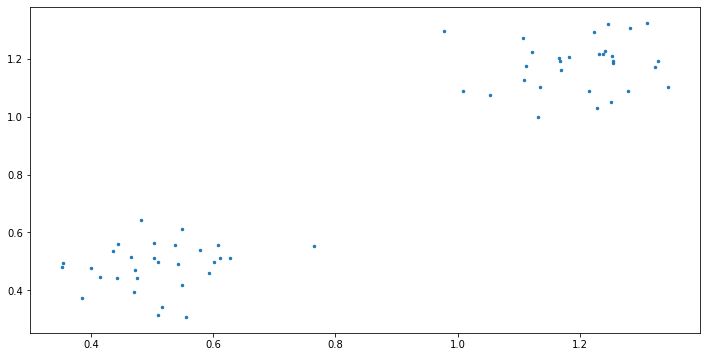

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(data[:,0], data[:,1], s=6)
plt.show()

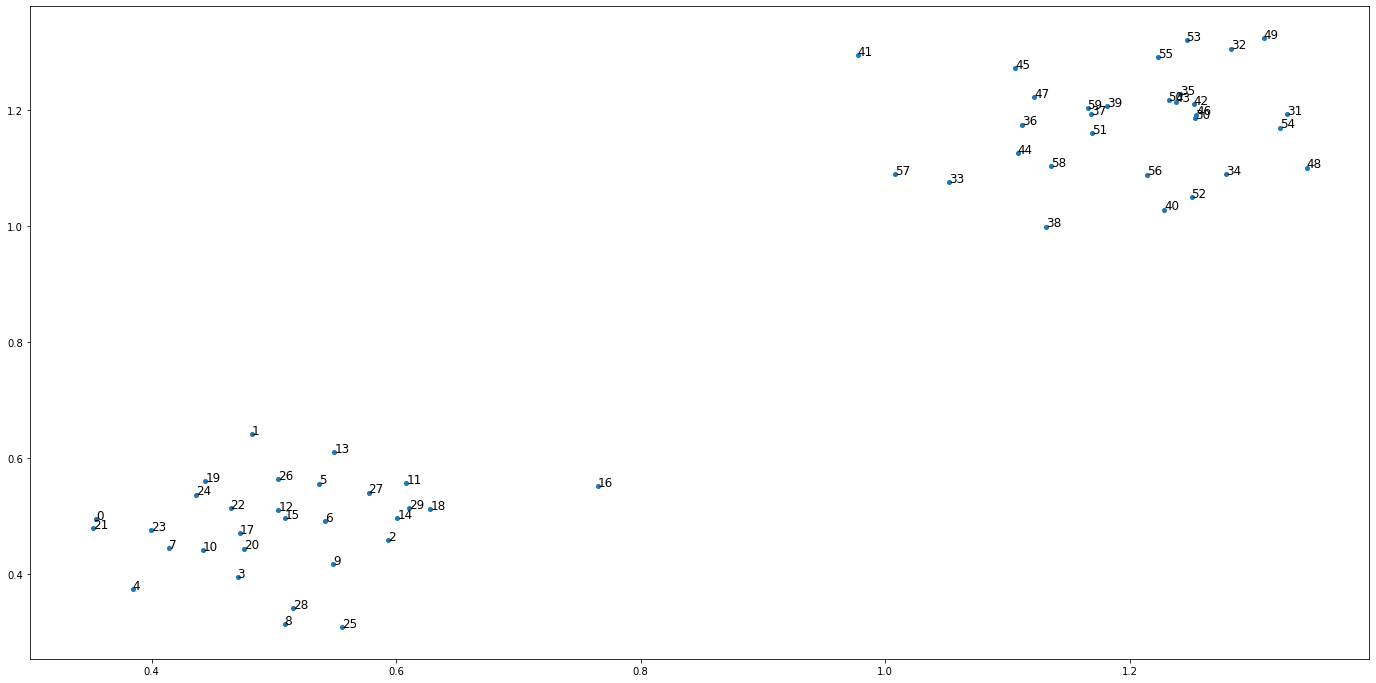

In [17]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(data[:,0], data[:,1], s=16)

ind = 0
for obj in data:
    ax.annotate(str(ind), xy=(obj[0], obj[1]), size=12)
    ind += 1

plt.show()

### Предварительные вычисления расстояний объектов

In [42]:
m = 1 # для метрики ( (a1-b1)^m + (a2-b2)^m + (a3-b3)^m + ... )^1/m
eps = 2.5 # радиус окрестности данной точки, точки в которой считаются её соседями
# корневая точка - точка, в eps окрестности которой содержится minPts точек (помимо неё)
minPts = 4 # минимальное число соседей, чтобы данная точка считалась корневой

In [43]:
def calc__distance(obj1, obj2, m):
    # вычисление расстояния между точками
    return np.sum(np.abs(obj1 - obj2)**m)**(1/m)

In [44]:
def calc__matrix_of_distances(data, m):
    # вычисление матрицы расстояний (все попарные расстояния между точками)
    r_matrix = np.zeros((data.shape[0], data.shape[0]))
    for i in range(data.shape[0] - 1):
        for j in range(i+1, data.shape[0]):
            r_matrix[i, j] = calc__distance(data[i], data[j], m)
            r_matrix[j, i] = r_matrix[i, j]
    return r_matrix

In [45]:
r_matrix = calc__matrix_of_distances(data, m)
r_matrix

array([[0.        , 0.27481417, 0.27415475, ..., 1.24787118, 1.38965872,
        1.51991128],
       [0.27481417, 0.        , 0.29421292, ..., 0.97305701, 1.11484455,
        1.24509711],
       [0.27415475, 0.29421292, 0.        , ..., 1.04536334, 1.18715088,
        1.31740344],
       ...,
       [1.24787118, 0.97305701, 1.04536334, ..., 0.        , 0.14178754,
        0.2720401 ],
       [1.38965872, 1.11484455, 1.18715088, ..., 0.14178754, 0.        ,
        0.13025256],
       [1.51991128, 1.24509711, 1.31740344, ..., 0.2720401 , 0.13025256,
        0.        ]])

In [46]:
class MyObject:
    
    def __init__(self, ind, coords, r_matrix, eps, minPts):
        
        # уникальный индекс нашего объекта (наш объект - конкретная реализация данного класса)
        self.ind = ind
        # координаты нашего объекта
        self.coords = coords
        
        # расстояния до всех объектов от нашего (включая расстояние, равное 0)
        self.dist__of_all = r_matrix[ind]
        # соседи нашего объекта в нашей окрестности (их индексы; среди этих индексов есть индекс и нашего объекта)
        self.neighbours = np.where(r_matrix[ind] <= eps)[0]
        # расстояния до всех соседей в нашей окрестности
        self.dist__of_neighbours = r_matrix[ind, self.neighbours]
        
        # минимальный радиус окрестности r вокруг корневого объекта, 
        # при котором в случае eps == r он ещё остаётся корневым (так называемый core distance);
        # core distance определено, если наш объект корневой (число соседей (без него) >= minPts)
        if self.neighbours.size - 1 >= minPts:
            self.core_distance = np.sort(self.dist__of_neighbours)[minPts]
        else:
            self.core_distance = np.inf
        
        # обработан ли наш объект
        self.processed = False
        
        # в конце работы должно быть посчитано расстояние достижимости (reachability distance), 
        # которое определяется между двумя объектами a и b (при этом a - корневой) 
        # как max(обычное_расстояние(a, b), core_distance(a));
        
        # в алгоритме расстояние достижимости будет вычисляться от нашего объекта до ближайшего корневого объекта,
        # для которого наш объект является соседом
        # (в терминах алгоритма наш объект directly density reachable от этого ближайшего корневого объекта)
        self.reachability_distance = None # после работы алгоритма будет inf, если объект некорневой
    
    def __str__(self):
        obj_in_str = 'Index: ' + str(self.ind) + '\n' + \
                     'Coords: ' + str(self.coords[0]) + '   ' +str(self.coords[1]) + '\n' + \
                     'Distances from all: ' + str(self.dist__of_all) + '\n' + \
                     'Neighbours indexes: ' + str(self.neighbours) + '\n' + \
                     'Distances from neighbours' + str(self.dist__of_neighbours) + '\n' + \
                     'Core distance: ' + str(self.core_distance) + '\n' + \
                     'Processed: ' + str(self.processed) + '\n' + \
                     'Reachability distance: ' + str(self.reachability_distance) + '\n'
        return obj_in_str
        
    def plot__neighbours(self, data):
        # рисует все точки с их индексами, закрашивая соседей нашего объекта
        fig, ax = plt.subplots(figsize=(24, 12))
            
        ax.scatter(data[:,0], data[:,1], s=16, c='b')
        ax.scatter(data[self.neighbours,0], data[self.neighbours,1], s=36, c='g')
        ax.scatter(data[self.ind,0], data[self.ind,1], s=36, c='y') # наш объект жёлтый
            
        ind = 0
        for obj in data:
            ax.annotate(str(ind), xy=(obj[0], obj[1]), size=12)
            ind += 1

        plt.show()

In [47]:
inds = np.arange(0, data.shape[0])
allObjects = np.array([MyObject(ind, coords, r_matrix, eps, minPts) for ind, coords in zip(inds, data)])

In [48]:
print(allObjects[0])

Index: 0
Coords: 0.3547624156536948   0.49467268086474125
Distances from all: [0.         0.27481417 0.27415475 0.21489832 0.15059328 0.24396437
 0.19003508 0.10928704 0.33400823 0.27096248 0.14050873 0.31636427
 0.16497349 0.31085767 0.24868379 0.15651606 0.46768121 0.14120906
 0.29087167 0.15560826 0.17104024 0.017989   0.12921598 0.06291718
 0.12414113 0.3872568  0.21776123 0.2690046  0.31388797 0.27501011
 1.59029493 1.67206987 1.73913959 1.27866177 1.51916099 1.61907384
 1.43774283 1.51166958 1.2808975  1.53908406 1.40704906 1.42311511
 1.61277134 1.60270964 1.38433513 1.52889119 1.5967928  1.49455859
 1.59612112 1.78477602 1.59919552 1.48000769 1.45083808 1.71734107
 1.64368442 1.66566598 1.45370122 1.24787118 1.38965872 1.51991128]
Neighbours indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Distances from neighbours[0.         0.27481417

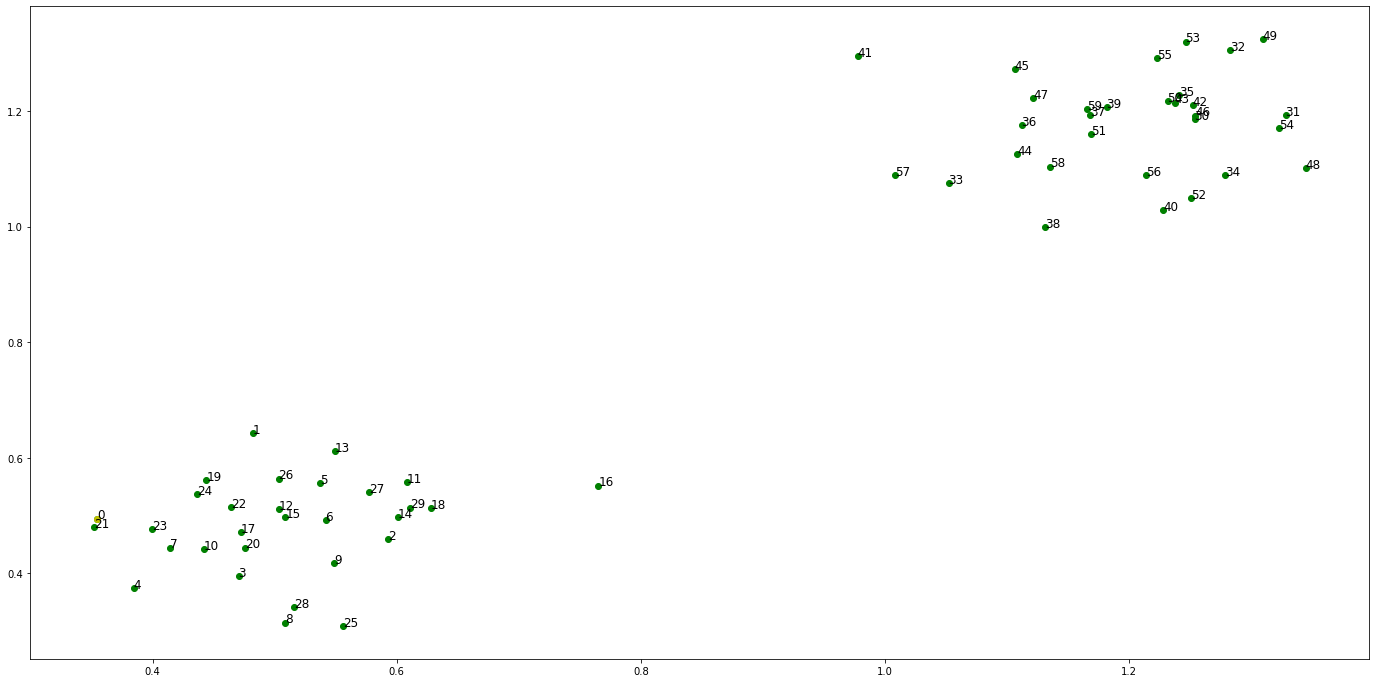

In [49]:
allObjects[0].plot__neighbours(data)

### Работа алгоритма

In [50]:
# массив order - порядок объектов, в котором должен строиться график расстояния достижимости;
# этот порядок формируется таким образом, 
# чтобы по мере прохождения по всем точкам сканировать окрестность каждой точки
# и из неё заносить в order в первую очередь те точки, которые имеют наименьшие расстояния достижимости; 
# так обрабатывается кластер за кластером, учитывается иерархия этих кластеров
order = []

pq = PriorityQueue()

In [51]:
def update_pq(obj, allObjects, pq):
    
    obj.plot__neighbours(data)
    
    neighbObjects = allObjects[obj.neighbours]
    for neighb_obj in neighbObjects:
        
        if neighb_obj.processed == False:
        
            if neighb_obj.ind != obj.ind:
            
                new_r_dist = max(obj.core_distance, r_matrix[obj.ind, neighb_obj.ind])
            
                if type(neighb_obj.reachability_distance) == type(None):
                    neighb_obj.reachability_distance = new_r_dist
                    pq.insert_or_update__element(neighb_obj.ind, neighb_obj.reachability_distance)
                else:
                    if new_r_dist < neighb_obj.reachability_distance:
                        neighb_obj.reachability_distance = new_r_dist
                        pq.insert_or_update__element(neighb_obj.ind, neighb_obj.reachability_distance)
    print(pq)
    
    return pq 

In [52]:
def expand_cluster_order(obj, allObjects, pq, order):
    
    obj.processed = True
    order.append(obj.ind)
    
    print(order)
    
    if obj.core_distance != np.inf:
        pq = update_pq(obj, allObjects, pq)
        
        while pq.objects.shape[0] != 0:
            
            curr_obj = allObjects[int(pq.next__element()[0])]
            
            curr_obj.processed = True
            order.append(curr_obj.ind)
            
            print(order)
            
            if curr_obj.core_distance != np.inf:
                pq = update_pq(curr_obj, allObjects, pq)

[0]


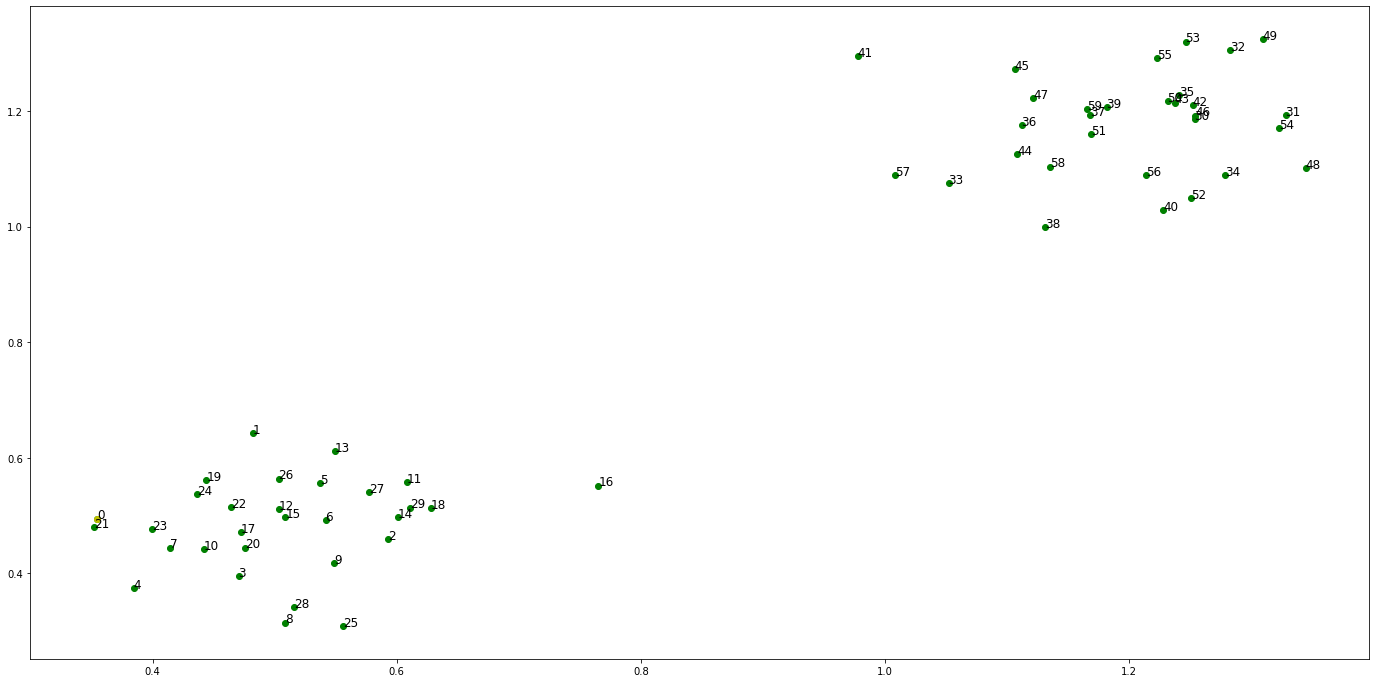

Index: 7.0
Reach dist: 0.12414113244478747

Index: 21.0
Reach dist: 0.12414113244478747

Index: 24.0
Reach dist: 0.12414113244478747

Index: 23.0
Reach dist: 0.12414113244478747

Index: 22.0
Reach dist: 0.12921598202128887

Index: 10.0
Reach dist: 0.14050873435183187

Index: 17.0
Reach dist: 0.14120906472951328

Index: 4.0
Reach dist: 0.15059327889534246

Index: 19.0
Reach dist: 0.15560826386197207

Index: 15.0
Reach dist: 0.1565160564147432

Index: 12.0
Reach dist: 0.16497348745958307

Index: 20.0
Reach dist: 0.17104023726411227

Index: 6.0
Reach dist: 0.19003507604784575

Index: 3.0
Reach dist: 0.2148983240009082

Index: 26.0
Reach dist: 0.21776123175017015

Index: 5.0
Reach dist: 0.24396436943398048

Index: 14.0
Reach dist: 0.2486837877673413

Index: 27.0
Reach dist: 0.26900460195063614

Index: 9.0
Reach dist: 0.27096248461709166

Index: 2.0
Reach dist: 0.27415474711552895

Index: 1.0
Reach dist: 0.274814170191524

Index: 29.0
Reach dist: 0.27501011283350163

Index: 18.0
Reach dist:

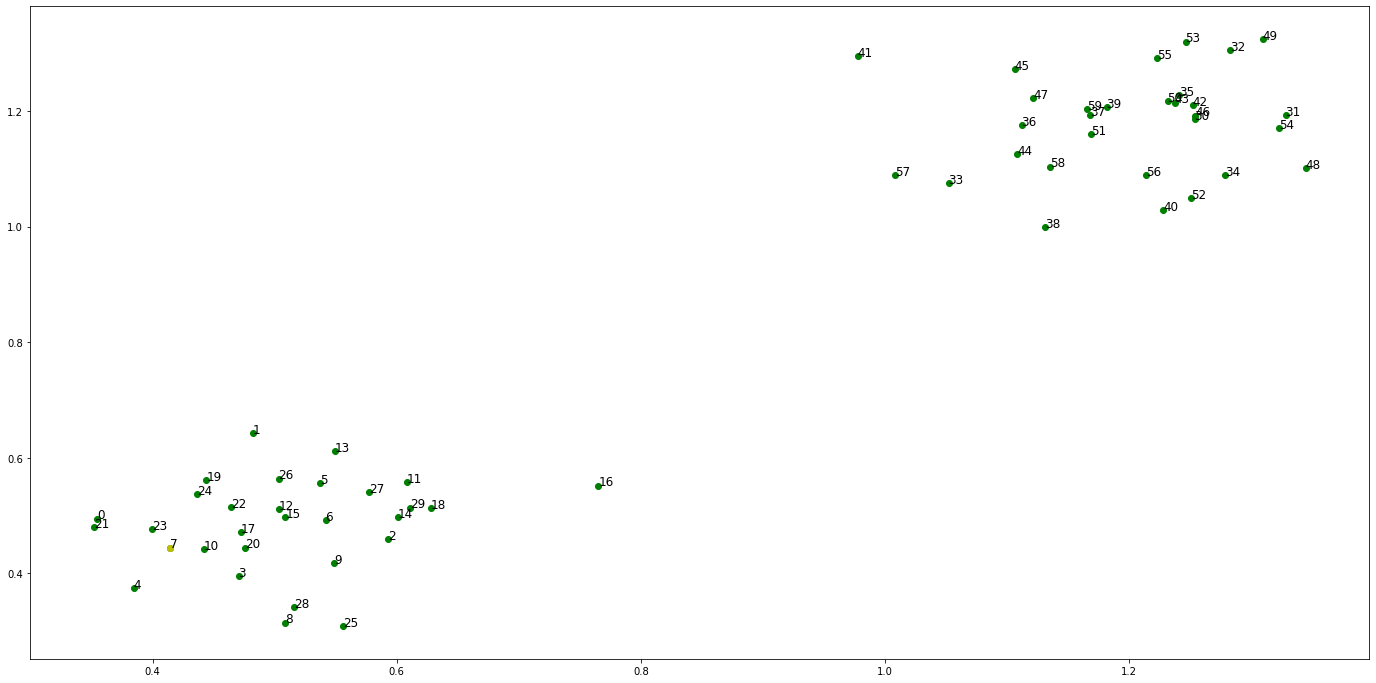

Index: 10.0
Reach dist: 0.08445223542194608

Index: 17.0
Reach dist: 0.08445223542194608

Index: 20.0
Reach dist: 0.08445223542194608

Index: 23.0
Reach dist: 0.08445223542194608

Index: 21.0
Reach dist: 0.09691052223357755

Index: 4.0
Reach dist: 0.10007011391716736

Index: 3.0
Reach dist: 0.10561128110130985

Index: 24.0
Reach dist: 0.11496996348567662

Index: 22.0
Reach dist: 0.12004481306217801

Index: 19.0
Reach dist: 0.14643709490286122

Index: 15.0
Reach dist: 0.14734488745563235

Index: 12.0
Reach dist: 0.15580231850047221

Index: 9.0
Reach dist: 0.16167544171749332

Index: 6.0
Reach dist: 0.17457667633223084

Index: 2.0
Reach dist: 0.19333666955544343

Index: 28.0
Reach dist: 0.2046009250890689

Index: 26.0
Reach dist: 0.2085900627910593

Index: 8.0
Reach dist: 0.22472118240042482

Index: 5.0
Reach dist: 0.23479320047486962

Index: 14.0
Reach dist: 0.23951261880823044

Index: 27.0
Reach dist: 0.2598334329915253

Index: 1.0
Reach dist: 0.26564300123241313

Index: 29.0
Reach dis

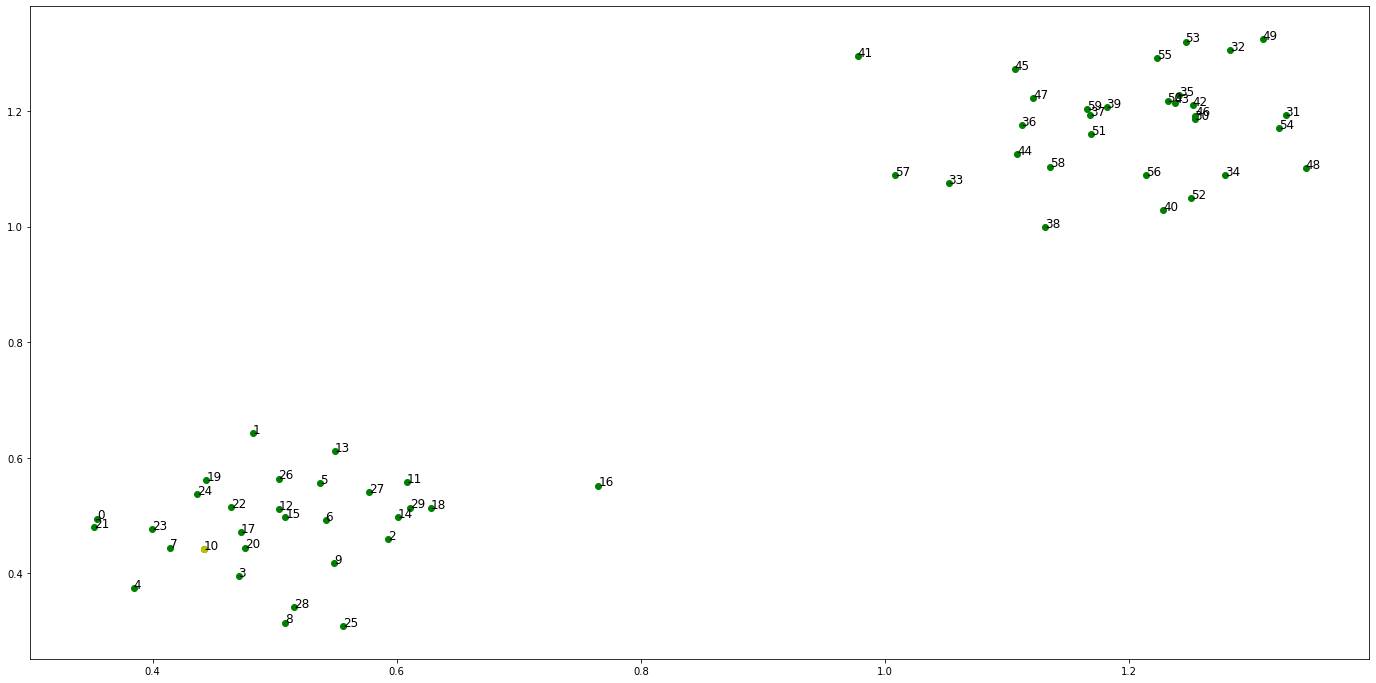

Index: 3.0
Reach dist: 0.07438958964907633

Index: 17.0
Reach dist: 0.07438958964907633

Index: 20.0
Reach dist: 0.07438958964907633

Index: 23.0
Reach dist: 0.0775915495413621

Index: 22.0
Reach dist: 0.09525448843110623

Index: 21.0
Reach dist: 0.09691052223357755

Index: 4.0
Reach dist: 0.10007011391716736

Index: 24.0
Reach dist: 0.10159710596226795

Index: 19.0
Reach dist: 0.12164677027178944

Index: 15.0
Reach dist: 0.12255456282456056

Index: 9.0
Reach dist: 0.1304537502652598

Index: 12.0
Reach dist: 0.13101199386940043

Index: 6.0
Reach dist: 0.14978635170115906

Index: 2.0
Reach dist: 0.16854634492437165

Index: 28.0
Reach dist: 0.17337923363683538

Index: 26.0
Reach dist: 0.1837997381599875

Index: 8.0
Reach dist: 0.1934994909481913

Index: 5.0
Reach dist: 0.21000287584379784

Index: 14.0
Reach dist: 0.21472229417715866

Index: 27.0
Reach dist: 0.2350431083604535

Index: 1.0
Reach dist: 0.24085267660134135

Index: 29.0
Reach dist: 0.241048619243319

Index: 25.0
Reach dist: 0

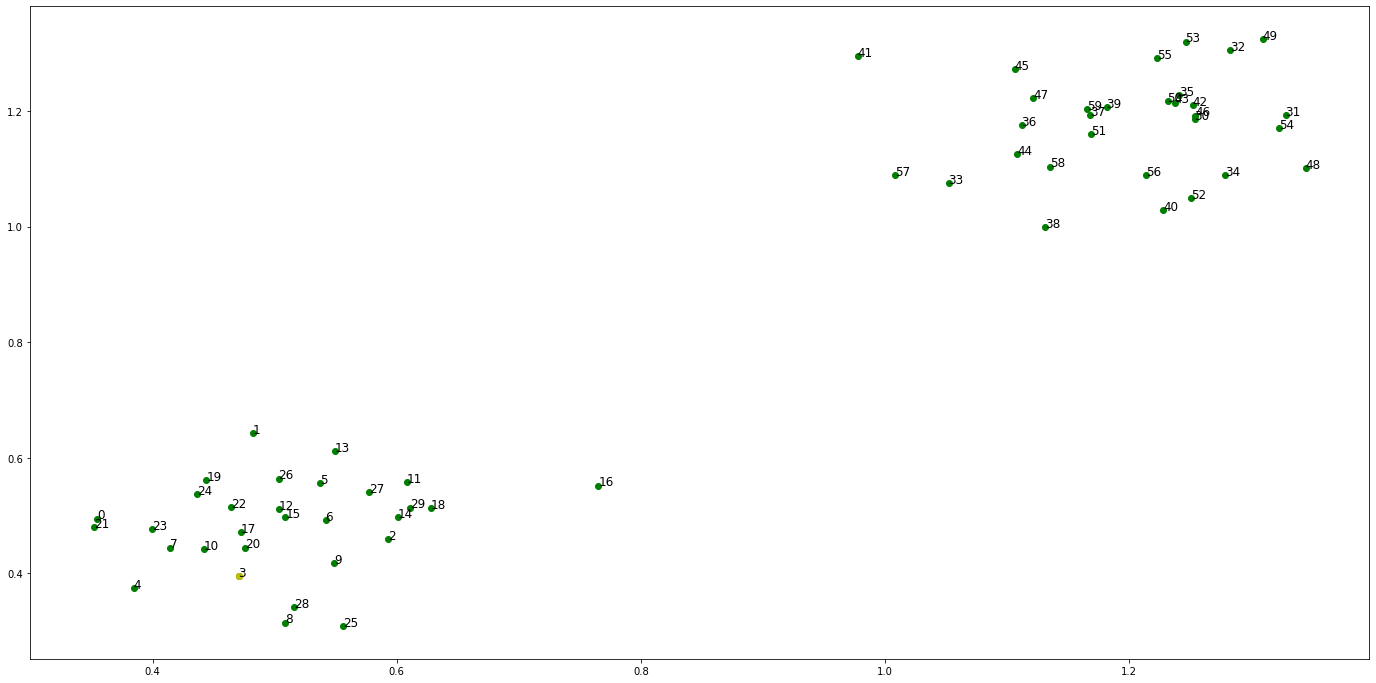

Index: 17.0
Reach dist: 0.07438958964907633

Index: 20.0
Reach dist: 0.07438958964907633

Index: 23.0
Reach dist: 0.0775915495413621

Index: 22.0
Reach dist: 0.09525448843110623

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 9.0
Reach dist: 0.10029331081976212

Index: 24.0
Reach dist: 0.10159710596226795

Index: 8.0
Reach dist: 0.11910990129911497

Index: 19.0
Reach dist: 0.12164677027178944

Index: 15.0
Reach dist: 0.12255456282456056

Index: 12.0
Reach dist: 0.13101199386940043

Index: 6.0
Reach dist: 0.14978635170115906

Index: 2.0
Reach dist: 0.16854634492437165

Index: 25.0
Reach dist: 0.17235847122968173

Index: 26.0
Reach dist: 0.1837997381599875

Index: 5.0
Reach dist: 0.21000287584379784

Index: 14.0
Reach dist: 0.21472229417715866

Index: 27.0
Reach dist: 0.2350431083604535

Index: 1.0
Reach dist: 0.24085267660134135

Index: 29.0
Reach dist: 0.241048619243319

Index: 18.0
Reach dist

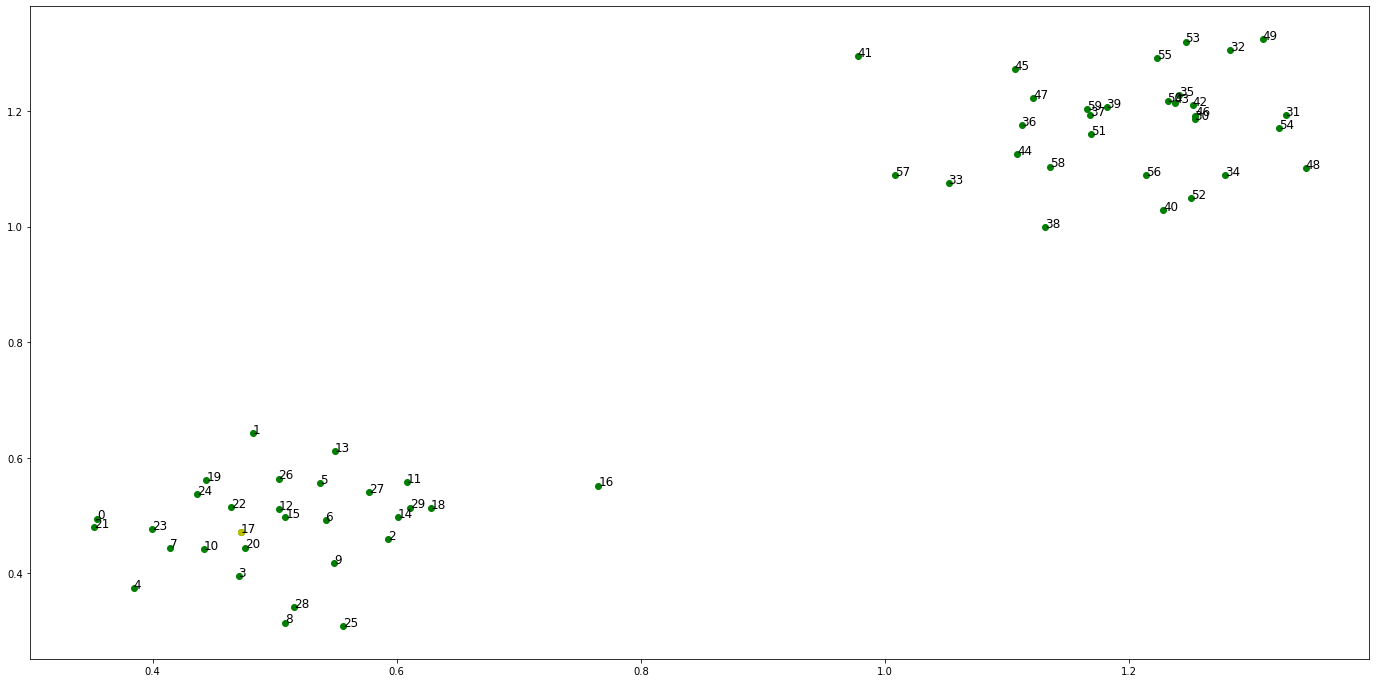

Index: 15.0
Reach dist: 0.06289265203368627

Index: 20.0
Reach dist: 0.06289265203368627

Index: 22.0
Reach dist: 0.06289265203368627

Index: 12.0
Reach dist: 0.07135008307852614

Index: 23.0
Reach dist: 0.0775915495413621

Index: 6.0
Reach dist: 0.09012444091028476

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 9.0
Reach dist: 0.10029331081976212

Index: 24.0
Reach dist: 0.10159710596226795

Index: 19.0
Reach dist: 0.11864735700797091

Index: 8.0
Reach dist: 0.11910990129911497

Index: 26.0
Reach dist: 0.12413782736911322

Index: 2.0
Reach dist: 0.13294568238601567

Index: 5.0
Reach dist: 0.15034096505292355

Index: 14.0
Reach dist: 0.15506038338628436

Index: 25.0
Reach dist: 0.17235847122968173

Index: 27.0
Reach dist: 0.1753811975695792

Index: 1.0
Reach dist: 0.18119076581046706

Index: 29.0
Reach dist: 0.1813867084524447

Index: 18.0
Reach dist: 0.19724827041309595

Index: 13.0
Reach di

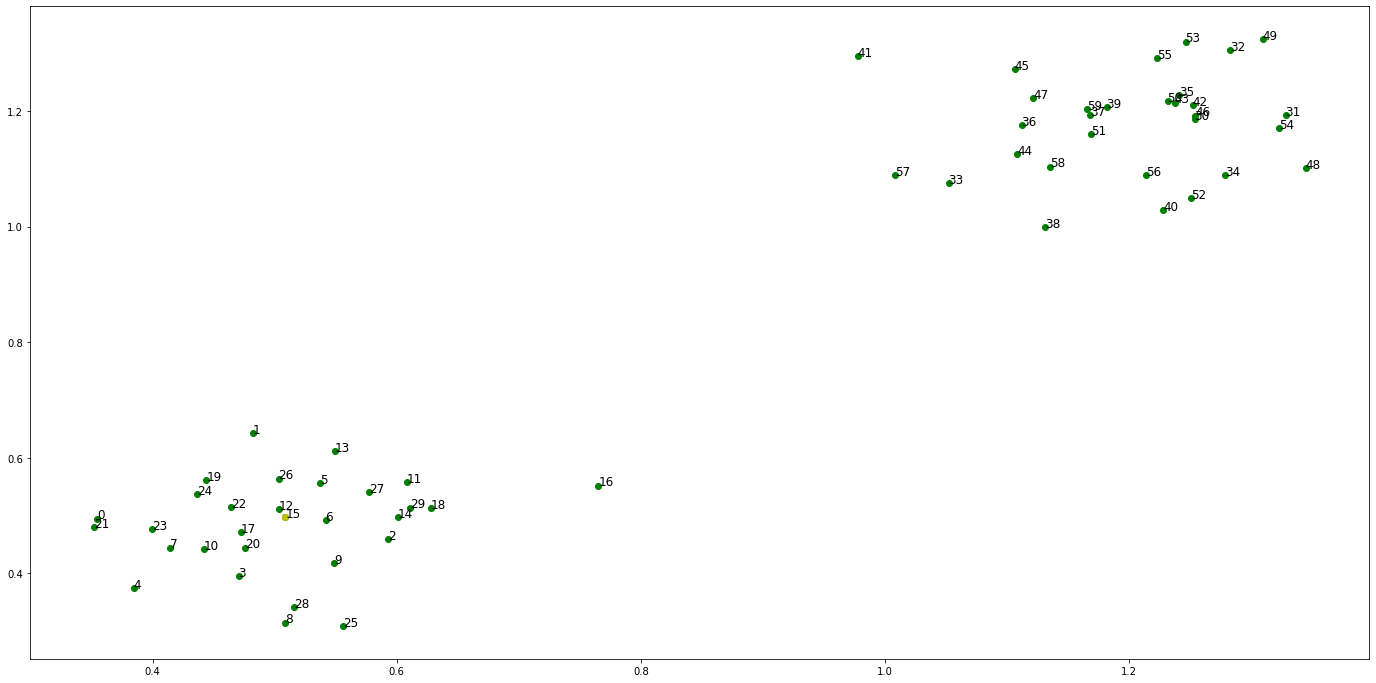

Index: 20.0
Reach dist: 0.06289265203368627

Index: 22.0
Reach dist: 0.06289265203368627

Index: 6.0
Reach dist: 0.06289265203368627

Index: 12.0
Reach dist: 0.06289265203368627

Index: 26.0
Reach dist: 0.072502607426988

Index: 23.0
Reach dist: 0.0775915495413621

Index: 5.0
Reach dist: 0.08744831301923728

Index: 14.0
Reach dist: 0.0925374573859899

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 9.0
Reach dist: 0.10029331081976212

Index: 24.0
Reach dist: 0.10159710596226795

Index: 27.0
Reach dist: 0.11248854553589294

Index: 29.0
Reach dist: 0.11849405641875843

Index: 19.0
Reach dist: 0.11864735700797091

Index: 8.0
Reach dist: 0.11910990129911497

Index: 2.0
Reach dist: 0.12272290452002949

Index: 18.0
Reach dist: 0.13435561837940968

Index: 13.0
Reach dist: 0.15434161106344213

Index: 11.0
Reach dist: 0.1598482130520248

Index: 1.0
Reach dist: 0.1714900123739923

Index: 25.0
Reach dist:

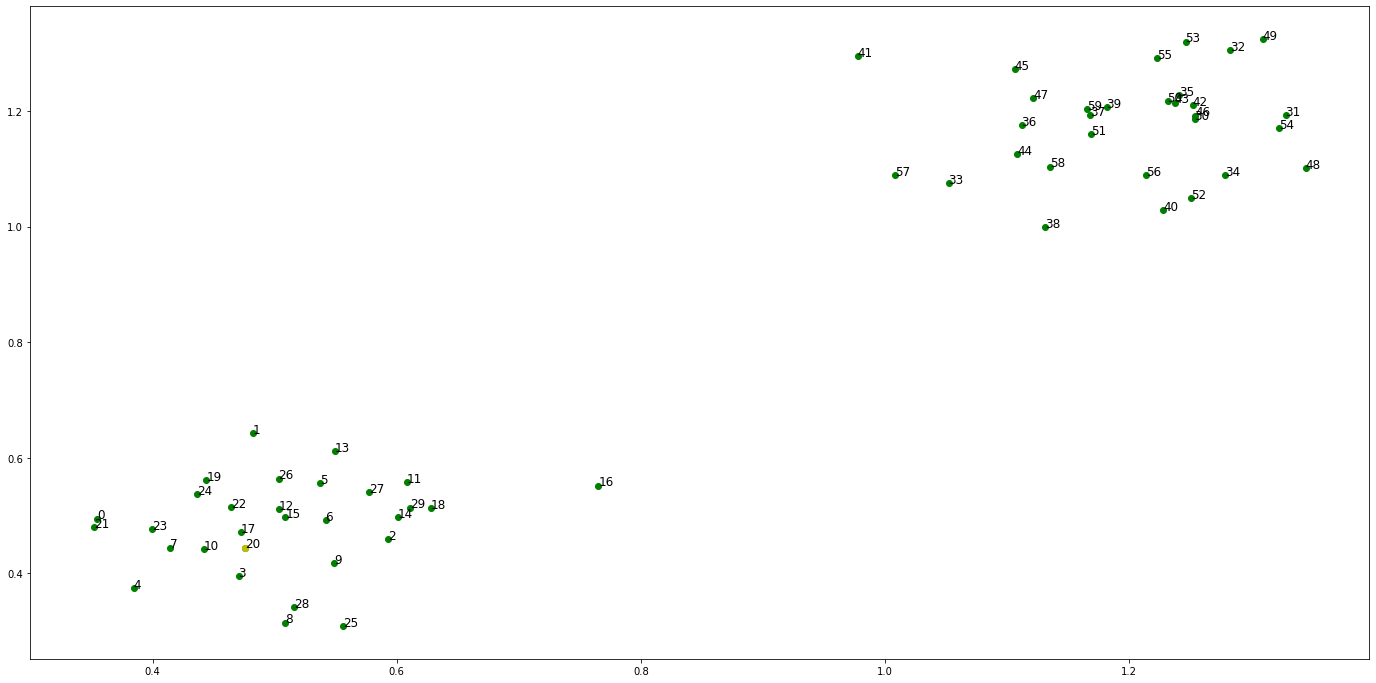

Index: 22.0
Reach dist: 0.06289265203368627

Index: 6.0
Reach dist: 0.06289265203368627

Index: 12.0
Reach dist: 0.06289265203368627

Index: 26.0
Reach dist: 0.072502607426988

Index: 23.0
Reach dist: 0.0775915495413621

Index: 5.0
Reach dist: 0.08744831301923728

Index: 14.0
Reach dist: 0.0925374573859899

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 9.0
Reach dist: 0.09992224735297939

Index: 4.0
Reach dist: 0.10007011391716736

Index: 24.0
Reach dist: 0.10159710596226795

Index: 27.0
Reach dist: 0.11248854553589294

Index: 29.0
Reach dist: 0.11849405641875843

Index: 19.0
Reach dist: 0.11864735700797091

Index: 8.0
Reach dist: 0.11910990129911497

Index: 2.0
Reach dist: 0.12272290452002949

Index: 18.0
Reach dist: 0.13435561837940968

Index: 13.0
Reach dist: 0.15434161106344213

Index: 11.0
Reach dist: 0.1598482130520248

Index: 1.0
Reach dist: 0.1714900123739923

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist:

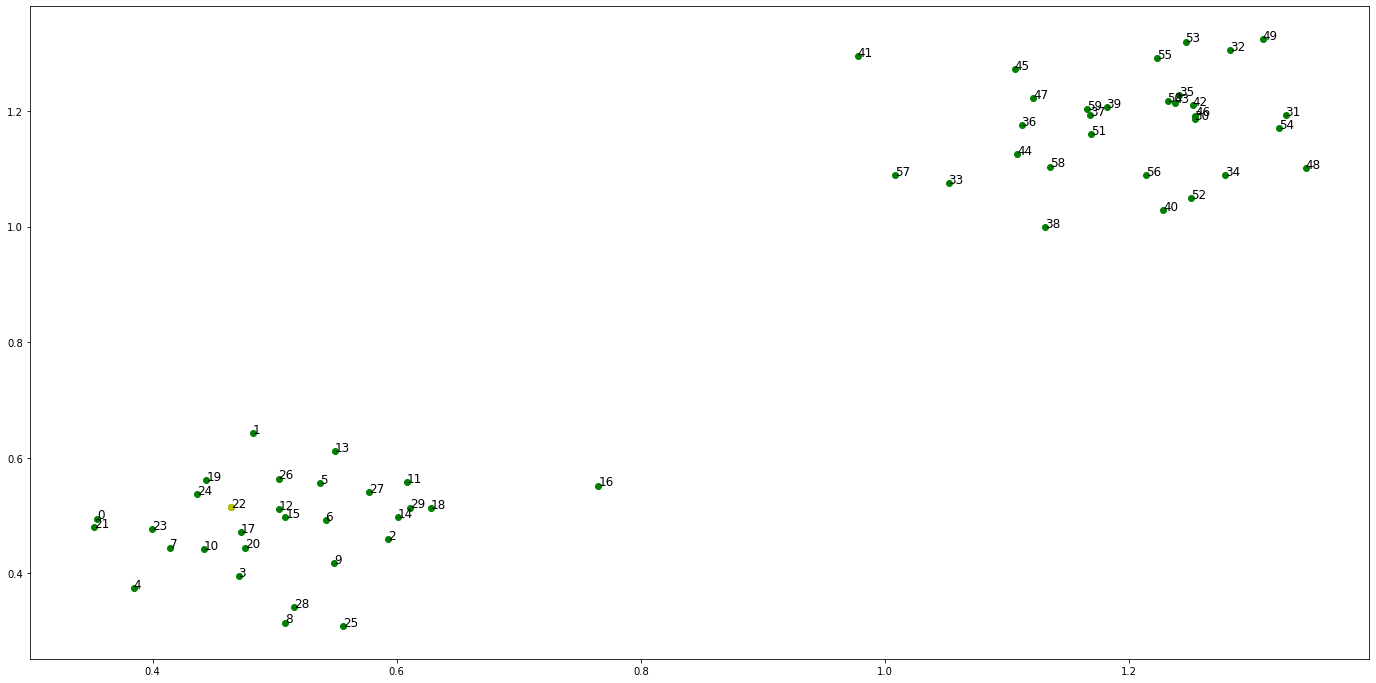

Index: 12.0
Reach dist: 0.06105461489907266

Index: 24.0
Reach dist: 0.06105461489907266

Index: 6.0
Reach dist: 0.06289265203368627

Index: 19.0
Reach dist: 0.06781551997488444

Index: 26.0
Reach dist: 0.072502607426988

Index: 23.0
Reach dist: 0.0775915495413621

Index: 5.0
Reach dist: 0.08744831301923728

Index: 14.0
Reach dist: 0.0925374573859899

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 9.0
Reach dist: 0.09992224735297939

Index: 4.0
Reach dist: 0.10007011391716736

Index: 27.0
Reach dist: 0.11248854553589294

Index: 29.0
Reach dist: 0.11849405641875843

Index: 8.0
Reach dist: 0.11910990129911497

Index: 2.0
Reach dist: 0.12272290452002949

Index: 18.0
Reach dist: 0.13435561837940968

Index: 1.0
Reach dist: 0.14559818817023512

Index: 13.0
Reach dist: 0.15434161106344213

Index: 11.0
Reach dist: 0.1598482130520248

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.3111651504682258

Index: 57.0
Reach dist:

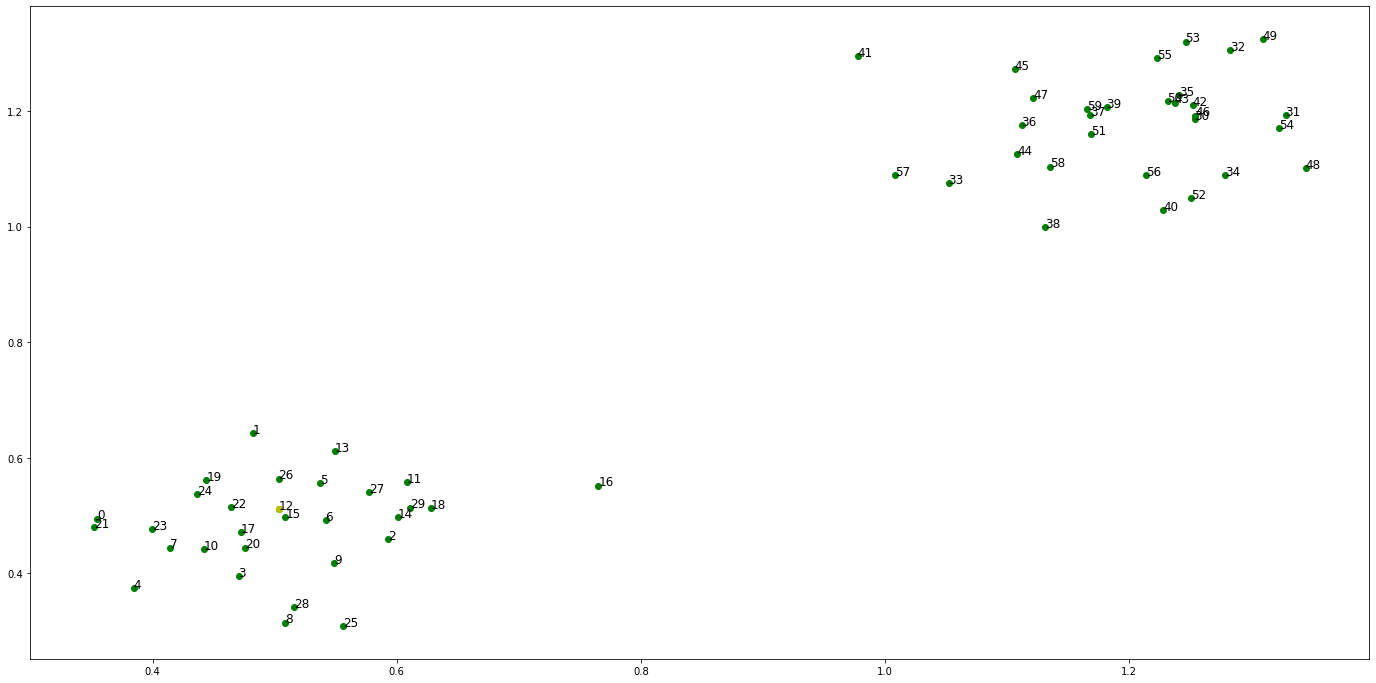

Index: 6.0
Reach dist: 0.05737596202763162

Index: 26.0
Reach dist: 0.05737596202763162

Index: 24.0
Reach dist: 0.06105461489907266

Index: 19.0
Reach dist: 0.06781551997488444

Index: 23.0
Reach dist: 0.0775915495413621

Index: 5.0
Reach dist: 0.07899088197439741

Index: 14.0
Reach dist: 0.0925374573859899

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 9.0
Reach dist: 0.09992224735297939

Index: 4.0
Reach dist: 0.10007011391716736

Index: 27.0
Reach dist: 0.10403111449105307

Index: 29.0
Reach dist: 0.11003662537391856

Index: 8.0
Reach dist: 0.11910990129911497

Index: 2.0
Reach dist: 0.12272290452002949

Index: 18.0
Reach dist: 0.1258981873345698

Index: 1.0
Reach dist: 0.14559818817023512

Index: 13.0
Reach dist: 0.14588418001860226

Index: 11.0
Reach dist: 0.15139078200718492

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.3027077194233859

Index: 57.0
Reach dist: 1.0828976903491996

Index: 33.0
Reach dist

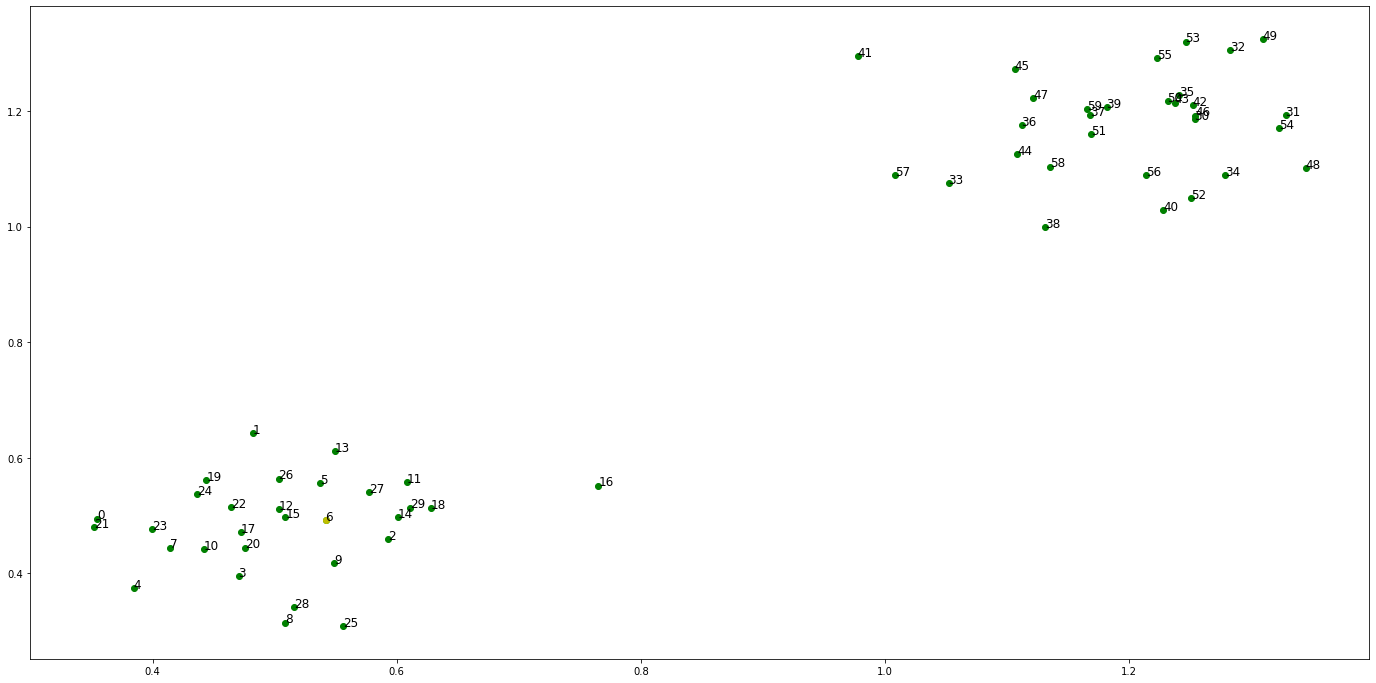

Index: 26.0
Reach dist: 0.05737596202763162

Index: 24.0
Reach dist: 0.06105461489907266

Index: 19.0
Reach dist: 0.06781551997488444

Index: 5.0
Reach dist: 0.06952834403285835

Index: 14.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 2.0
Reach dist: 0.0841196710676832

Index: 27.0
Reach dist: 0.08525675665929444

Index: 29.0
Reach dist: 0.09126226754215994

Index: 21.0
Reach dist: 0.09691052223357755

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 18.0
Reach dist: 0.10712382950281119

Index: 8.0
Reach dist: 0.11910990129911497

Index: 13.0
Reach dist: 0.12710982218684364

Index: 11.0
Reach dist: 0.1326164241754263

Index: 1.0
Reach dist: 0.14559818817023512

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.2839333615916273

Index: 57.0
Reach dist: 1.0641233325174408

Index: 33.0
Reach dist: 1.0949139288085785

Index: 38.0
Reach dist:

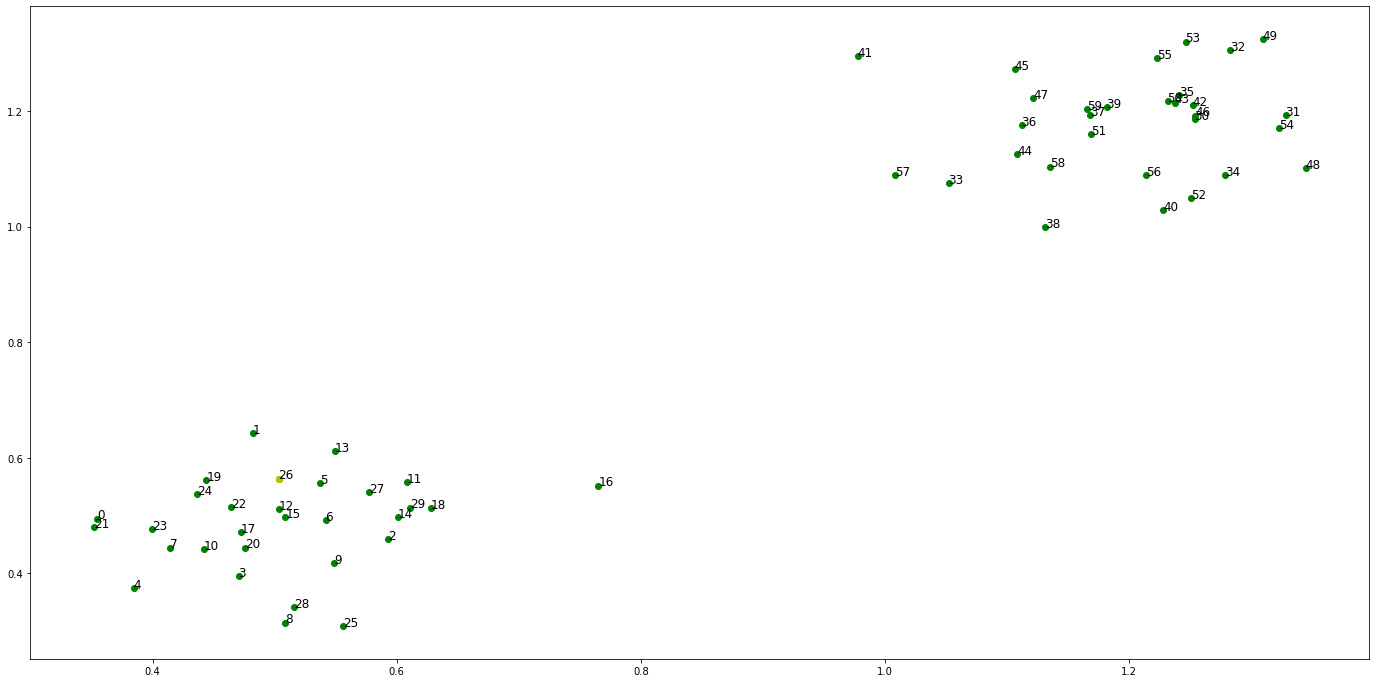

Index: 24.0
Reach dist: 0.06105461489907266

Index: 19.0
Reach dist: 0.06781551997488444

Index: 5.0
Reach dist: 0.06952834403285835

Index: 14.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 2.0
Reach dist: 0.0841196710676832

Index: 27.0
Reach dist: 0.08525675665929444

Index: 29.0
Reach dist: 0.09126226754215994

Index: 13.0
Reach dist: 0.09309643572801518

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 18.0
Reach dist: 0.10712382950281119

Index: 11.0
Reach dist: 0.11188247625641767

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.274346260346476

Index: 57.0
Reach dist: 1.0301099460586123

Index: 33.0
Reach dist: 1.0609005423497502

Index: 38.0
Reach dist: 1.0631362646792284

Index: 44.0
Reach dist: 

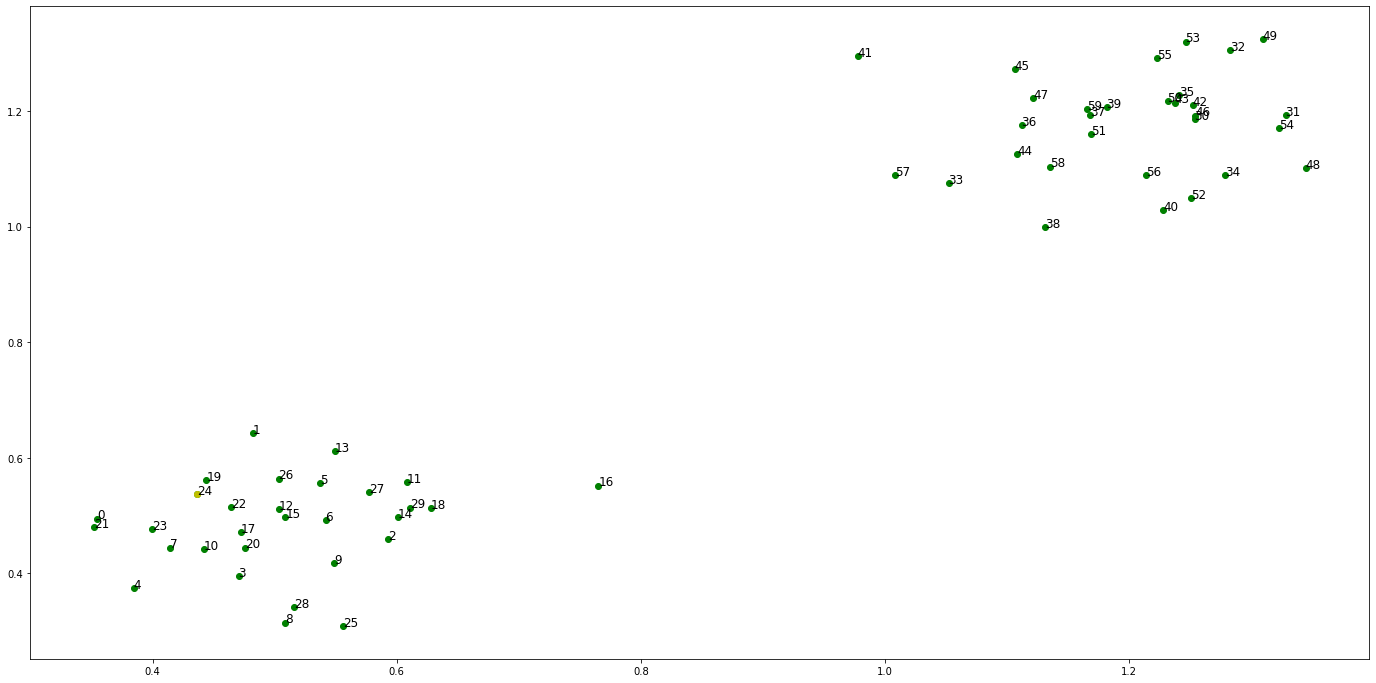

Index: 19.0
Reach dist: 0.06781551997488444

Index: 5.0
Reach dist: 0.06952834403285835

Index: 14.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 2.0
Reach dist: 0.0841196710676832

Index: 27.0
Reach dist: 0.08525675665929444

Index: 29.0
Reach dist: 0.09126226754215994

Index: 13.0
Reach dist: 0.09309643572801518

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 18.0
Reach dist: 0.10712382950281119

Index: 11.0
Reach dist: 0.11188247625641767

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.274346260346476

Index: 57.0
Reach dist: 1.0301099460586123

Index: 33.0
Reach dist: 1.0609005423497502

Index: 38.0
Reach dist: 1.0631362646792284

Index: 44.0
Reach dist: 1.1665738935638221

Index: 58.0
Reach dist: 1

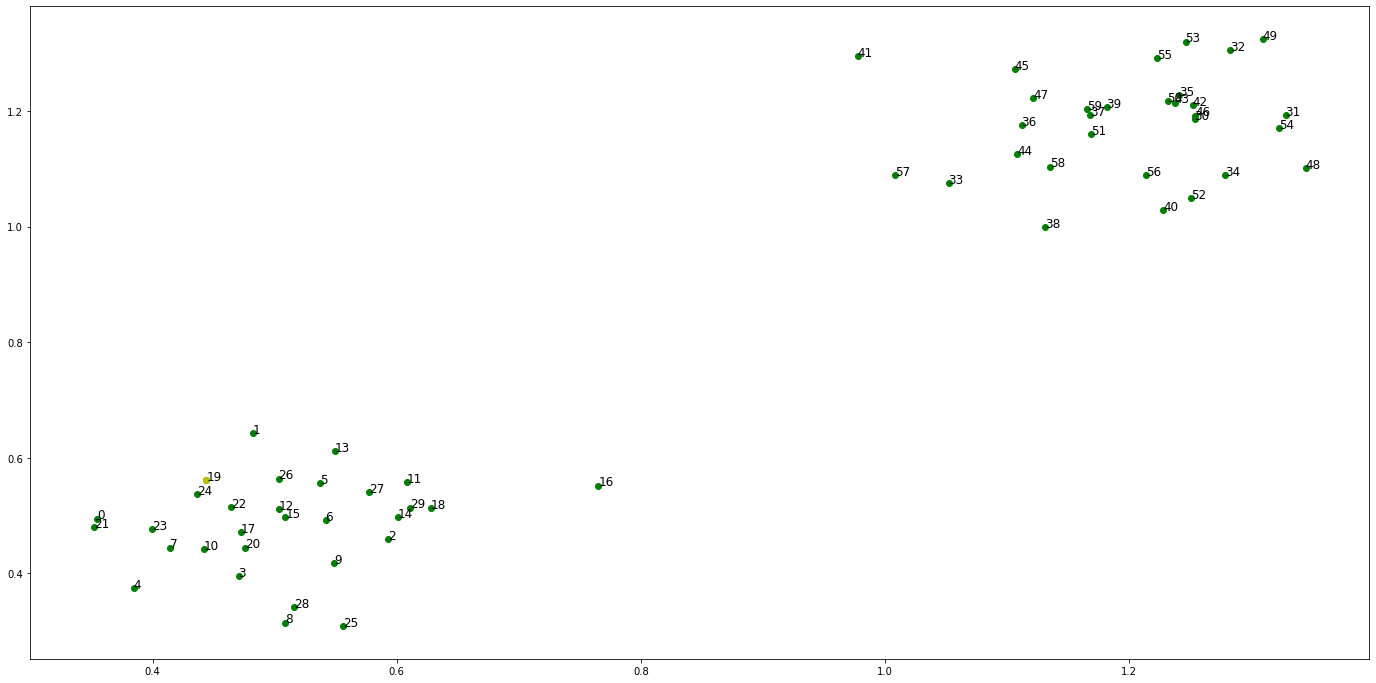

Index: 5.0
Reach dist: 0.06952834403285835

Index: 14.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 2.0
Reach dist: 0.0841196710676832

Index: 27.0
Reach dist: 0.08525675665929444

Index: 29.0
Reach dist: 0.09126226754215994

Index: 13.0
Reach dist: 0.09309643572801518

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 18.0
Reach dist: 0.10712382950281119

Index: 11.0
Reach dist: 0.11188247625641767

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.274346260346476

Index: 57.0
Reach dist: 1.0301099460586123

Index: 33.0
Reach dist: 1.0609005423497502

Index: 38.0
Reach dist: 1.0631362646792284

Index: 44.0
Reach dist: 1.1665738935638221

Index: 58.0
Reach dist: 1.1718974897448642

Index: 40.0
Reach dist: 1.

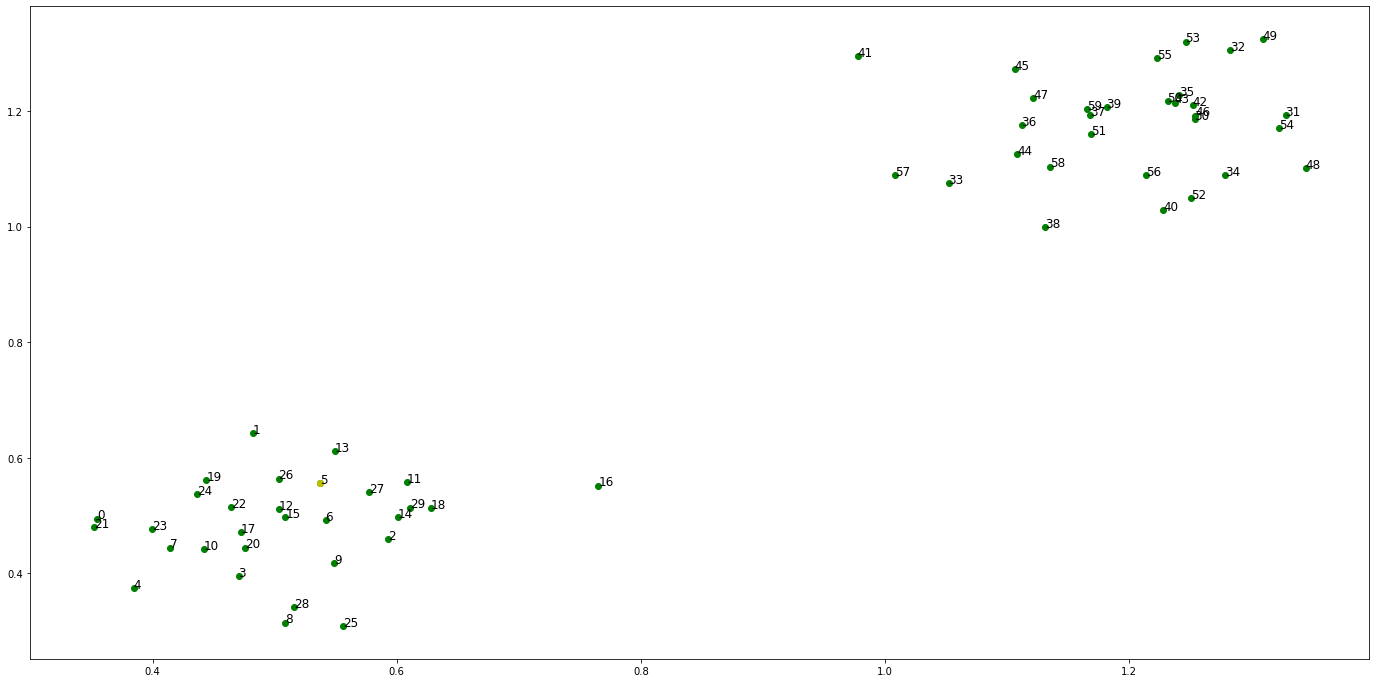

Index: 14.0
Reach dist: 0.06952834403285835

Index: 13.0
Reach dist: 0.06952834403285835

Index: 27.0
Reach dist: 0.06952834403285835

Index: 11.0
Reach dist: 0.07239990003278751

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 2.0
Reach dist: 0.0841196710676832

Index: 29.0
Reach dist: 0.09126226754215994

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 18.0
Reach dist: 0.10712382950281119

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.2327687635000001

Index: 57.0
Reach dist: 1.003906808374802

Index: 33.0
Reach dist: 1.0346974046659398

Index: 38.0
Reach dist: 1.036933126995418

Index: 44.0
Reach dist: 1.1403707558800118

Index: 58.0
Reach dist: 1.1456943520610539

Index: 40.0
Reach dist: 1.163084691021381

Index: 41.0
Reach dist: 1.17

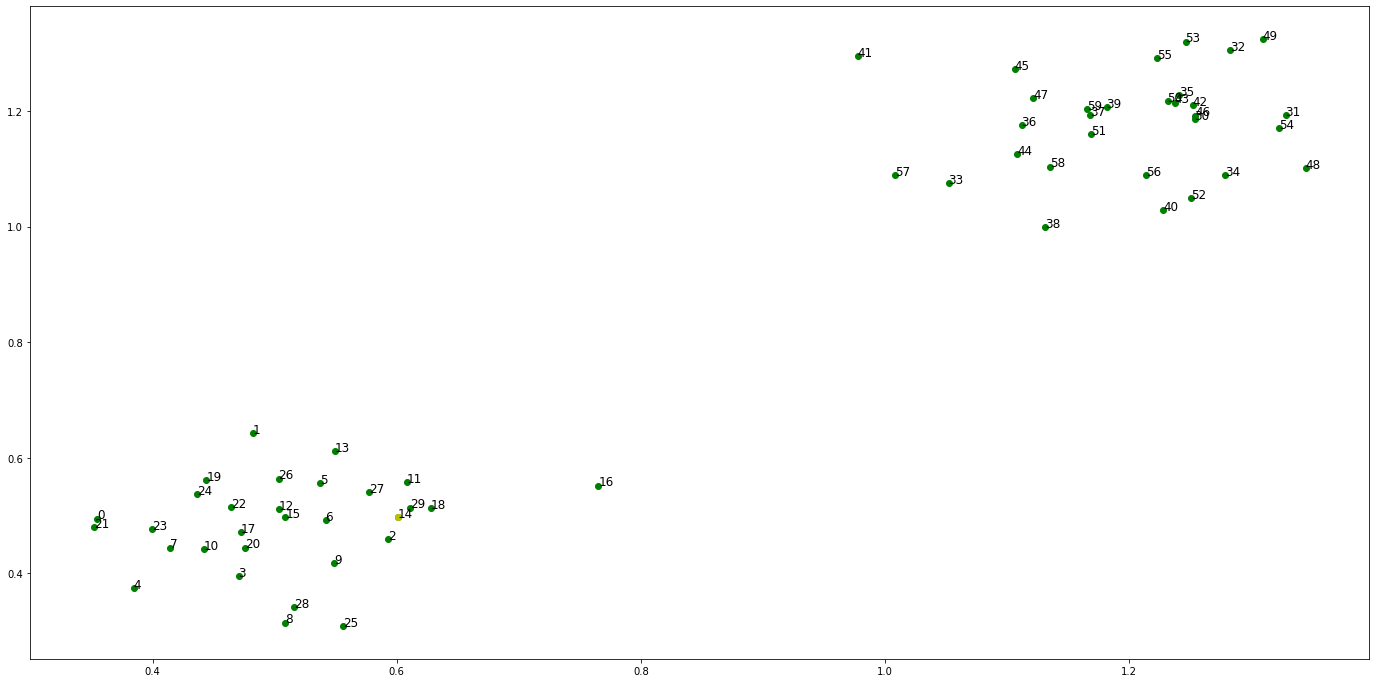

Index: 2.0
Reach dist: 0.0649359424759996

Index: 18.0
Reach dist: 0.0649359424759996

Index: 29.0
Reach dist: 0.0649359424759996

Index: 27.0
Reach dist: 0.06758475593165797

Index: 11.0
Reach dist: 0.0676804816994267

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.2189974191156277

Index: 57.0
Reach dist: 0.9991873900414412

Index: 33.0
Reach dist: 1.0299779863325789

Index: 38.0
Reach dist: 1.0322137086620573

Index: 44.0
Reach dist: 1.1356513375466508

Index: 58.0
Reach dist: 1.140974933727693

Index: 40.0
Reach dist: 1.15836527268802

Index: 41.0
Reach dist: 1.1744313239191304

Index: 36.0
Reach dist: 1.189059

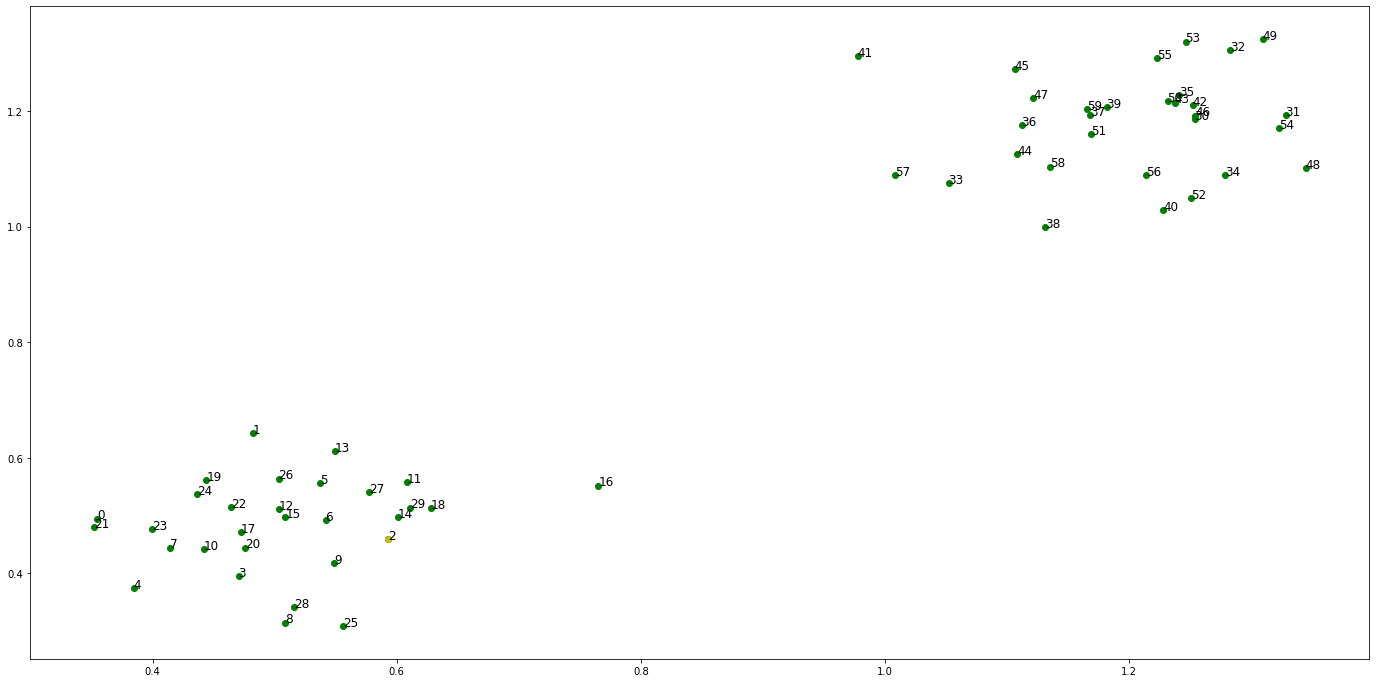

Index: 18.0
Reach dist: 0.0649359424759996

Index: 29.0
Reach dist: 0.0649359424759996

Index: 27.0
Reach dist: 0.06758475593165797

Index: 11.0
Reach dist: 0.0676804816994267

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.2189974191156277

Index: 57.0
Reach dist: 0.9991873900414412

Index: 33.0
Reach dist: 1.0299779863325789

Index: 38.0
Reach dist: 1.0322137086620573

Index: 44.0
Reach dist: 1.1356513375466508

Index: 58.0
Reach dist: 1.140974933727693

Index: 40.0
Reach dist: 1.15836527268802

Index: 41.0
Reach dist: 1.1744313239191304

Index: 36.0
Reach dist: 1.1890590440719637

Index: 52.0
Reach dist: 1.20215

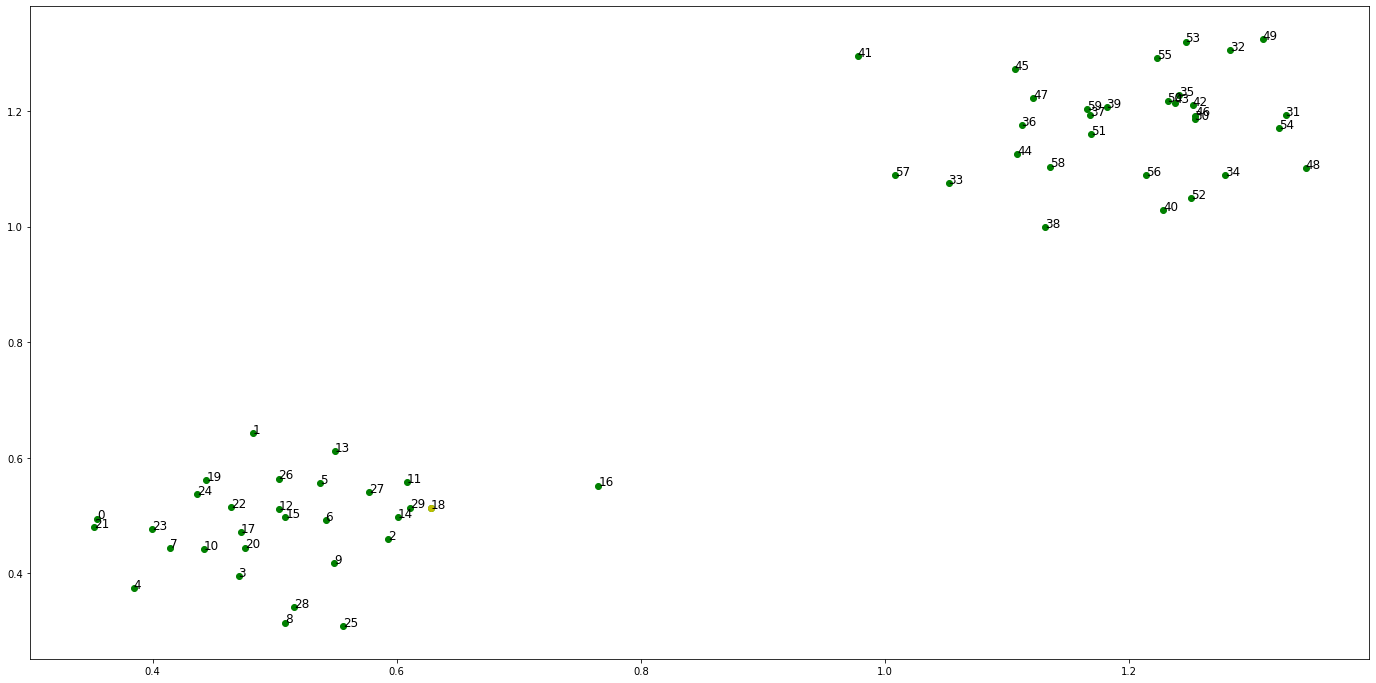

Index: 29.0
Reach dist: 0.0649359424759996

Index: 27.0
Reach dist: 0.06758475593165797

Index: 11.0
Reach dist: 0.0676804816994267

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.1768095320888161

Index: 57.0
Reach dist: 0.9569995030146297

Index: 33.0
Reach dist: 0.9877900993057673

Index: 38.0
Reach dist: 0.9900258216352458

Index: 44.0
Reach dist: 1.0934634505198393

Index: 58.0
Reach dist: 1.0987870467008816

Index: 40.0
Reach dist: 1.1161773856612085

Index: 41.0
Reach dist: 1.132243436892319

Index: 36.0
Reach dist: 1.1468711570451522

Index: 52.0
Reach dist: 1.1599664087909625

Index: 56.0
Reach dist: 1.162

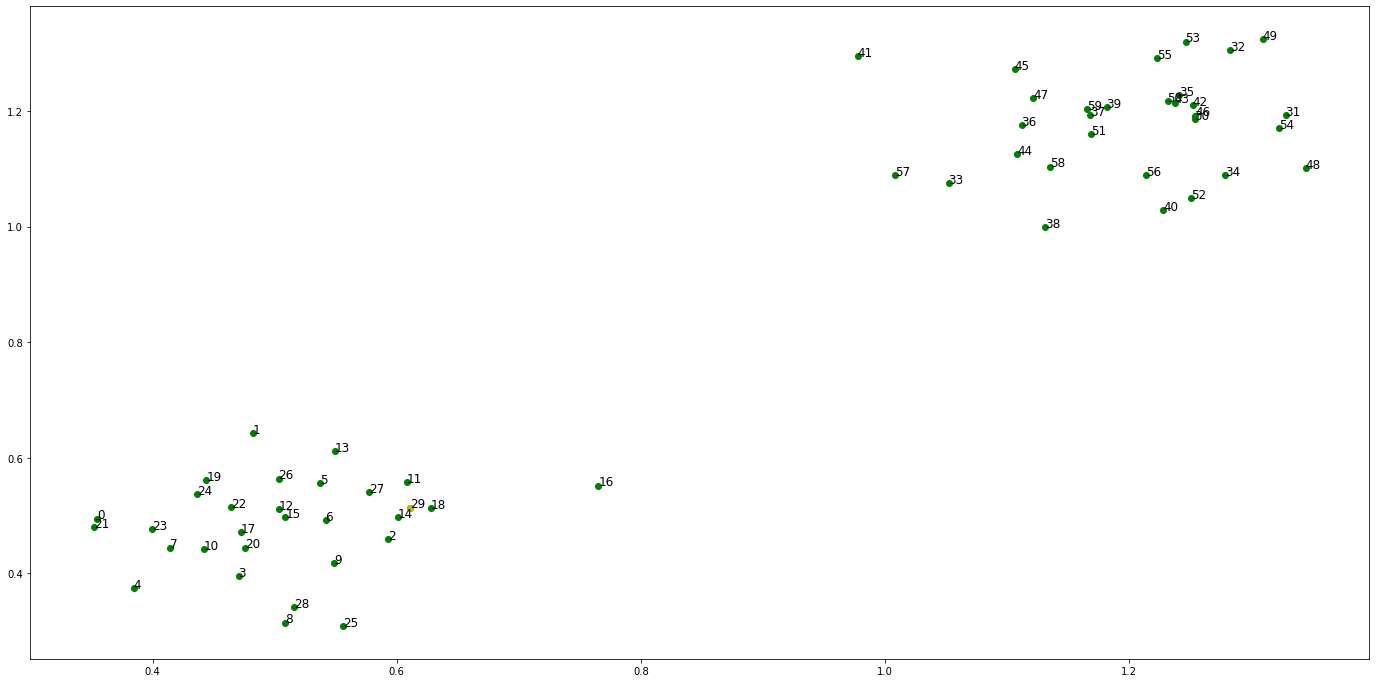

Index: 11.0
Reach dist: 0.06080658532791172

Index: 27.0
Reach dist: 0.06080658532791172

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 25.0
Reach dist: 0.17235847122968173

Index: 16.0
Reach dist: 0.1768095320888161

Index: 57.0
Reach dist: 0.9569995030146297

Index: 33.0
Reach dist: 0.9877900993057673

Index: 38.0
Reach dist: 0.9900258216352458

Index: 44.0
Reach dist: 1.0934634505198393

Index: 58.0
Reach dist: 1.0987870467008816

Index: 40.0
Reach dist: 1.1161773856612085

Index: 41.0
Reach dist: 1.132243436892319

Index: 36.0
Reach dist: 1.1468711570451522

Index: 52.0
Reach dist: 1.1599664087909625

Index: 56.0
Reach dist: 1.1628295490726128

Index: 51.0
Reach dist: 1.18

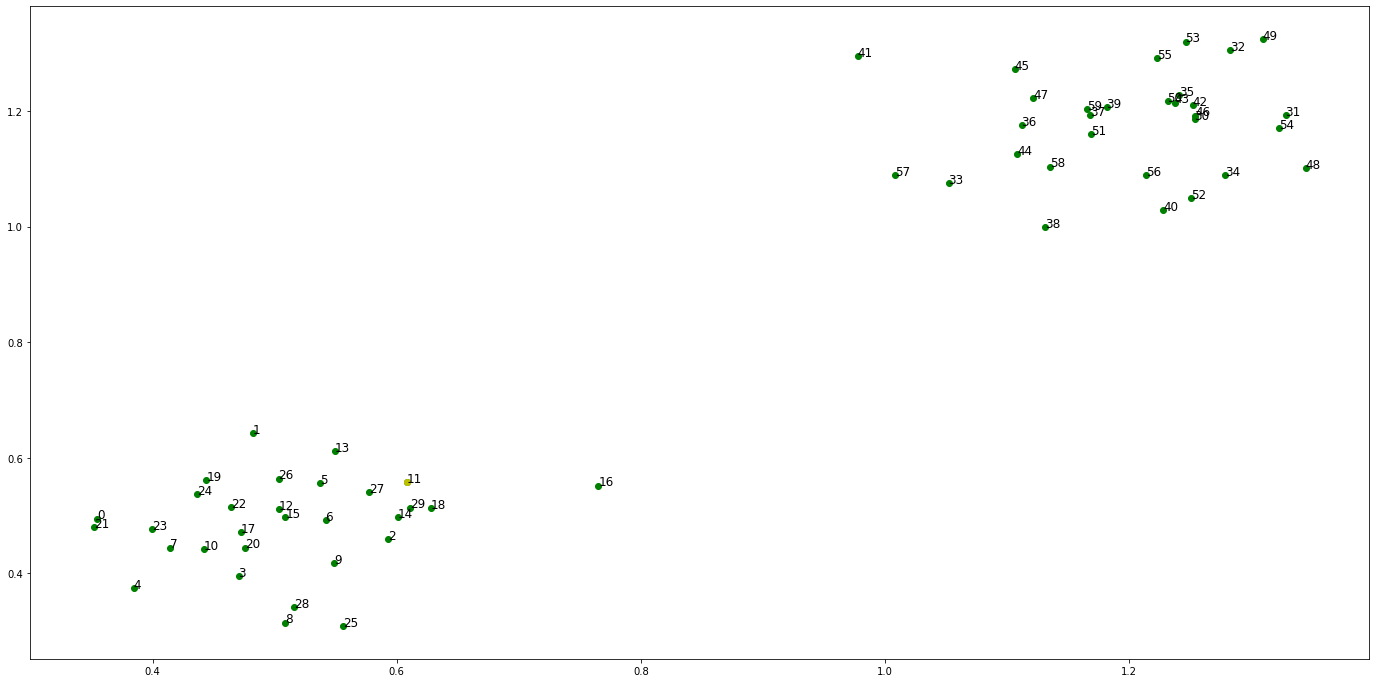

Index: 27.0
Reach dist: 0.06080658532791172

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 25.0
Reach dist: 0.17235847122968173

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.178

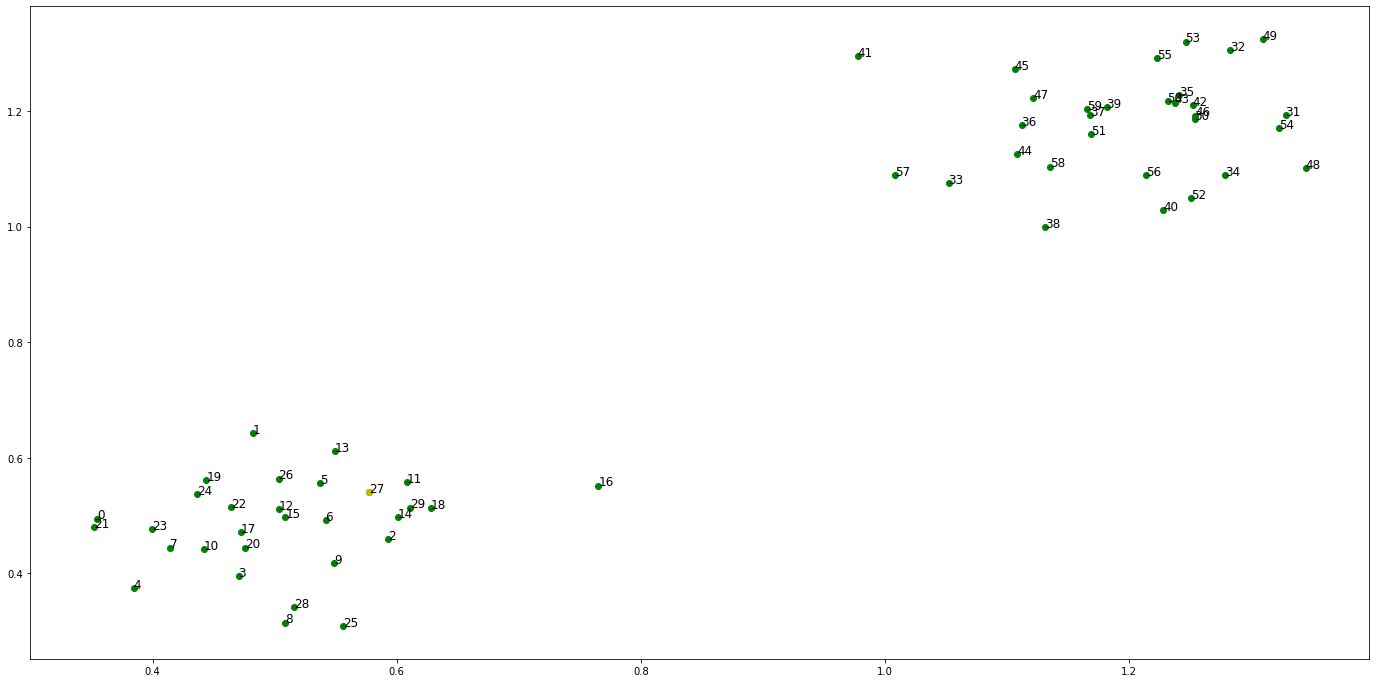

Index: 13.0
Reach dist: 0.06952834403285835

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09898740494700431

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 25.0
Reach dist: 0.17235847122968173

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.1953

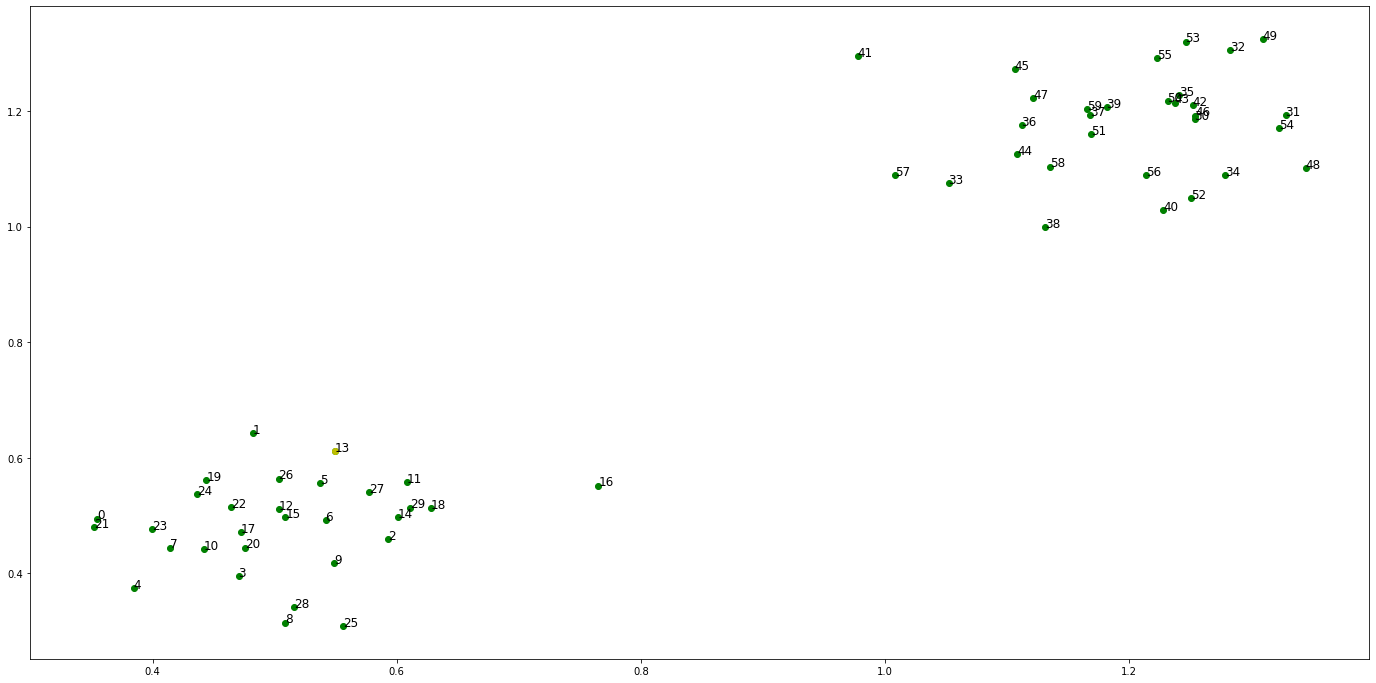

Index: 23.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 21.0
Reach dist: 0.09691052223357755

Index: 1.0
Reach dist: 0.09841735694627796

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 25.0
Reach dist: 0.17235847122968173

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796

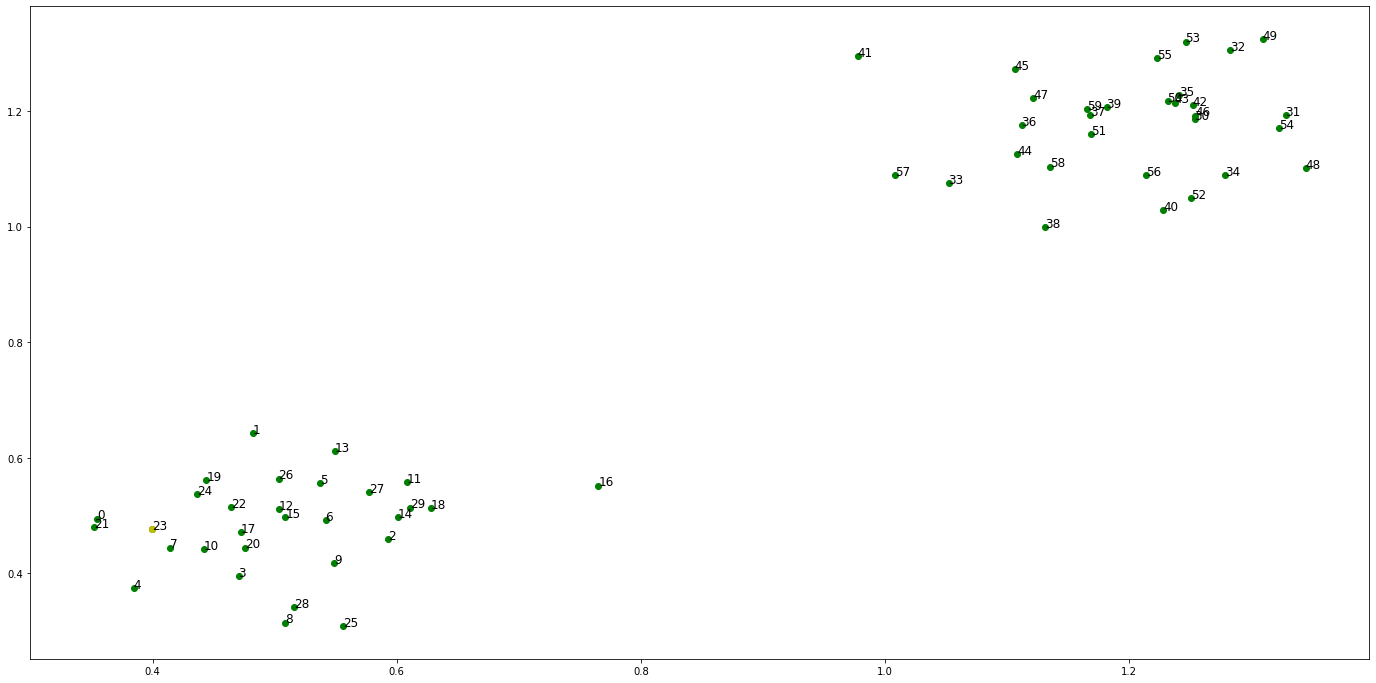

Index: 21.0
Reach dist: 0.0775915495413621

Index: 9.0
Reach dist: 0.0809274085692459

Index: 1.0
Reach dist: 0.09841735694627796

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 25.0
Reach dist: 0.17235847122968173

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.20354701

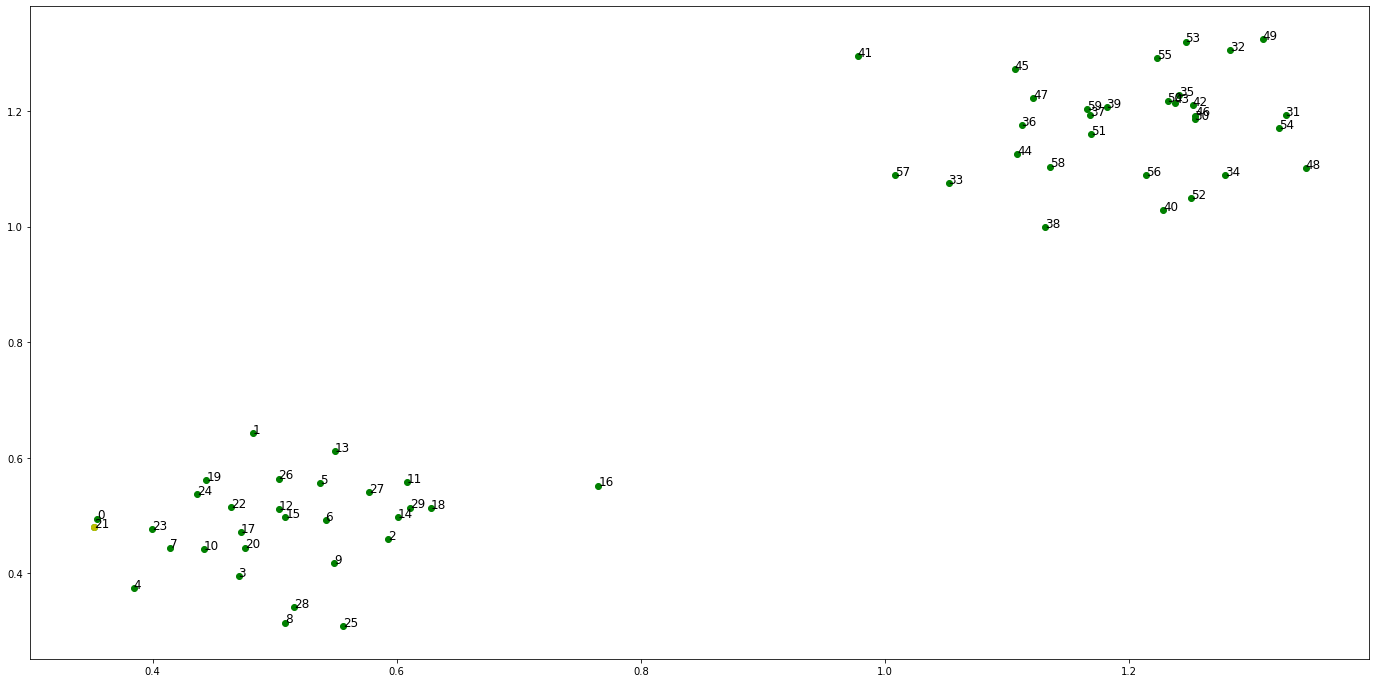

Index: 9.0
Reach dist: 0.0809274085692459

Index: 1.0
Reach dist: 0.09841735694627796

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 25.0
Reach dist: 0.17235847122968173

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.21252691

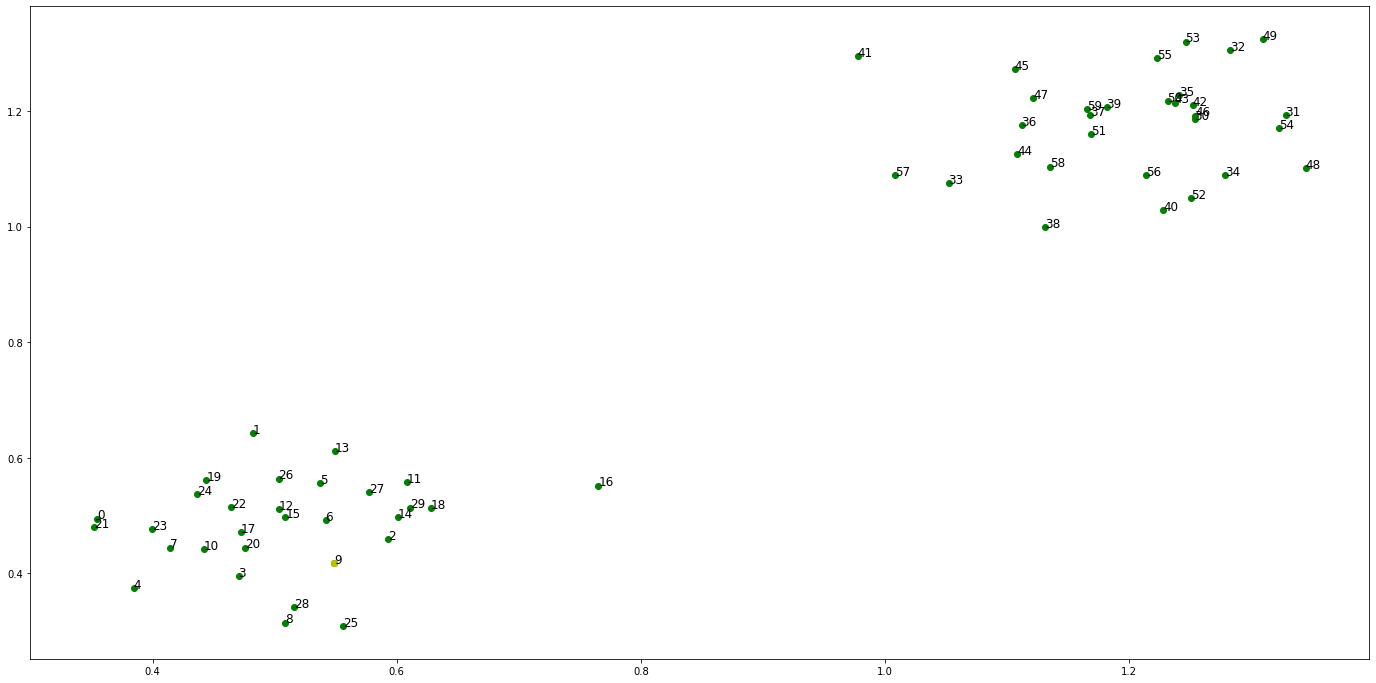

Index: 1.0
Reach dist: 0.09841735694627796

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 25.0
Reach dist: 0.11629431061349826

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197

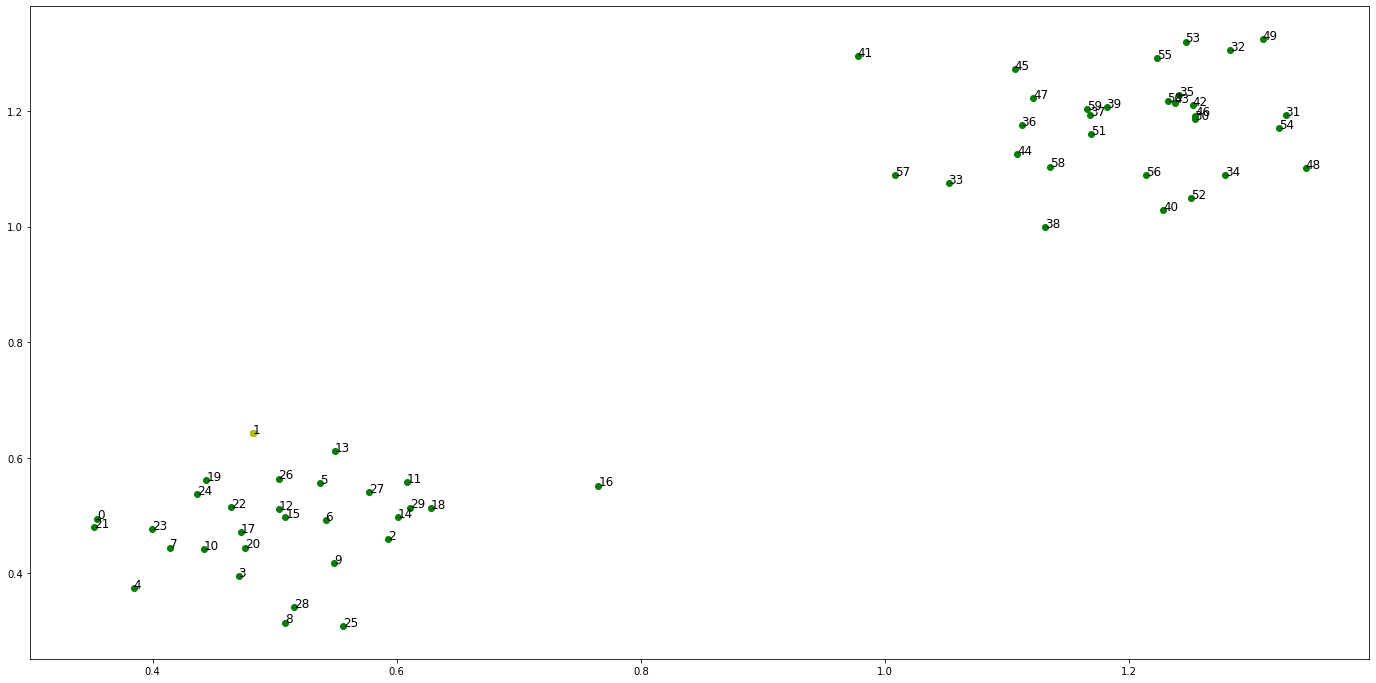

Index: 28.0
Reach dist: 0.09898964398775906

Index: 4.0
Reach dist: 0.10007011391716736

Index: 25.0
Reach dist: 0.11629431061349826

Index: 8.0
Reach dist: 0.11910990129911497

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197900854763

Index: 30.0
Reach dist: 1.2739306

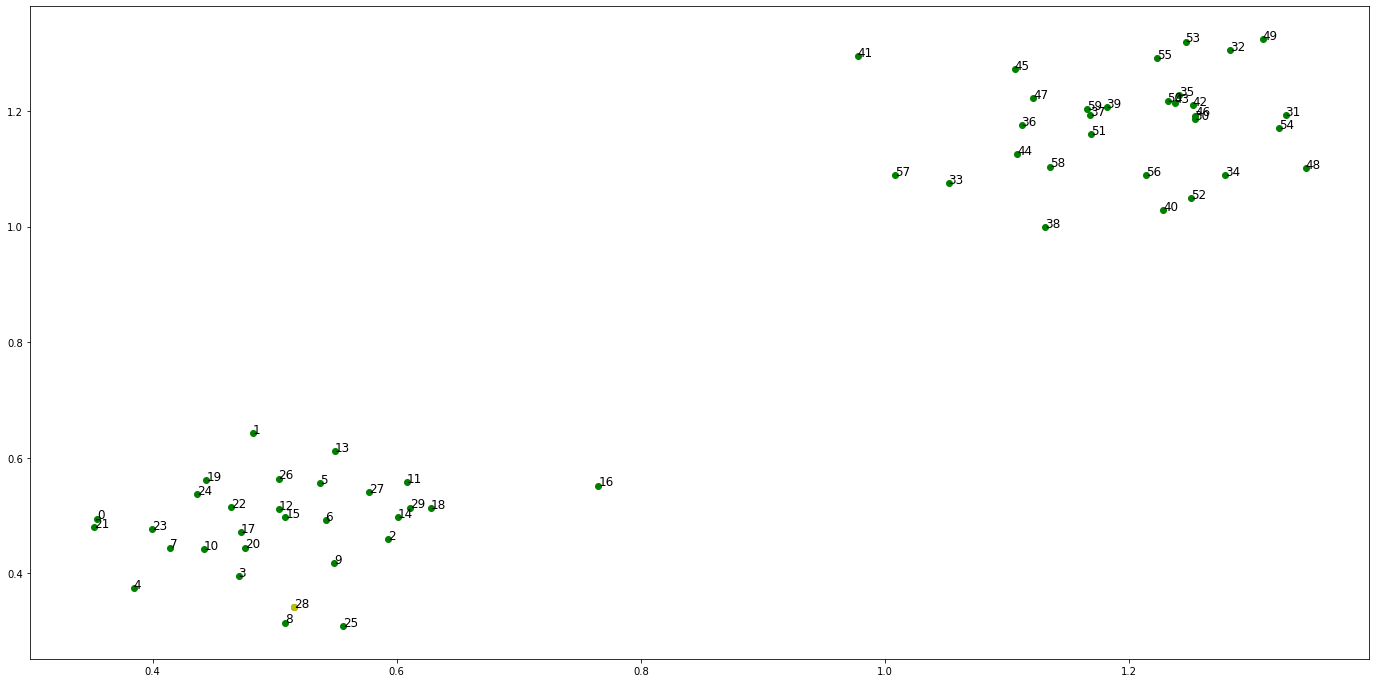

Index: 4.0
Reach dist: 0.10007011391716736

Index: 8.0
Reach dist: 0.10891251799507812

Index: 25.0
Reach dist: 0.10891251799507812

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197900854763

Index: 30.0
Reach dist: 1.2739306595175548

Index: 48.0
Reach dist: 1.27975685

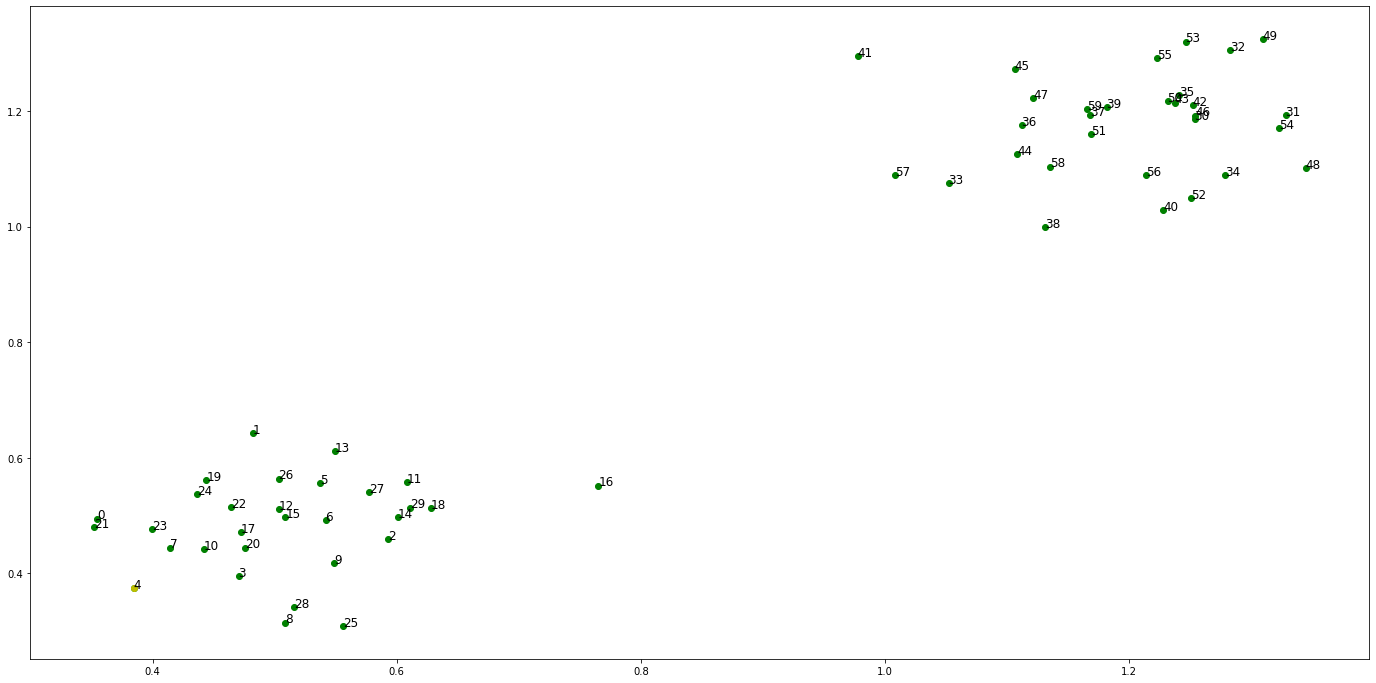

Index: 8.0
Reach dist: 0.10891251799507812

Index: 25.0
Reach dist: 0.10891251799507812

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197900854763

Index: 30.0
Reach dist: 1.2739306595175548

Index: 48.0
Reach dist: 1.2797568535140091

Index: 46.0
Reach dist: 1.28042853

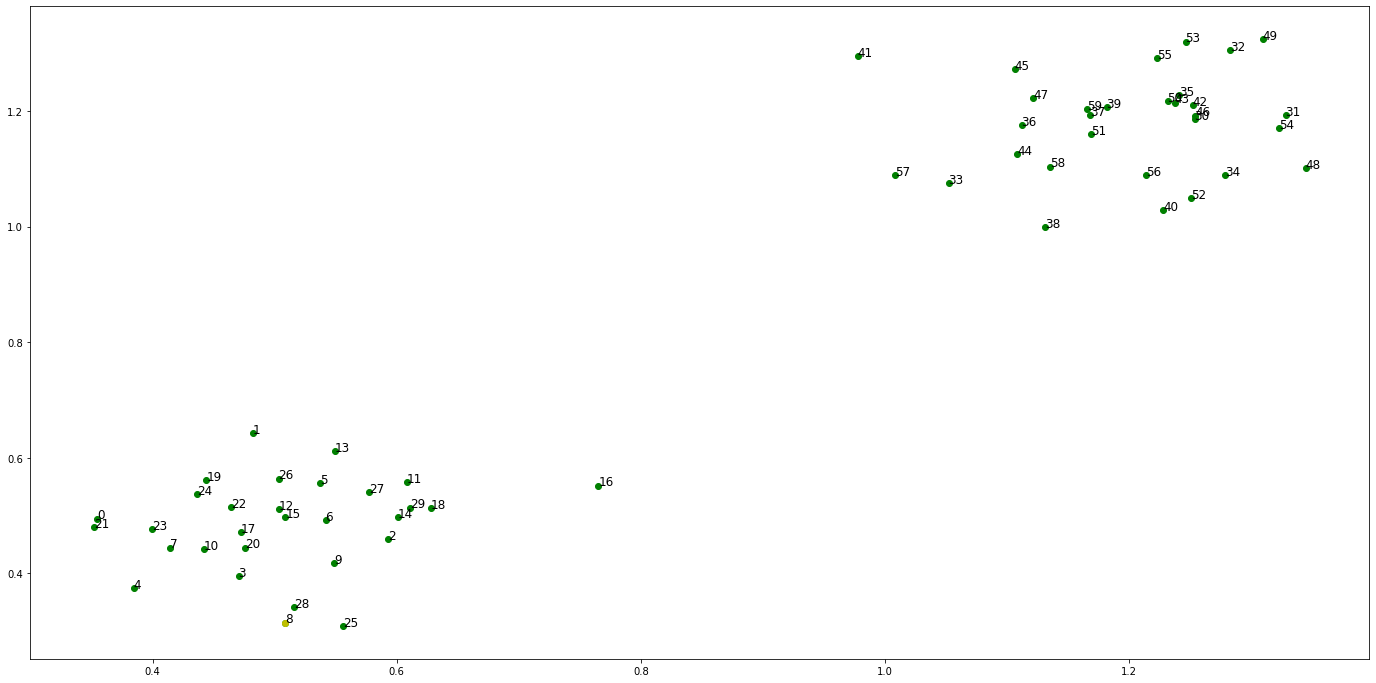

Index: 25.0
Reach dist: 0.10891251799507812

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197900854763

Index: 30.0
Reach dist: 1.2739306595175548

Index: 48.0
Reach dist: 1.2797568535140091

Index: 46.0
Reach dist: 1.2804285333699363

Index: 50.0
Reach dist: 1.28283125

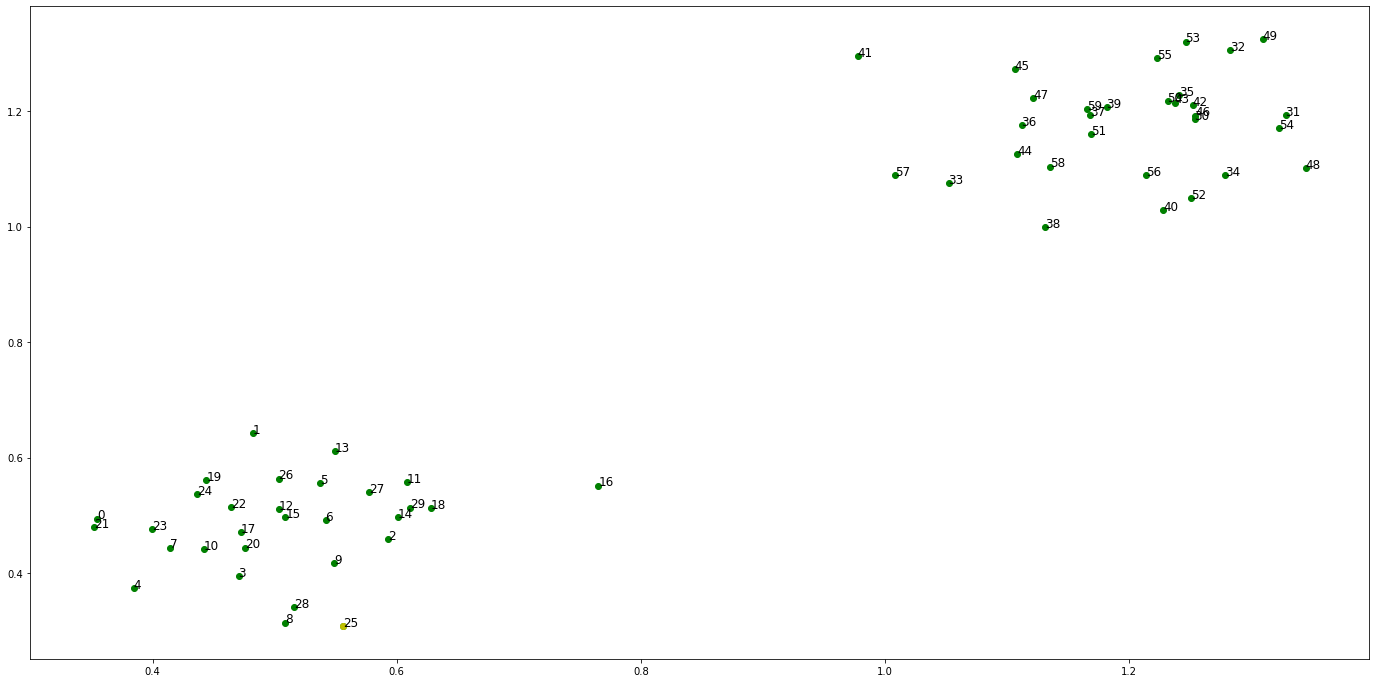

Index: 16.0
Reach dist: 0.16246378409005835

Index: 57.0
Reach dist: 0.9315069083420146

Index: 33.0
Reach dist: 0.9622975046331522

Index: 38.0
Reach dist: 0.9645332269626307

Index: 44.0
Reach dist: 1.067970855847224

Index: 58.0
Reach dist: 1.0732944520282666

Index: 40.0
Reach dist: 1.0906847909885933

Index: 41.0
Reach dist: 1.1067508422197039

Index: 36.0
Reach dist: 1.121378562372537

Index: 52.0
Reach dist: 1.1344738141183472

Index: 56.0
Reach dist: 1.1373369543999976

Index: 51.0
Reach dist: 1.1636434164046494

Index: 47.0
Reach dist: 1.1781943205828704

Index: 37.0
Reach dist: 1.195305315107332

Index: 34.0
Reach dist: 1.202796718343226

Index: 59.0
Reach dist: 1.2035470105418047

Index: 45.0
Reach dist: 1.2125269170714899

Index: 39.0
Reach dist: 1.2227197900854763

Index: 30.0
Reach dist: 1.2739306595175548

Index: 48.0
Reach dist: 1.2797568535140091

Index: 46.0
Reach dist: 1.2804285333699363

Index: 50.0
Reach dist: 1.2828312522838514

Index: 43.0
Reach dist: 1.286345375

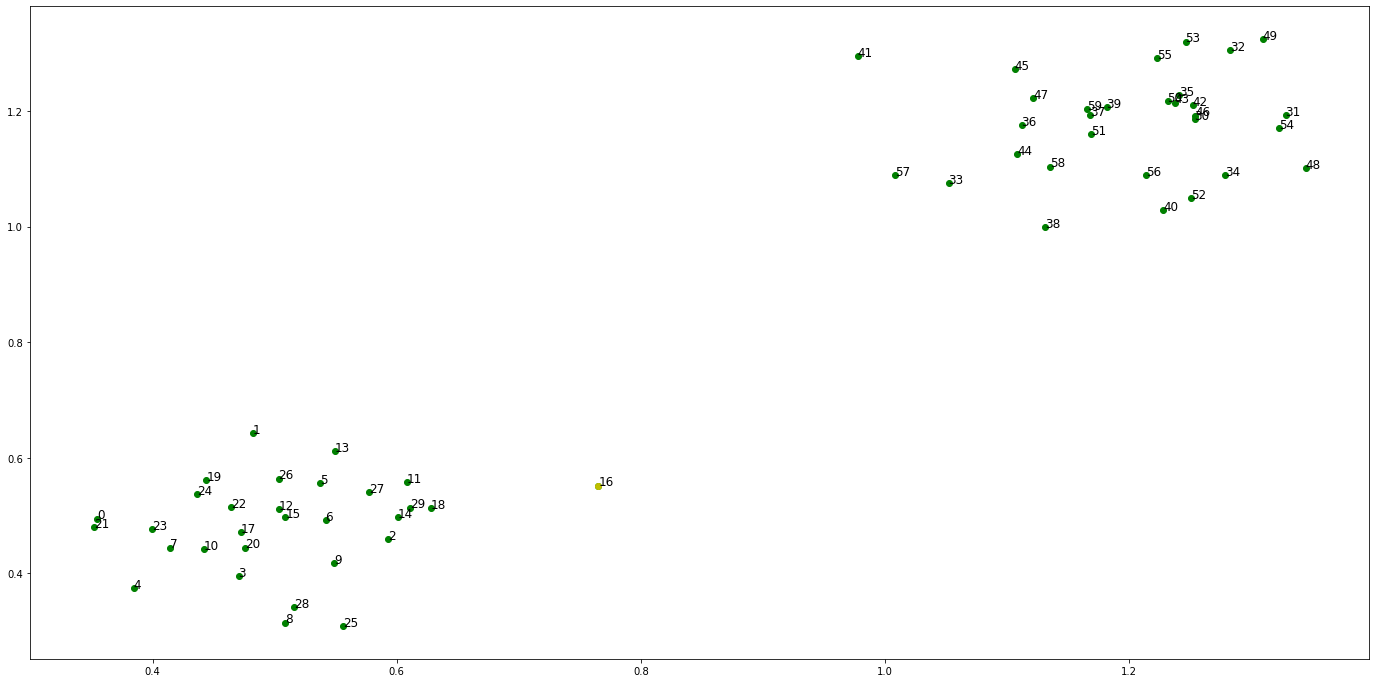

Index: 57.0
Reach dist: 0.7801899709258135

Index: 33.0
Reach dist: 0.8109805672169512

Index: 38.0
Reach dist: 0.8132162895464297

Index: 44.0
Reach dist: 0.9166539184310232

Index: 58.0
Reach dist: 0.9219775146120655

Index: 40.0
Reach dist: 0.9393678535723924

Index: 41.0
Reach dist: 0.9554339048035029

Index: 36.0
Reach dist: 0.9700616249563361

Index: 52.0
Reach dist: 0.9831568767021464

Index: 56.0
Reach dist: 0.9860200169837967

Index: 51.0
Reach dist: 1.0123264789884483

Index: 47.0
Reach dist: 1.0268773831666695

Index: 37.0
Reach dist: 1.0439883776911312

Index: 34.0
Reach dist: 1.051479780927025

Index: 59.0
Reach dist: 1.0522300731256038

Index: 45.0
Reach dist: 1.061209979655289

Index: 39.0
Reach dist: 1.0714028526692752

Index: 30.0
Reach dist: 1.1226137221013537

Index: 48.0
Reach dist: 1.128439916097808

Index: 46.0
Reach dist: 1.1291115959537352

Index: 50.0
Reach dist: 1.1315143148676503

Index: 43.0
Reach dist: 1.1350284376384407

Index: 42.0
Reach dist: 1.145090137

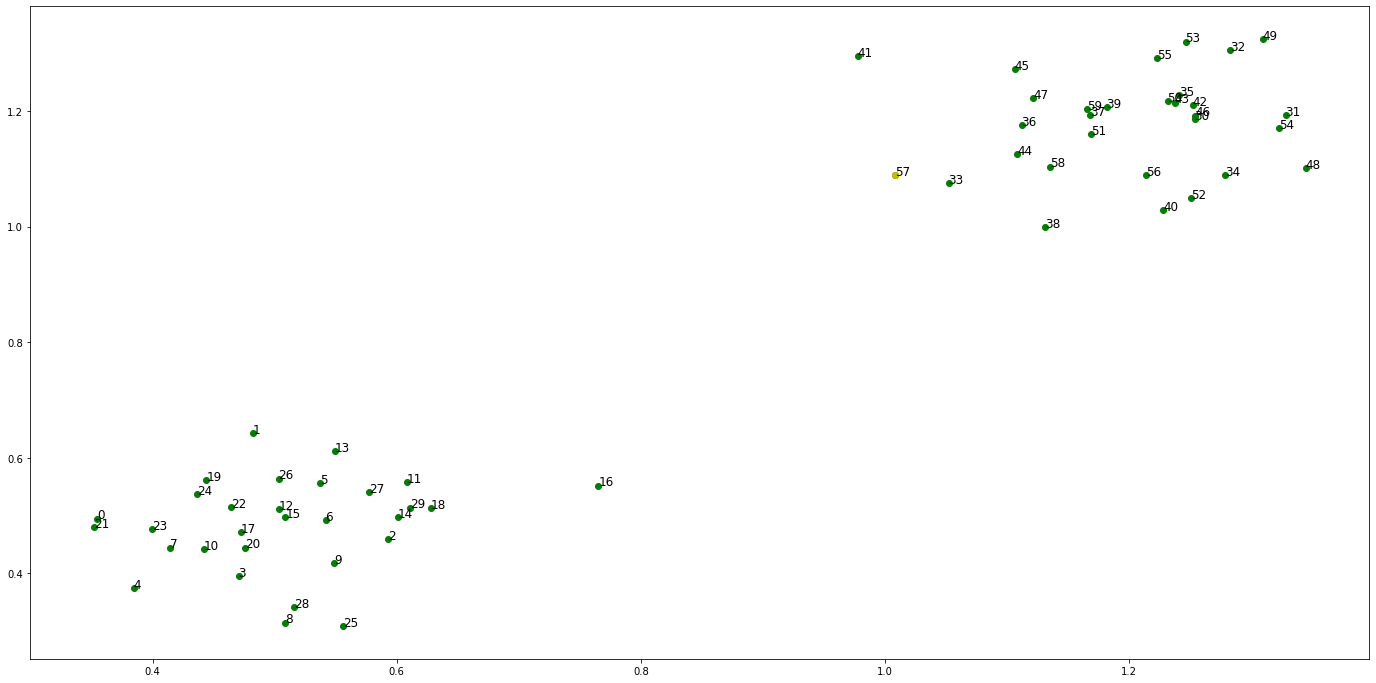

Index: 33.0
Reach dist: 0.18987165403052253

Index: 44.0
Reach dist: 0.18987165403052253

Index: 36.0
Reach dist: 0.18987165403052253

Index: 58.0
Reach dist: 0.18987165403052253

Index: 56.0
Reach dist: 0.2064095585809962

Index: 38.0
Reach dist: 0.2130065099589613

Index: 51.0
Reach dist: 0.23213650806263475

Index: 41.0
Reach dist: 0.23634682037845167

Index: 47.0
Reach dist: 0.246687412240856

Index: 37.0
Reach dist: 0.26379840676531763

Index: 34.0
Reach dist: 0.27128981000121155

Index: 59.0
Reach dist: 0.27204010219979025

Index: 40.0
Reach dist: 0.28036968963526276

Index: 45.0
Reach dist: 0.2810200087294754

Index: 52.0
Reach dist: 0.2818471991294762

Index: 39.0
Reach dist: 0.2912128817434616

Index: 30.0
Reach dist: 0.34242375117554014

Index: 48.0
Reach dist: 0.3482499451719945

Index: 46.0
Reach dist: 0.3489216250279217

Index: 50.0
Reach dist: 0.35132434394183676

Index: 43.0
Reach dist: 0.3548384667126272

Index: 42.0
Reach dist: 0.36490016678846393

Index: 35.0
Reach di

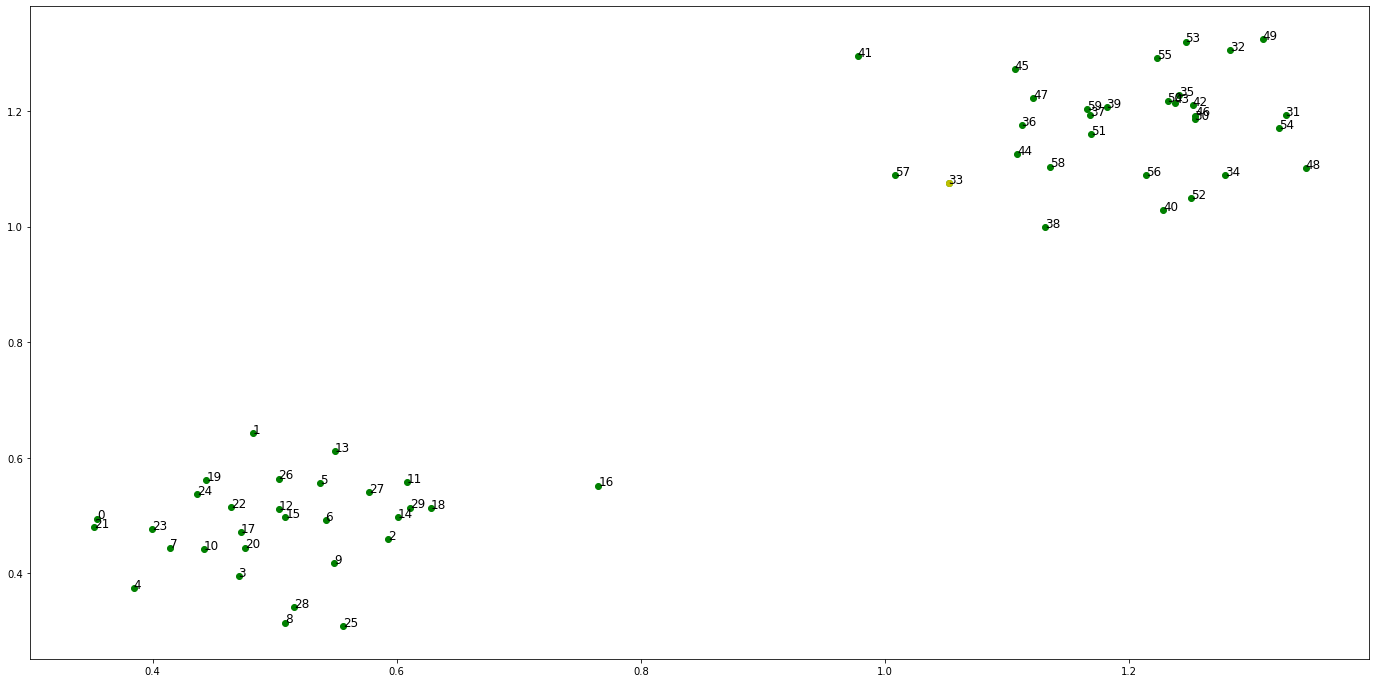

Index: 38.0
Reach dist: 0.15569964465166986

Index: 44.0
Reach dist: 0.15569964465166986

Index: 58.0
Reach dist: 0.15569964465166986

Index: 36.0
Reach dist: 0.15908105773938486

Index: 56.0
Reach dist: 0.1750394497668455

Index: 51.0
Reach dist: 0.20134591177149708

Index: 47.0
Reach dist: 0.21589681594971832

Index: 40.0
Reach dist: 0.2230628243279713

Index: 52.0
Reach dist: 0.22454033382218475

Index: 37.0
Reach dist: 0.23300781047417995

Index: 41.0
Reach dist: 0.23634682037845167

Index: 34.0
Reach dist: 0.24049921371007388

Index: 59.0
Reach dist: 0.24124950590865257

Index: 45.0
Reach dist: 0.25022941243833774

Index: 39.0
Reach dist: 0.26042228545232393

Index: 30.0
Reach dist: 0.31163315488440246

Index: 48.0
Reach dist: 0.3174593488808568

Index: 46.0
Reach dist: 0.318131028736784

Index: 50.0
Reach dist: 0.3205337476506991

Index: 43.0
Reach dist: 0.3240478704214895

Index: 42.0
Reach dist: 0.33410957049732626

Index: 35.0
Reach dist: 0.3404120626413576

Index: 54.0
Reach 

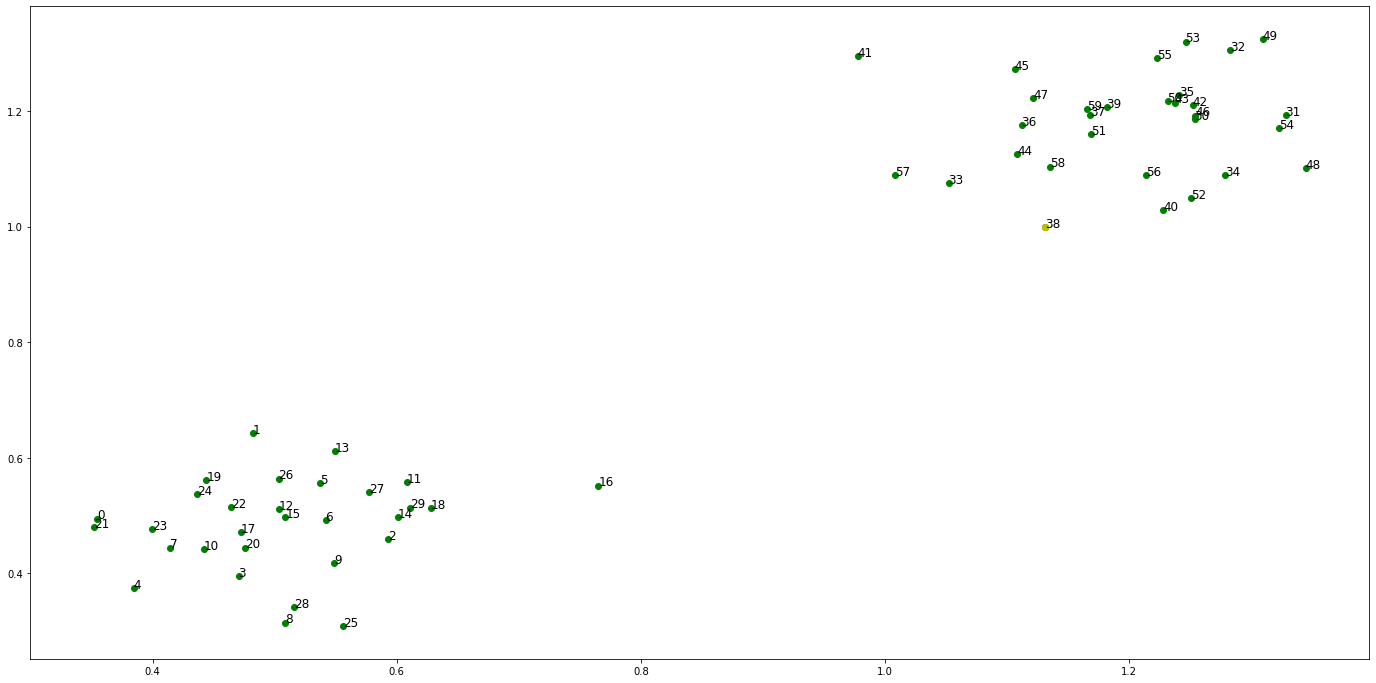

Index: 44.0
Reach dist: 0.15569964465166986

Index: 58.0
Reach dist: 0.15569964465166986

Index: 40.0
Reach dist: 0.15569964465166986

Index: 36.0
Reach dist: 0.15908105773938486

Index: 52.0
Reach dist: 0.1699405871557167

Index: 56.0
Reach dist: 0.17280372743736705

Index: 51.0
Reach dist: 0.19911018944201864

Index: 47.0
Reach dist: 0.21589681594971832

Index: 37.0
Reach dist: 0.23077208814470151

Index: 41.0
Reach dist: 0.23634682037845167

Index: 34.0
Reach dist: 0.23826349138059544

Index: 59.0
Reach dist: 0.23901378357917413

Index: 45.0
Reach dist: 0.25022941243833774

Index: 39.0
Reach dist: 0.2581865631228455

Index: 30.0
Reach dist: 0.309397432554924

Index: 48.0
Reach dist: 0.31522362655137837

Index: 46.0
Reach dist: 0.31589530640730556

Index: 50.0
Reach dist: 0.31829802532122065

Index: 43.0
Reach dist: 0.3218121480920111

Index: 42.0
Reach dist: 0.3318738481678478

Index: 35.0
Reach dist: 0.33817634031187915

Index: 54.0
Reach dist: 0.36278692325623974

Index: 55.0
Reac

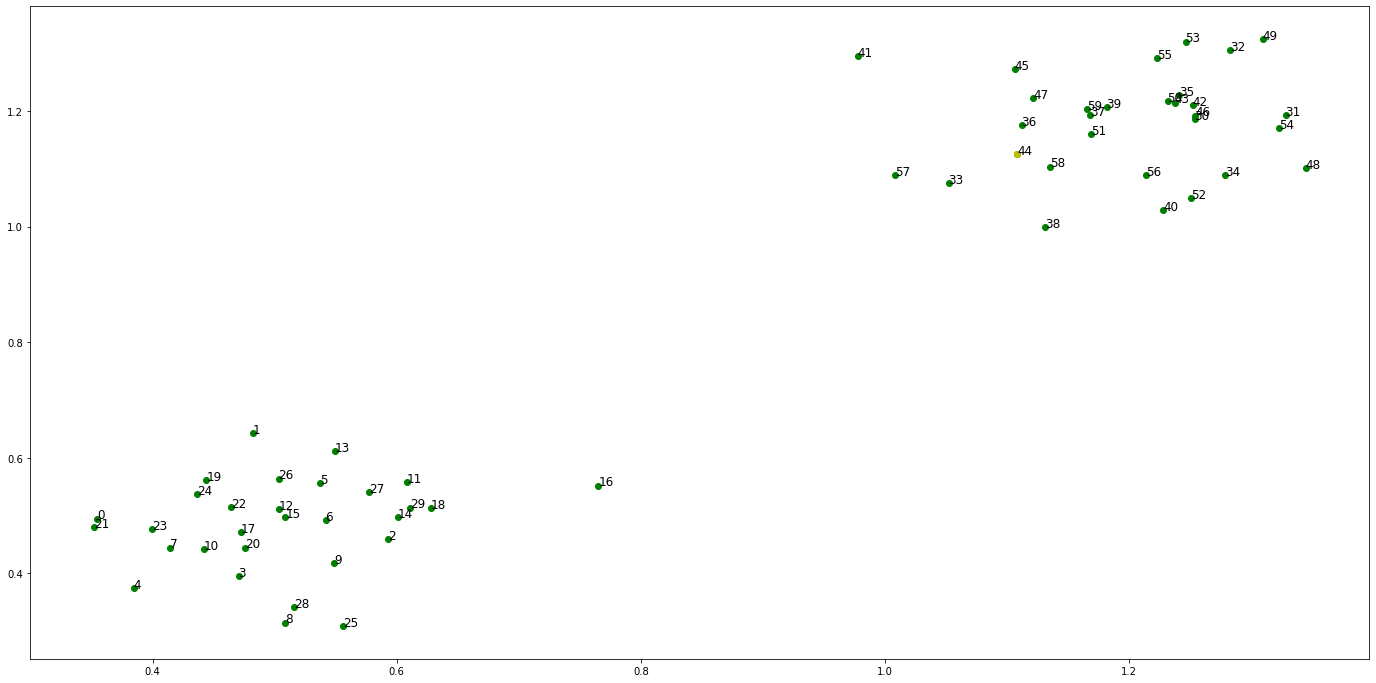

Index: 36.0
Reach dist: 0.10567335121407195

Index: 51.0
Reach dist: 0.10567335121407195

Index: 58.0
Reach dist: 0.10567335121407195

Index: 47.0
Reach dist: 0.11022346473564637

Index: 37.0
Reach dist: 0.127334459260108

Index: 59.0
Reach dist: 0.13557615469458062

Index: 56.0
Reach dist: 0.14240381274771474

Index: 45.0
Reach dist: 0.1488159190439453

Index: 39.0
Reach dist: 0.15474893423825198

Index: 40.0
Reach dist: 0.15569964465166986

Index: 52.0
Reach dist: 0.1699405871557167

Index: 30.0
Reach dist: 0.2059598036703305

Index: 34.0
Reach dist: 0.20656696547184383

Index: 46.0
Reach dist: 0.21245767752271205

Index: 50.0
Reach dist: 0.21486039643662713

Index: 43.0
Reach dist: 0.21837451920741757

Index: 42.0
Reach dist: 0.2284362192832543

Index: 35.0
Reach dist: 0.23473871142728564

Index: 41.0
Reach dist: 0.23634682037845167

Index: 54.0
Reach dist: 0.2593492943716462

Index: 48.0
Reach dist: 0.2608252980264776

Index: 55.0
Reach dist: 0.281330852472778

Index: 31.0
Reach di

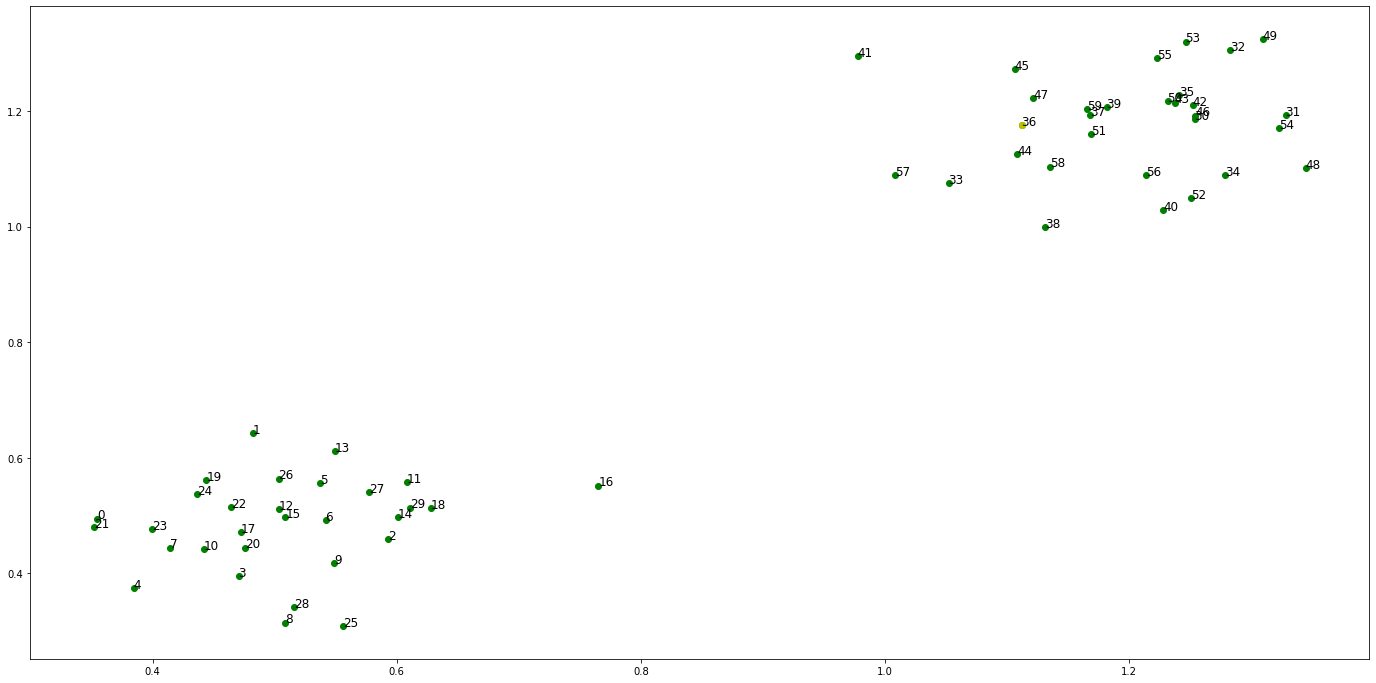

Index: 37.0
Reach dist: 0.0739267527347951

Index: 47.0
Reach dist: 0.0739267527347951

Index: 51.0
Reach dist: 0.0739267527347951

Index: 59.0
Reach dist: 0.08216844816926772

Index: 58.0
Reach dist: 0.09477192718046079

Index: 39.0
Reach dist: 0.10134122771293907

Index: 45.0
Reach dist: 0.10263489701199502

Index: 56.0
Reach dist: 0.14240381274771474

Index: 30.0
Reach dist: 0.1525520971450176

Index: 40.0
Reach dist: 0.15569964465166986

Index: 46.0
Reach dist: 0.15904997099739915

Index: 50.0
Reach dist: 0.16145268991131423

Index: 43.0
Reach dist: 0.16496681268210467

Index: 52.0
Reach dist: 0.1699405871557167

Index: 42.0
Reach dist: 0.1750285127579414

Index: 35.0
Reach dist: 0.18133100490197274

Index: 34.0
Reach dist: 0.20656696547184383

Index: 54.0
Reach dist: 0.21655465755760317

Index: 55.0
Reach dist: 0.2279231459474651

Index: 31.0
Reach dist: 0.2343270400679789

Index: 41.0
Reach dist: 0.23634682037845167

Index: 48.0
Reach dist: 0.2608252980264776

Index: 53.0
Reach d

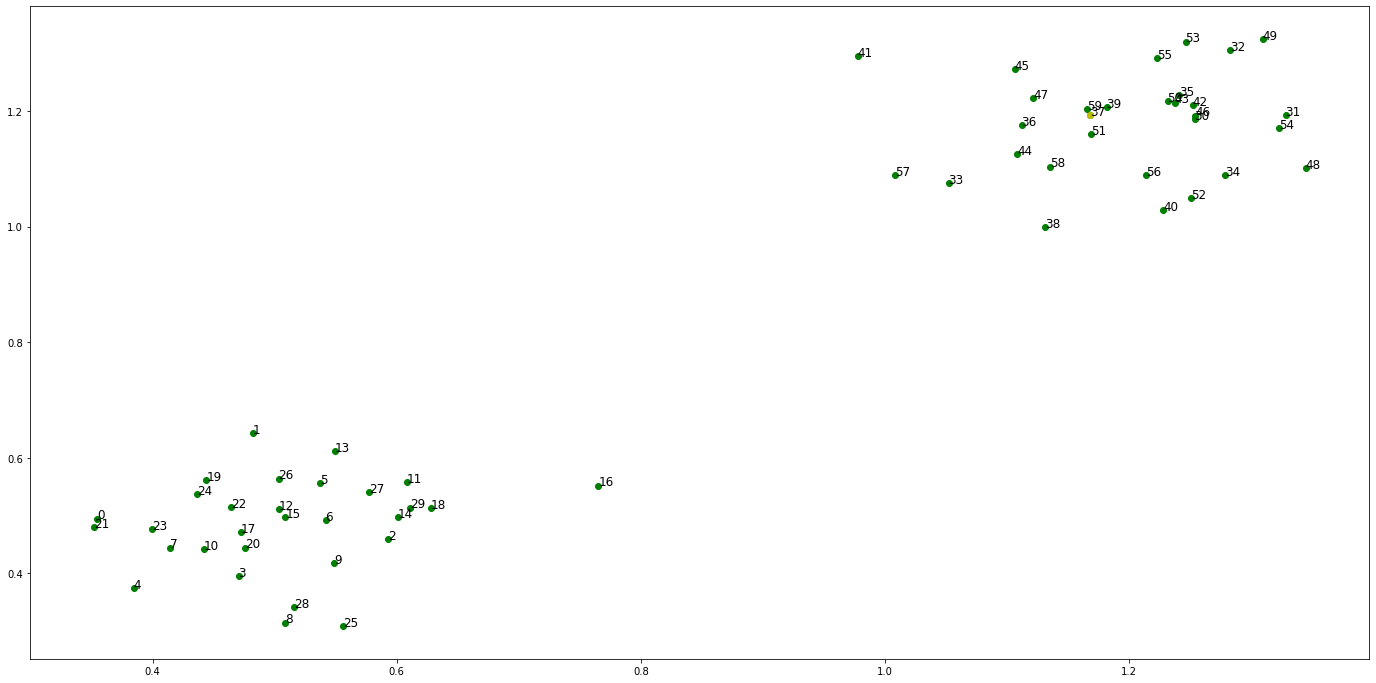

Index: 47.0
Reach dist: 0.0739267527347951

Index: 51.0
Reach dist: 0.0739267527347951

Index: 39.0
Reach dist: 0.0739267527347951

Index: 59.0
Reach dist: 0.0739267527347951

Index: 46.0
Reach dist: 0.08700281498676499

Index: 50.0
Reach dist: 0.08752593717651913

Index: 43.0
Reach dist: 0.09104005994730957

Index: 30.0
Reach dist: 0.09272588024468198

Index: 58.0
Reach dist: 0.09477192718046079

Index: 42.0
Reach dist: 0.1011017600231463

Index: 45.0
Reach dist: 0.10263489701199502

Index: 35.0
Reach dist: 0.10740425216717764

Index: 56.0
Reach dist: 0.14240381274771474

Index: 55.0
Reach dist: 0.15399639321267

Index: 40.0
Reach dist: 0.15569964465166986

Index: 31.0
Reach dist: 0.1604002873331838

Index: 52.0
Reach dist: 0.1699405871557167

Index: 54.0
Reach dist: 0.1783663534701121

Index: 53.0
Reach dist: 0.2056714809458251

Index: 34.0
Reach dist: 0.20656696547184383

Index: 32.0
Reach dist: 0.22747000062553502

Index: 41.0
Reach dist: 0.23634682037845167

Index: 48.0
Reach dist

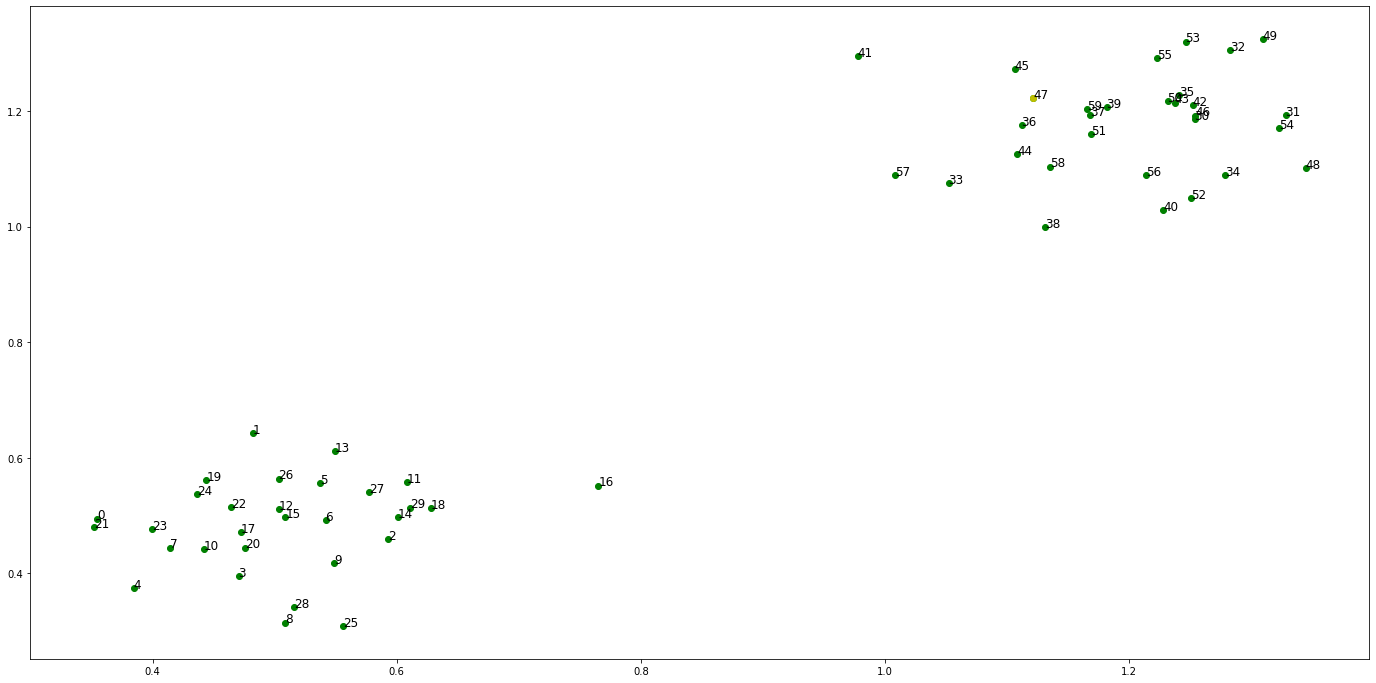

Index: 51.0
Reach dist: 0.0739267527347951

Index: 39.0
Reach dist: 0.0739267527347951

Index: 59.0
Reach dist: 0.0739267527347951

Index: 45.0
Reach dist: 0.07542745388078465

Index: 46.0
Reach dist: 0.08700281498676499

Index: 50.0
Reach dist: 0.08752593717651913

Index: 43.0
Reach dist: 0.09104005994730957

Index: 30.0
Reach dist: 0.09272588024468198

Index: 58.0
Reach dist: 0.09477192718046079

Index: 42.0
Reach dist: 0.1011017600231463

Index: 35.0
Reach dist: 0.10740425216717764

Index: 56.0
Reach dist: 0.14240381274771474

Index: 55.0
Reach dist: 0.15399639321267

Index: 40.0
Reach dist: 0.15569964465166986

Index: 31.0
Reach dist: 0.1604002873331838

Index: 52.0
Reach dist: 0.1699405871557167

Index: 54.0
Reach dist: 0.1783663534701121

Index: 53.0
Reach dist: 0.2056714809458251

Index: 34.0
Reach dist: 0.20656696547184383

Index: 41.0
Reach dist: 0.2167851514533824

Index: 32.0
Reach dist: 0.22747000062553502

Index: 48.0
Reach dist: 0.2608252980264776

Index: 49.0
Reach dist:

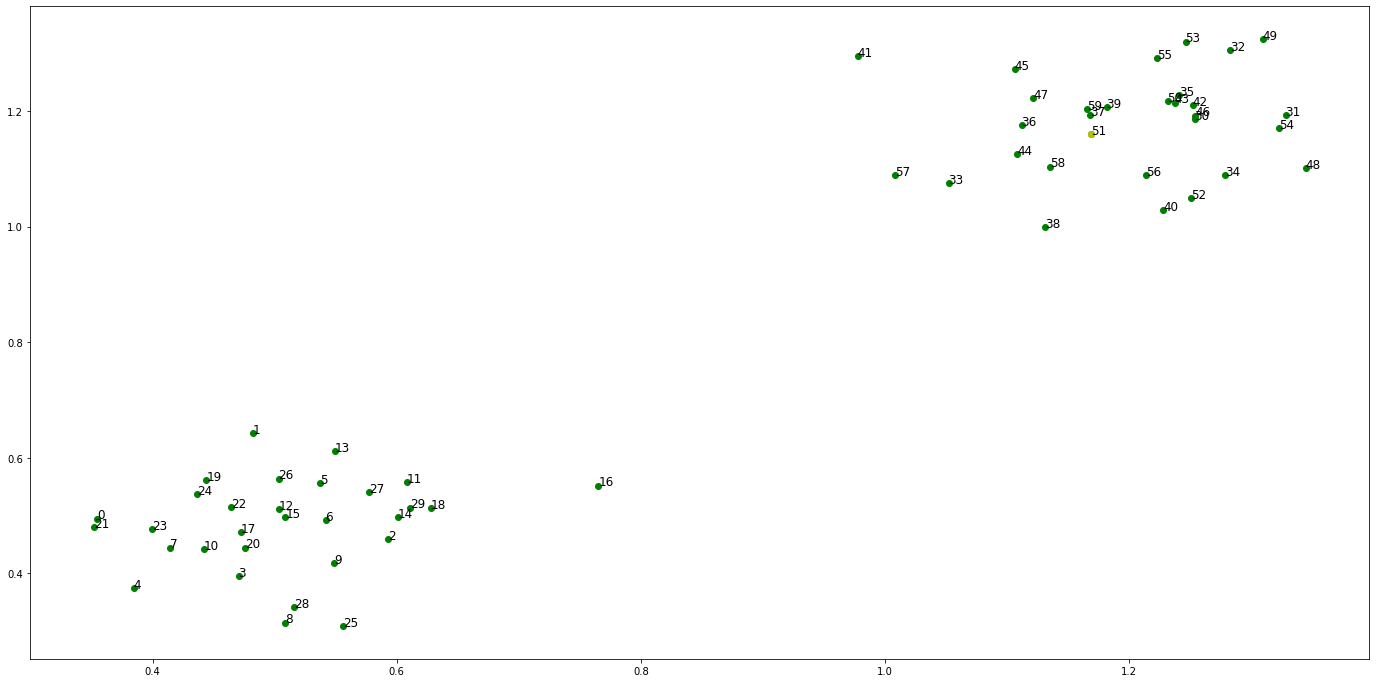

Index: 39.0
Reach dist: 0.07215375262413848

Index: 59.0
Reach dist: 0.07215375262413848

Index: 45.0
Reach dist: 0.07542745388078465

Index: 46.0
Reach dist: 0.08700281498676499

Index: 50.0
Reach dist: 0.08752593717651913

Index: 58.0
Reach dist: 0.09034896437638285

Index: 43.0
Reach dist: 0.09104005994730957

Index: 30.0
Reach dist: 0.09272588024468198

Index: 42.0
Reach dist: 0.1011017600231463

Index: 35.0
Reach dist: 0.10740425216717764

Index: 56.0
Reach dist: 0.11643108215552656

Index: 55.0
Reach dist: 0.15399639321267

Index: 40.0
Reach dist: 0.15569964465166986

Index: 31.0
Reach dist: 0.1604002873331838

Index: 54.0
Reach dist: 0.1636767338142211

Index: 52.0
Reach dist: 0.1699405871557167

Index: 34.0
Reach dist: 0.18059423487965565

Index: 53.0
Reach dist: 0.2056714809458251

Index: 41.0
Reach dist: 0.2167851514533824

Index: 32.0
Reach dist: 0.22747000062553502

Index: 48.0
Reach dist: 0.2348525674342894

Index: 49.0
Reach dist: 0.27310643087243536


[0, 7, 10, 3, 17, 1

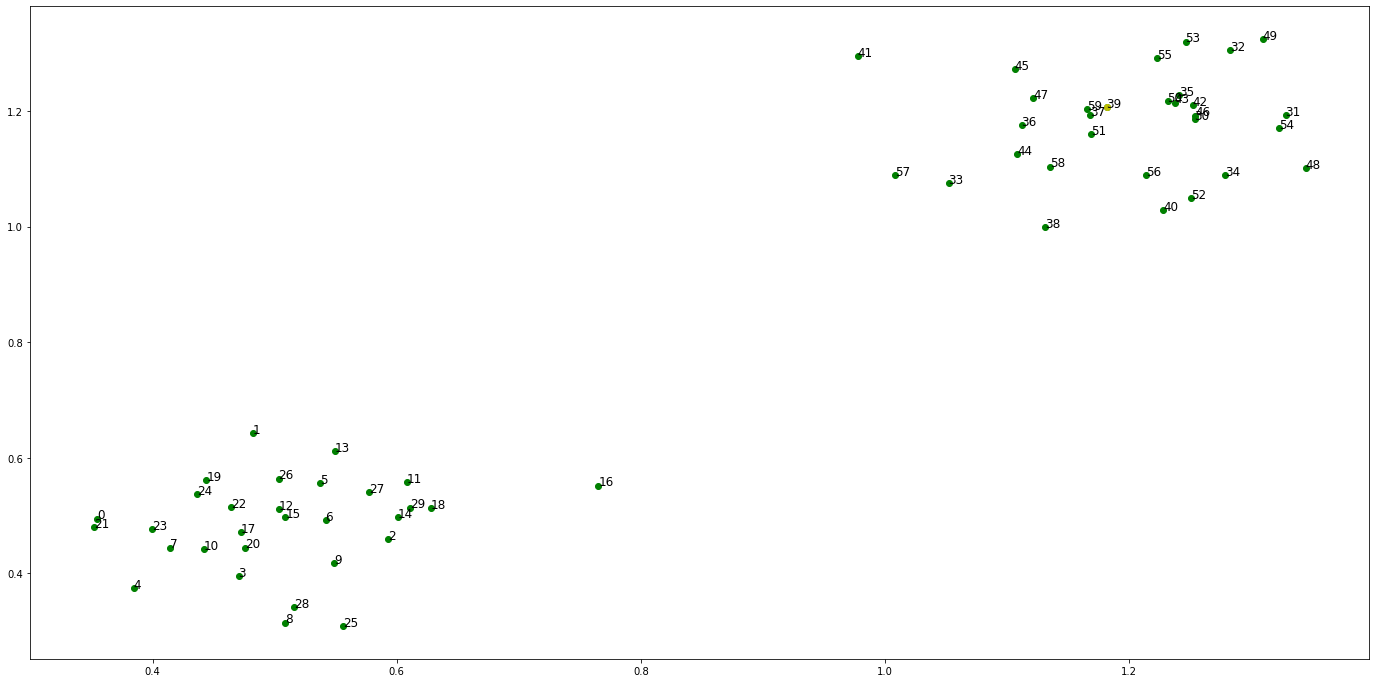

Index: 50.0
Reach dist: 0.060111462198375154

Index: 59.0
Reach dist: 0.060111462198375154

Index: 43.0
Reach dist: 0.0636255849691656

Index: 42.0
Reach dist: 0.07368728504500233

Index: 45.0
Reach dist: 0.07542745388078465

Index: 35.0
Reach dist: 0.07998977718903366

Index: 46.0
Reach dist: 0.08700281498676499

Index: 58.0
Reach dist: 0.09034896437638285

Index: 30.0
Reach dist: 0.09272588024468198

Index: 56.0
Reach dist: 0.11643108215552656

Index: 55.0
Reach dist: 0.12658191823452603

Index: 40.0
Reach dist: 0.15569964465166986

Index: 31.0
Reach dist: 0.16031239014300835

Index: 54.0
Reach dist: 0.1636767338142211

Index: 52.0
Reach dist: 0.1699405871557167

Index: 53.0
Reach dist: 0.17825700596768113

Index: 34.0
Reach dist: 0.18059423487965565

Index: 32.0
Reach dist: 0.20005552564739104

Index: 41.0
Reach dist: 0.2167851514533824

Index: 48.0
Reach dist: 0.2348525674342894

Index: 49.0
Reach dist: 0.24569195589429138


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2

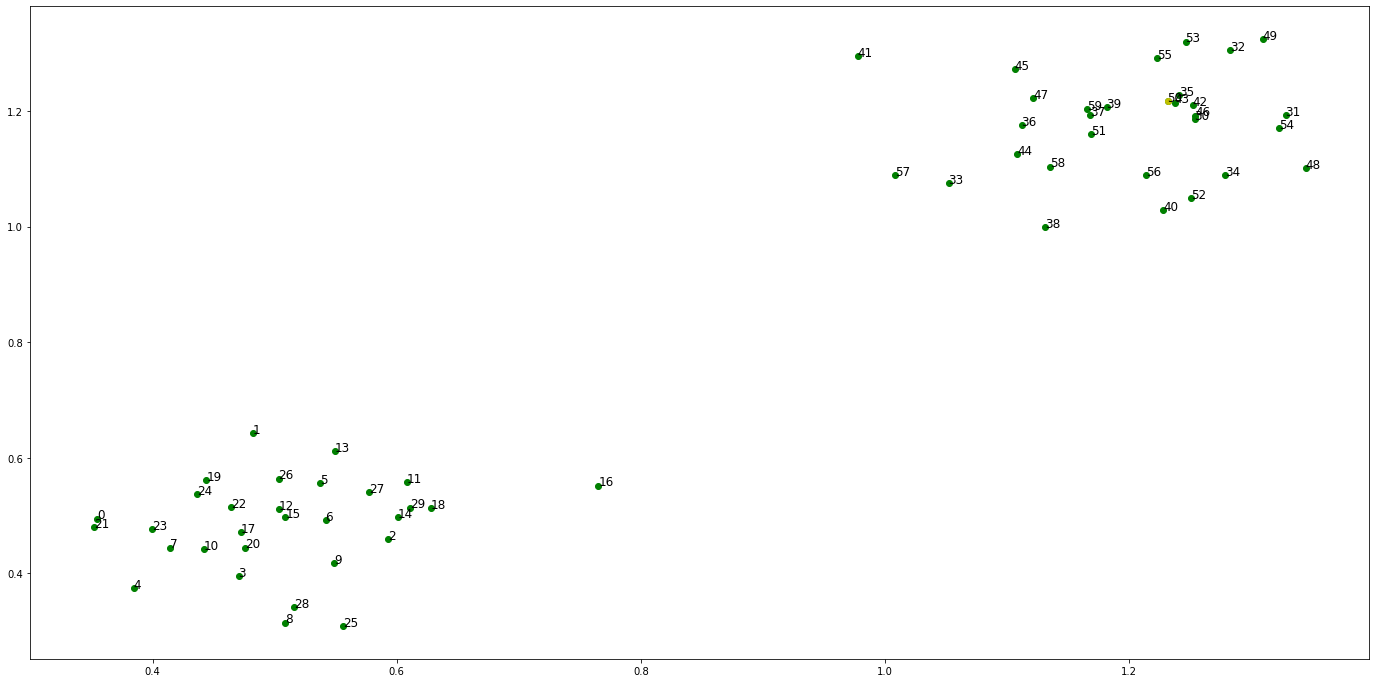

Index: 35.0
Reach dist: 0.04733771737200243

Index: 42.0
Reach dist: 0.04733771737200243

Index: 43.0
Reach dist: 0.04733771737200243

Index: 46.0
Reach dist: 0.04733771737200243

Index: 30.0
Reach dist: 0.05306078262991942

Index: 59.0
Reach dist: 0.060111462198375154

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08335095716930008

Index: 58.0
Reach dist: 0.09034896437638285

Index: 56.0
Reach dist: 0.11643108215552656

Index: 53.0
Reach dist: 0.11814554376930597

Index: 31.0
Reach dist: 0.12050004959513894

Index: 54.0
Reach dist: 0.13870125585534954

Index: 32.0
Reach dist: 0.1399440634490159

Index: 40.0
Reach dist: 0.15569964465166986

Index: 52.0
Reach dist: 0.1699405871557167

Index: 34.0
Reach dist: 0.1748945858015405

Index: 49.0
Reach dist: 0.18558049369591623

Index: 41.0
Reach dist: 0.2167851514533824

Index: 48.0
Reach dist: 0.22915291835617424


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8,

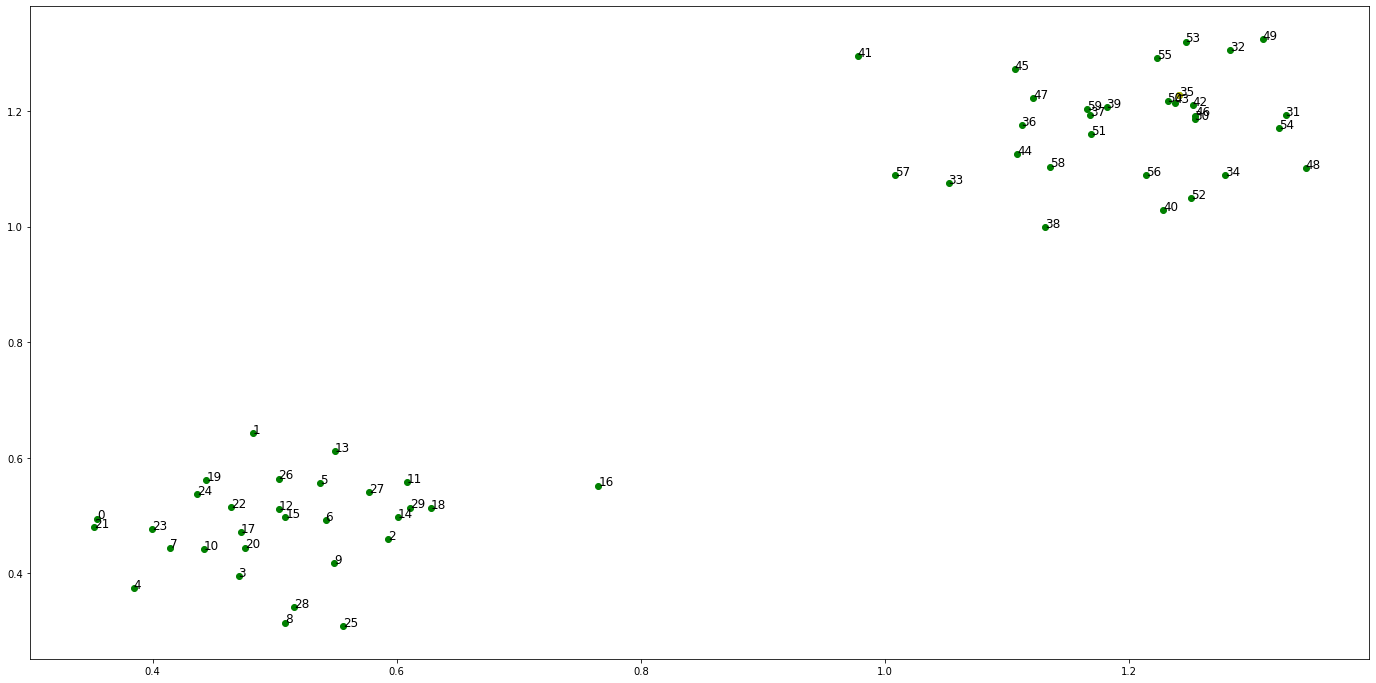

Index: 42.0
Reach dist: 0.04733771737200243

Index: 43.0
Reach dist: 0.04733771737200243

Index: 46.0
Reach dist: 0.04733771737200243

Index: 30.0
Reach dist: 0.05306078262991942

Index: 59.0
Reach dist: 0.060111462198375154

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08250461218009497

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 31.0
Reach dist: 0.12050004959513894

Index: 54.0
Reach dist: 0.13870125585534954

Index: 40.0
Reach dist: 0.15569964465166986

Index: 49.0
Reach dist: 0.16570217870525772

Index: 52.0
Reach dist: 0.1699405871557167

Index: 34.0
Reach dist: 0.1748945858015405

Index: 41.0
Reach dist: 0.2167851514533824

Index: 48.0
Reach dist: 0.22915291835617424


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39,

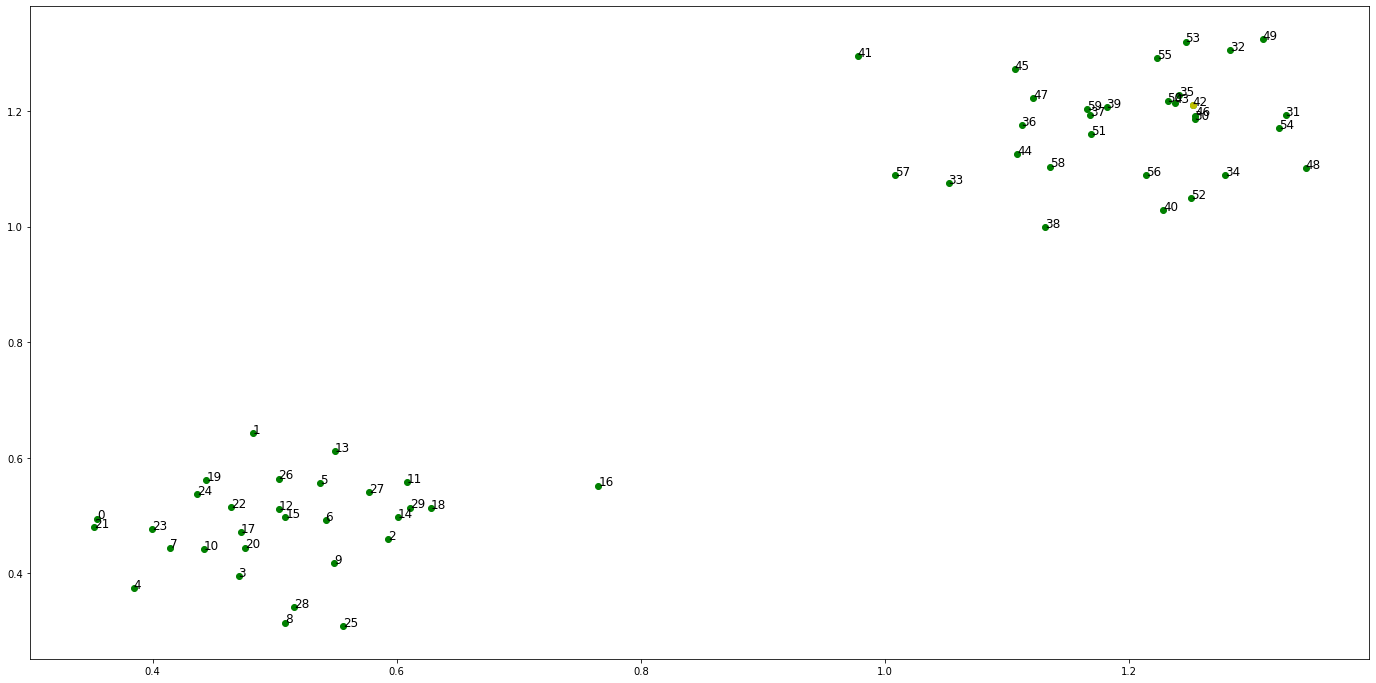

Index: 30.0
Reach dist: 0.027511499051864785

Index: 43.0
Reach dist: 0.027511499051864785

Index: 46.0
Reach dist: 0.027511499051864785

Index: 59.0
Reach dist: 0.060111462198375154

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08250461218009497

Index: 58.0
Reach dist: 0.09034896437638285

Index: 31.0
Reach dist: 0.09298855054327415

Index: 53.0
Reach dist: 0.09826722877864746

Index: 54.0
Reach dist: 0.11118975680348475

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.1473830867496757

Index: 40.0
Reach dist: 0.15569964465166986

Index: 52.0
Reach dist: 0.16193326101213112

Index: 49.0
Reach dist: 0.16570217870525772

Index: 48.0
Reach dist: 0.20164141930430945

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30]


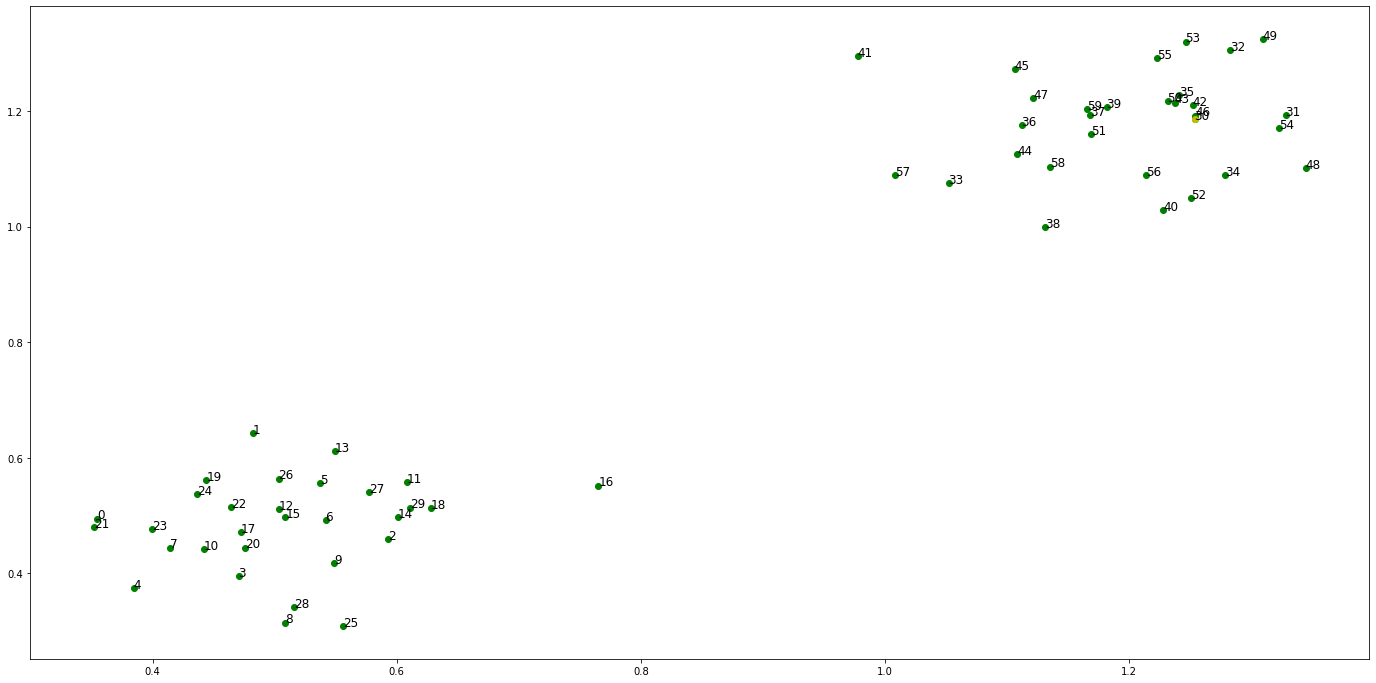

Index: 43.0
Reach dist: 0.027511499051864785

Index: 46.0
Reach dist: 0.027511499051864785

Index: 59.0
Reach dist: 0.060111462198375154

Index: 45.0
Reach dist: 0.07542745388078465

Index: 31.0
Reach dist: 0.08177494292296128

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 40.0
Reach dist: 0.15569964465166986

Index: 49.0
Reach dist: 0.16570217870525772

Index: 48.0
Reach dist: 0.17609213572625482

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43]


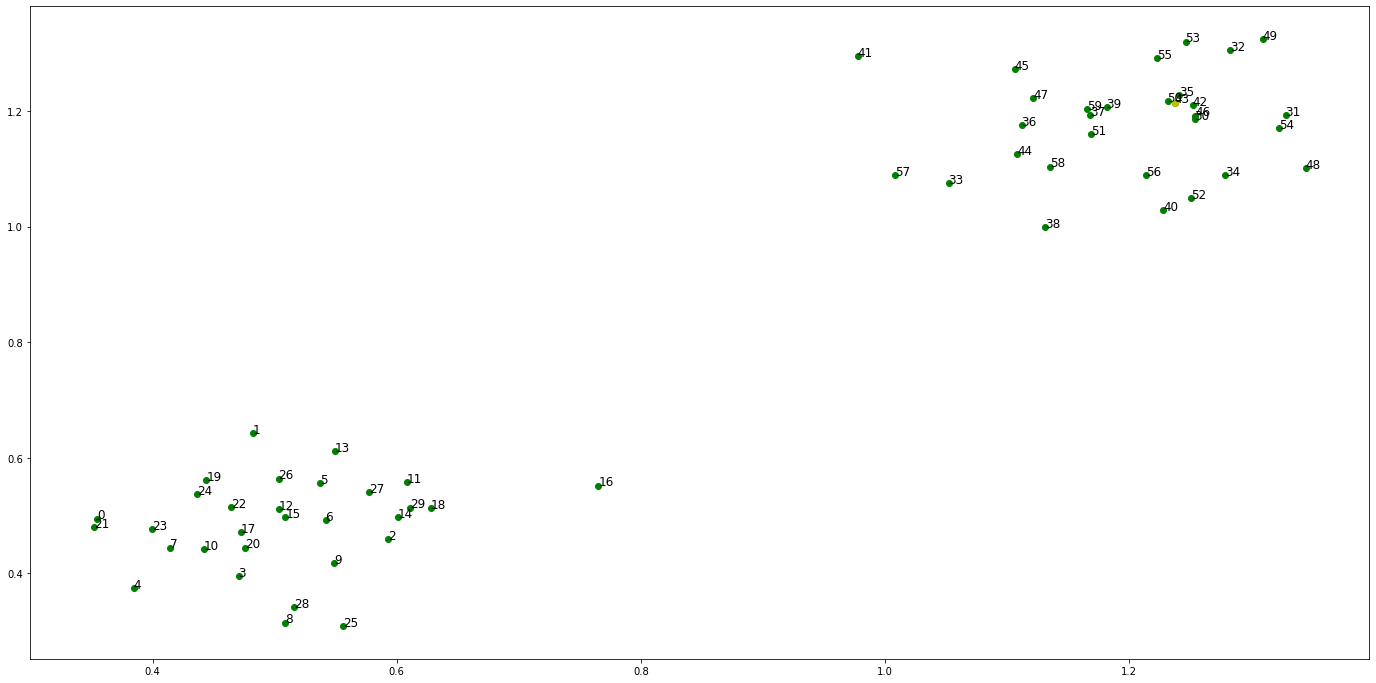

Index: 46.0
Reach dist: 0.027511499051864785

Index: 59.0
Reach dist: 0.060111462198375154

Index: 45.0
Reach dist: 0.07542745388078465

Index: 31.0
Reach dist: 0.08177494292296128

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 40.0
Reach dist: 0.15569964465166986

Index: 49.0
Reach dist: 0.16570217870525772

Index: 48.0
Reach dist: 0.17609213572625482

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46]


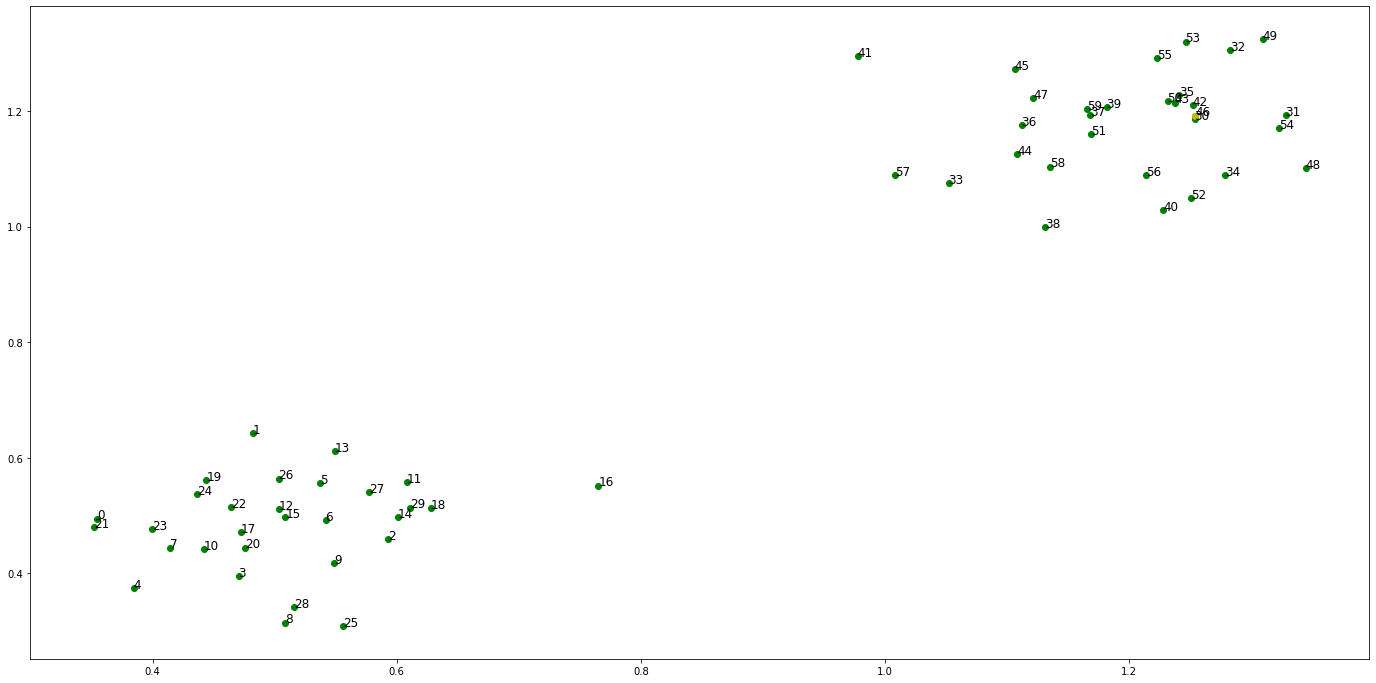

Index: 59.0
Reach dist: 0.060111462198375154

Index: 31.0
Reach dist: 0.07527706907057974

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 40.0
Reach dist: 0.15569964465166986

Index: 49.0
Reach dist: 0.16570217870525772

Index: 48.0
Reach dist: 0.17609213572625482

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59]


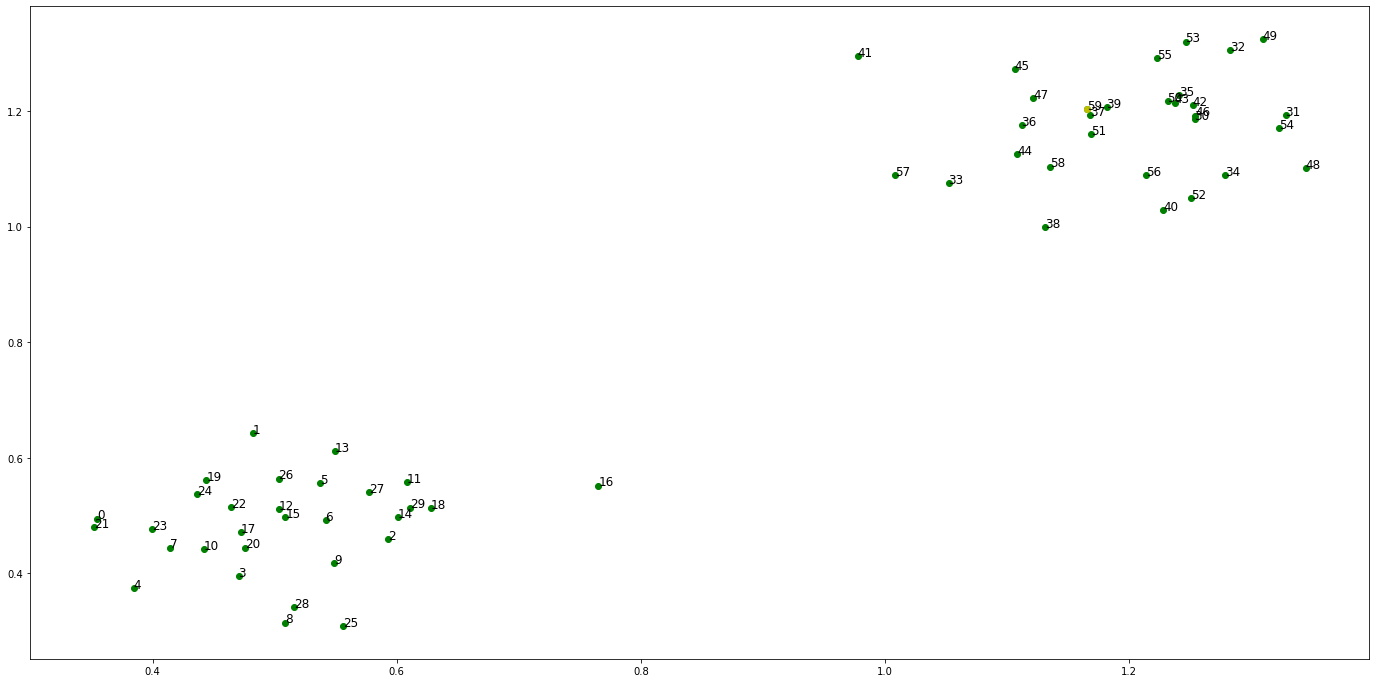

Index: 31.0
Reach dist: 0.07527706907057974

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 40.0
Reach dist: 0.15569964465166986

Index: 49.0
Reach dist: 0.16570217870525772

Index: 48.0
Reach dist: 0.17609213572625482

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31]


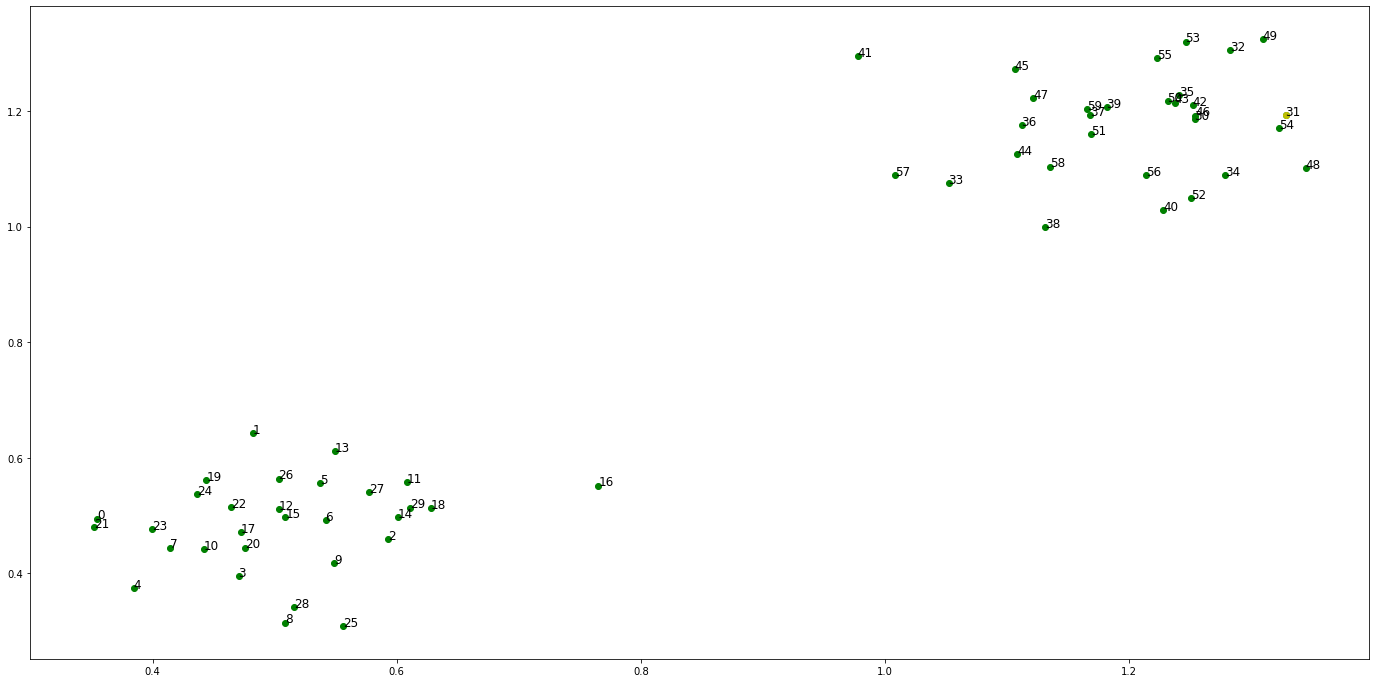

Index: 45.0
Reach dist: 0.07542745388078465

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 48.0
Reach dist: 0.1086528687610353

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 49.0
Reach dist: 0.15000035635926934

Index: 40.0
Reach dist: 0.15569964465166986

Index: 41.0
Reach dist: 0.2167851514533824


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45]


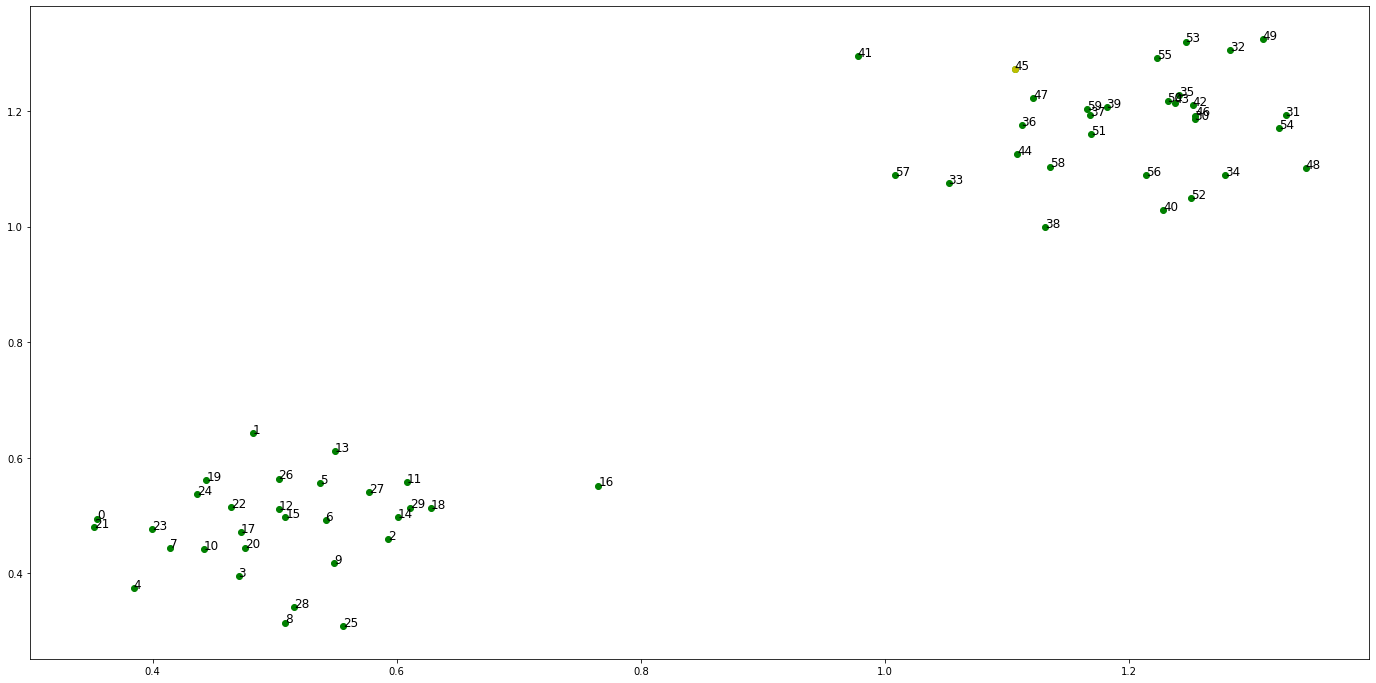

Index: 55.0
Reach dist: 0.08250461218009497

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 53.0
Reach dist: 0.09826722877864746

Index: 48.0
Reach dist: 0.1086528687610353

Index: 56.0
Reach dist: 0.11643108215552656

Index: 32.0
Reach dist: 0.12006574845835738

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 49.0
Reach dist: 0.15000035635926934

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55]


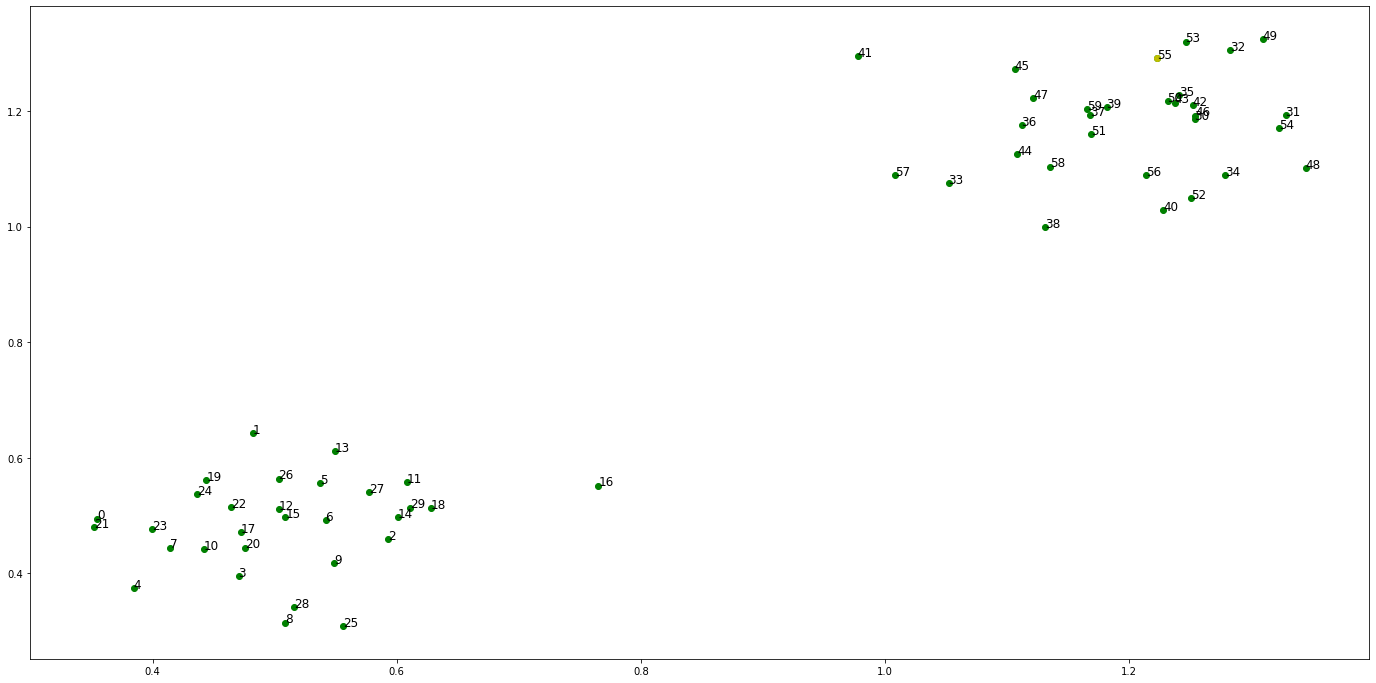

Index: 32.0
Reach dist: 0.08335095716930008

Index: 53.0
Reach dist: 0.08335095716930008

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 48.0
Reach dist: 0.1086528687610353

Index: 56.0
Reach dist: 0.11643108215552656

Index: 49.0
Reach dist: 0.11911003765976536

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32]


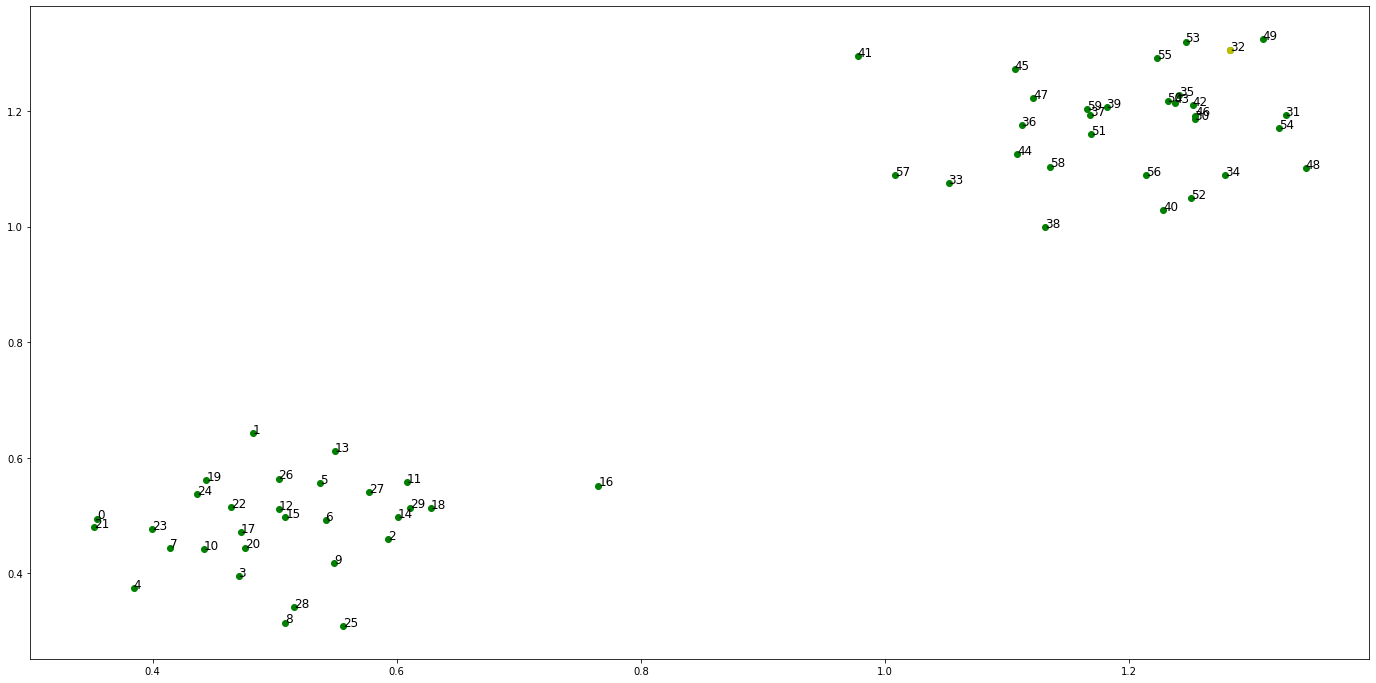

Index: 53.0
Reach dist: 0.08335095716930008

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 48.0
Reach dist: 0.1086528687610353

Index: 56.0
Reach dist: 0.11643108215552656

Index: 49.0
Reach dist: 0.11911003765976536

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53]


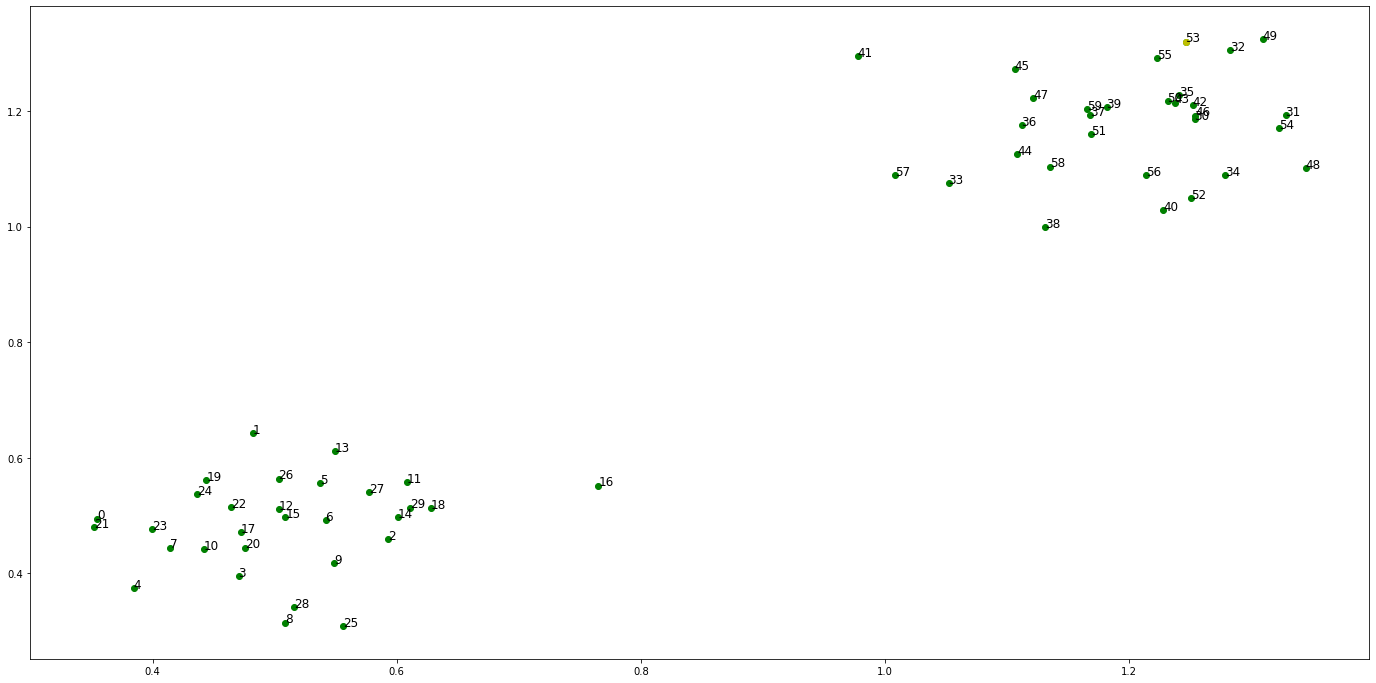

Index: 54.0
Reach dist: 0.08564047322543011

Index: 58.0
Reach dist: 0.09034896437638285

Index: 49.0
Reach dist: 0.09826722877864746

Index: 48.0
Reach dist: 0.1086528687610353

Index: 56.0
Reach dist: 0.11643108215552656

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54]


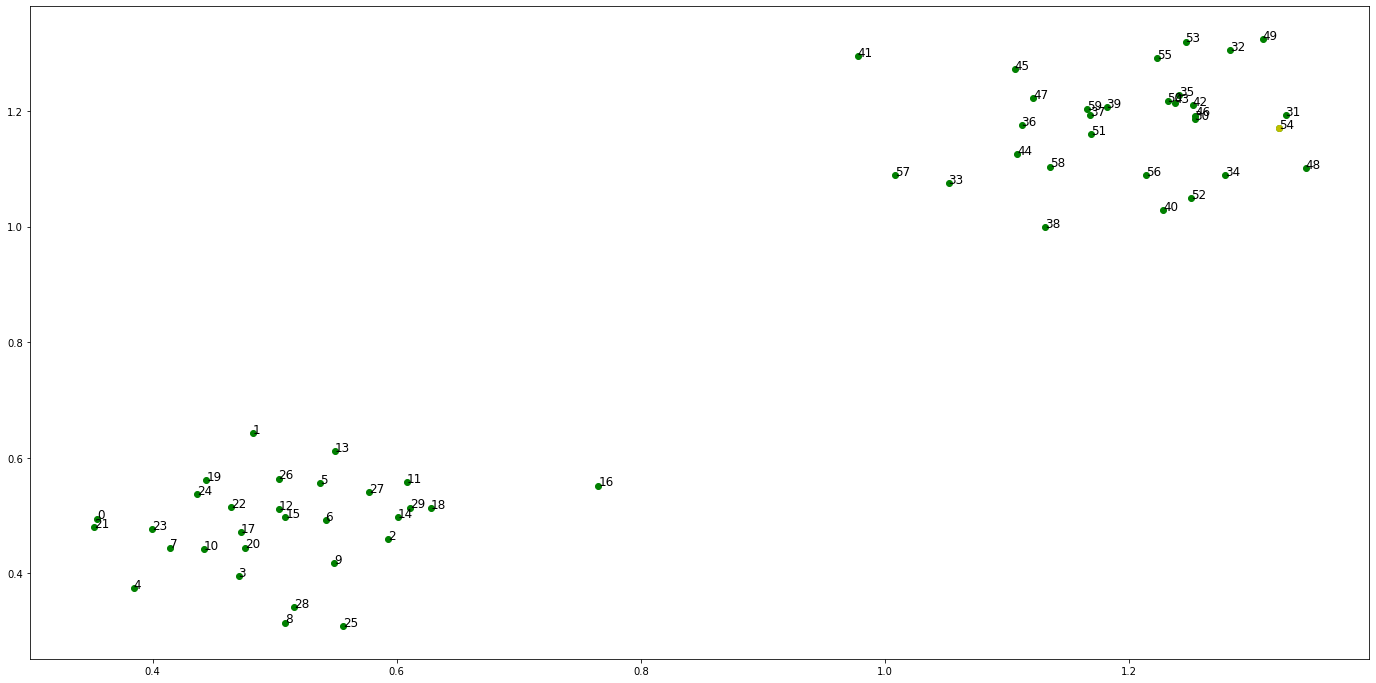

Index: 58.0
Reach dist: 0.09034896437638285

Index: 48.0
Reach dist: 0.0913635384833471

Index: 49.0
Reach dist: 0.09826722877864746

Index: 56.0
Reach dist: 0.11643108215552656

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58]


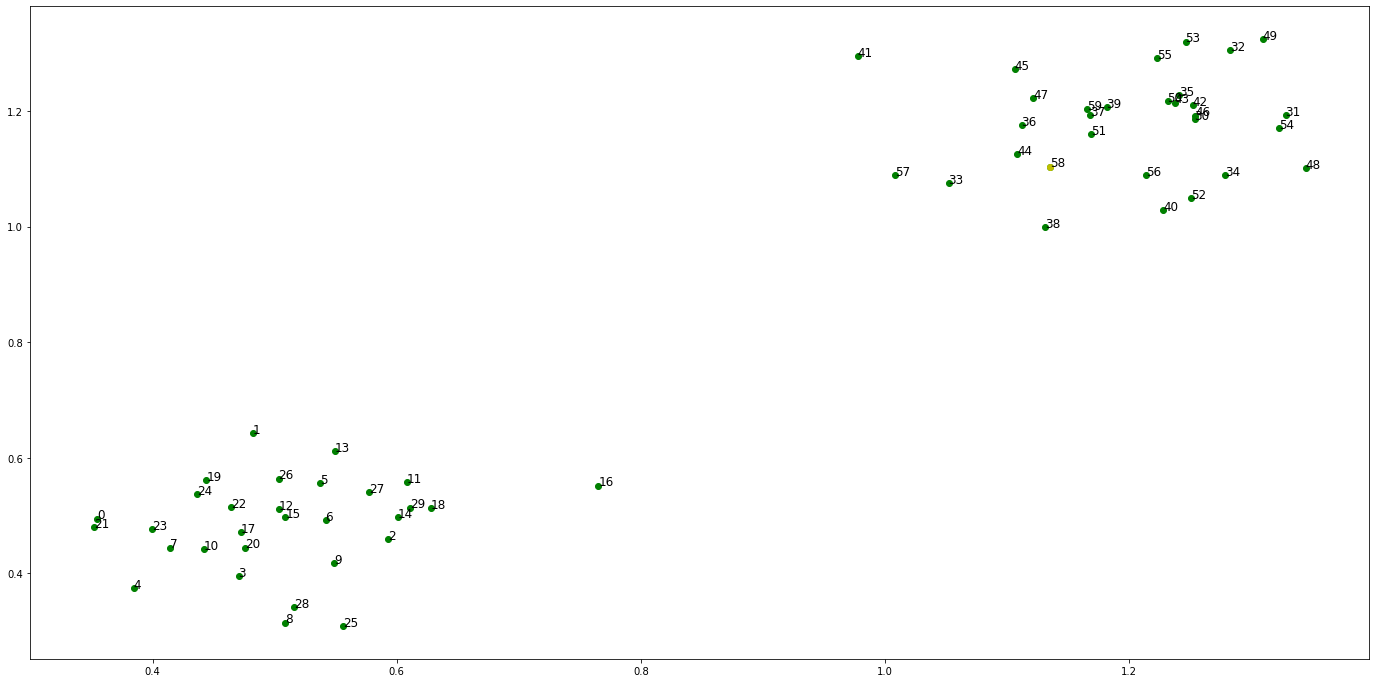

Index: 48.0
Reach dist: 0.0913635384833471

Index: 56.0
Reach dist: 0.09477192718046079

Index: 49.0
Reach dist: 0.09826722877864746

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48]


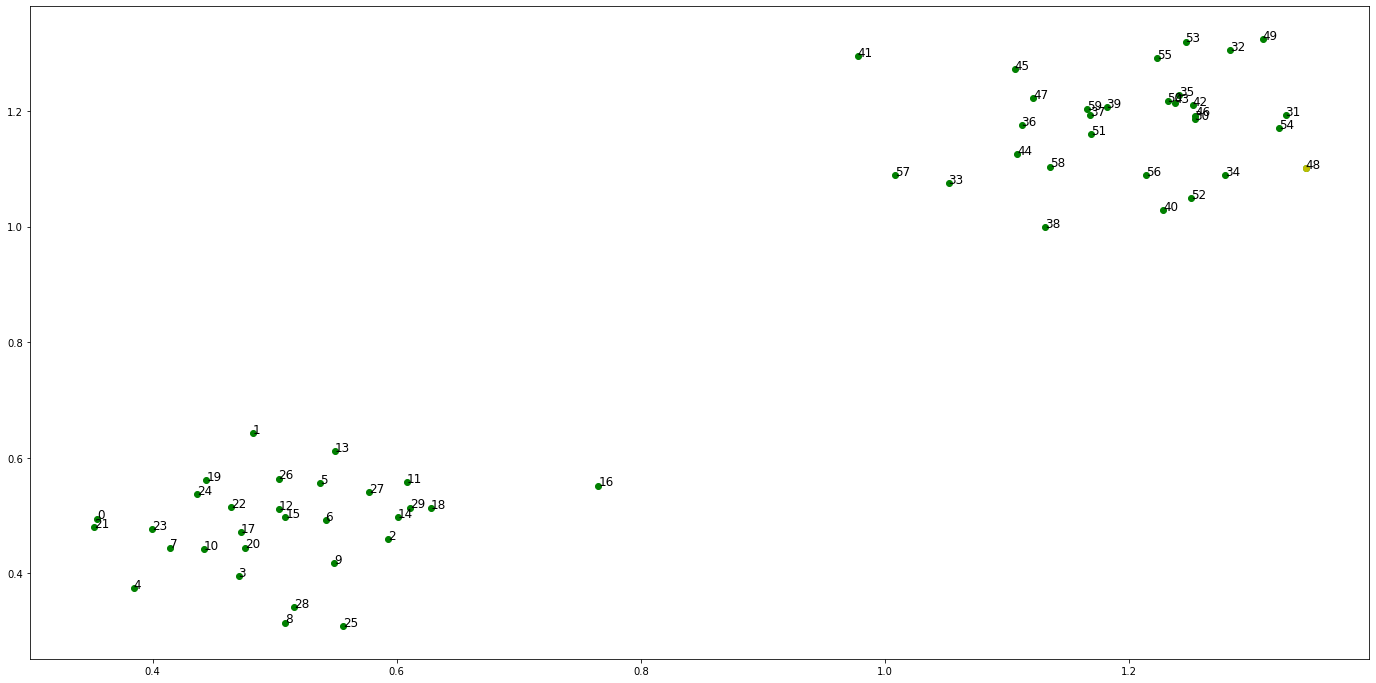

Index: 56.0
Reach dist: 0.09477192718046079

Index: 49.0
Reach dist: 0.09826722877864746

Index: 34.0
Reach dist: 0.12183380317162107

Index: 52.0
Reach dist: 0.13945684539920733

Index: 41.0
Reach dist: 0.1515366471677878

Index: 40.0
Reach dist: 0.15569964465166986


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56]


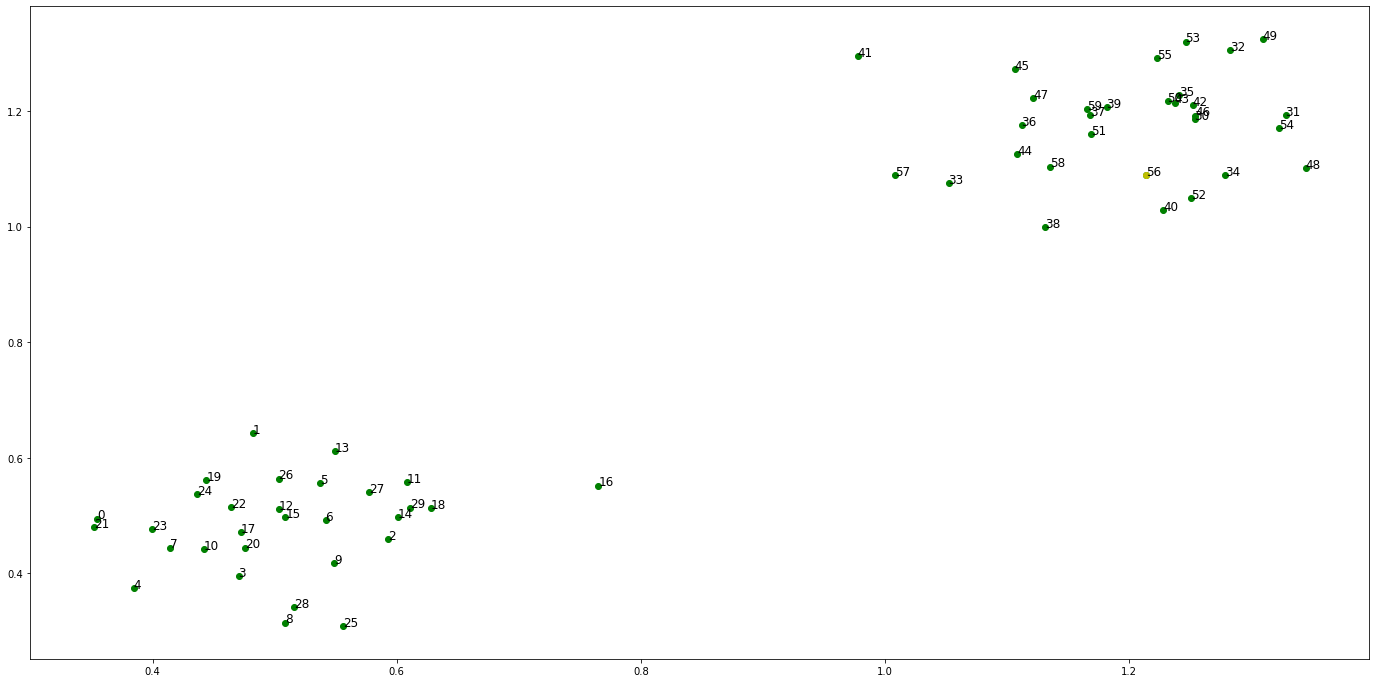

Index: 34.0
Reach dist: 0.09381290759920424

Index: 40.0
Reach dist: 0.09381290759920424

Index: 52.0
Reach dist: 0.09381290759920424

Index: 49.0
Reach dist: 0.09826722877864746

Index: 41.0
Reach dist: 0.1515366471677878


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56, 34]


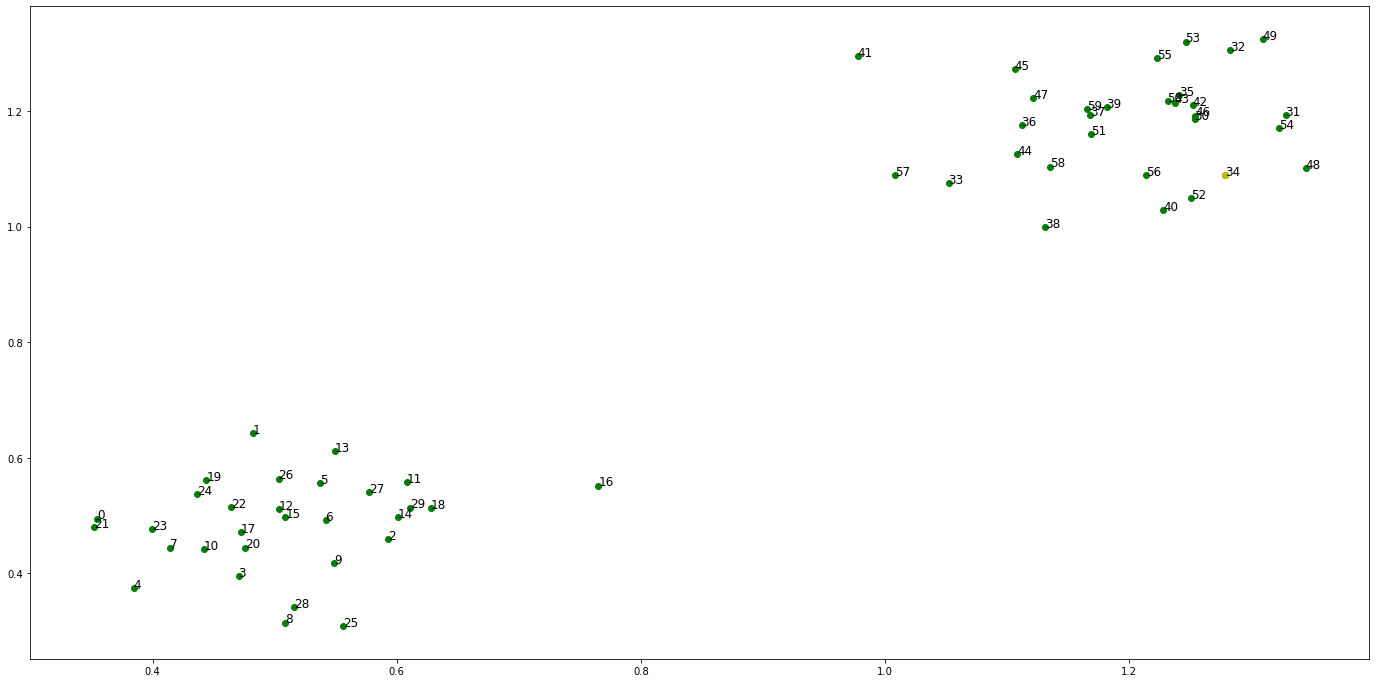

Index: 40.0
Reach dist: 0.09381290759920424

Index: 52.0
Reach dist: 0.09381290759920424

Index: 49.0
Reach dist: 0.09826722877864746

Index: 41.0
Reach dist: 0.1515366471677878


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56, 34, 40]


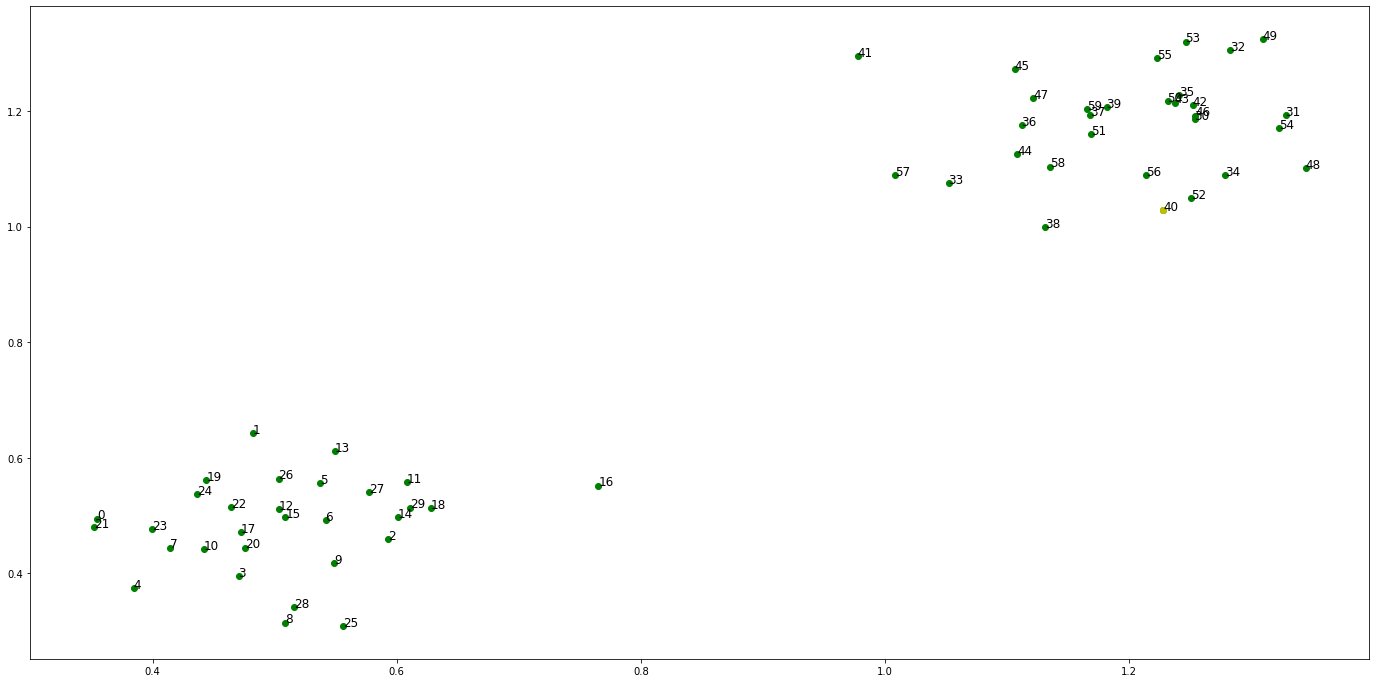

Index: 52.0
Reach dist: 0.09381290759920424

Index: 49.0
Reach dist: 0.09826722877864746

Index: 41.0
Reach dist: 0.1515366471677878


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56, 34, 40, 52]


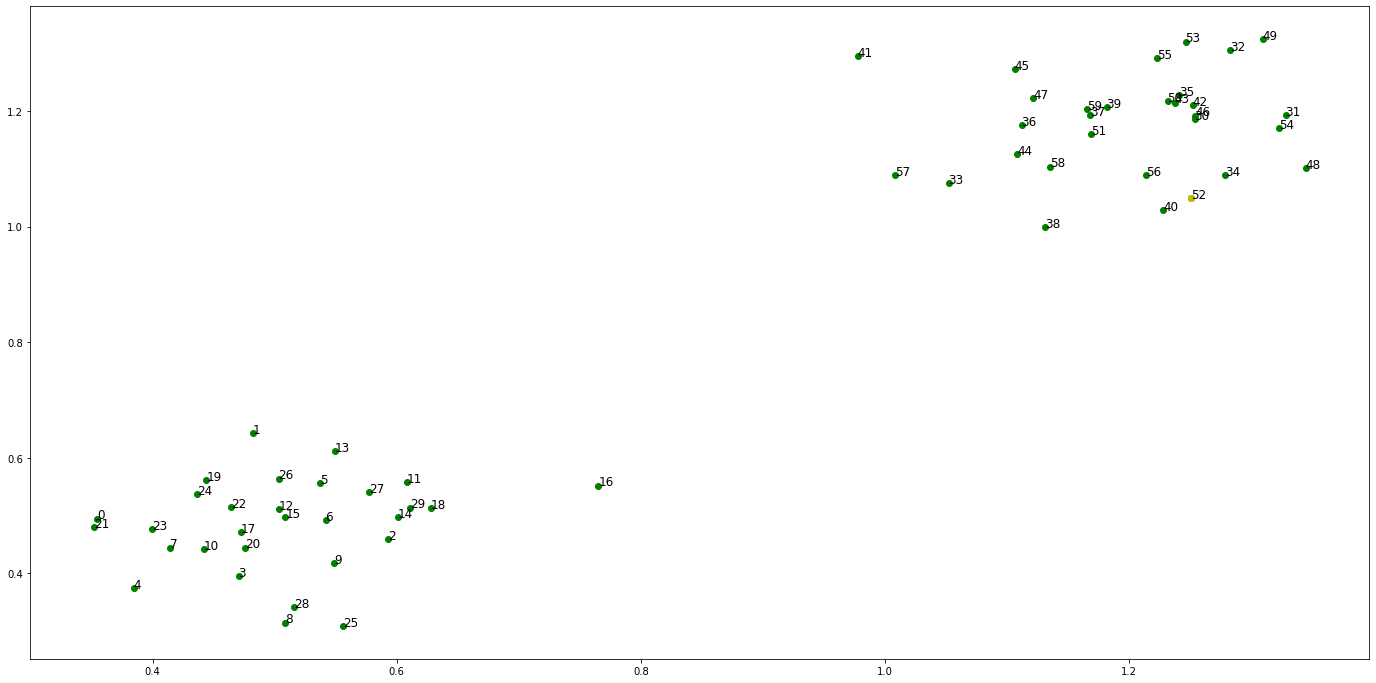

Index: 49.0
Reach dist: 0.09826722877864746

Index: 41.0
Reach dist: 0.1515366471677878


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56, 34, 40, 52, 49]


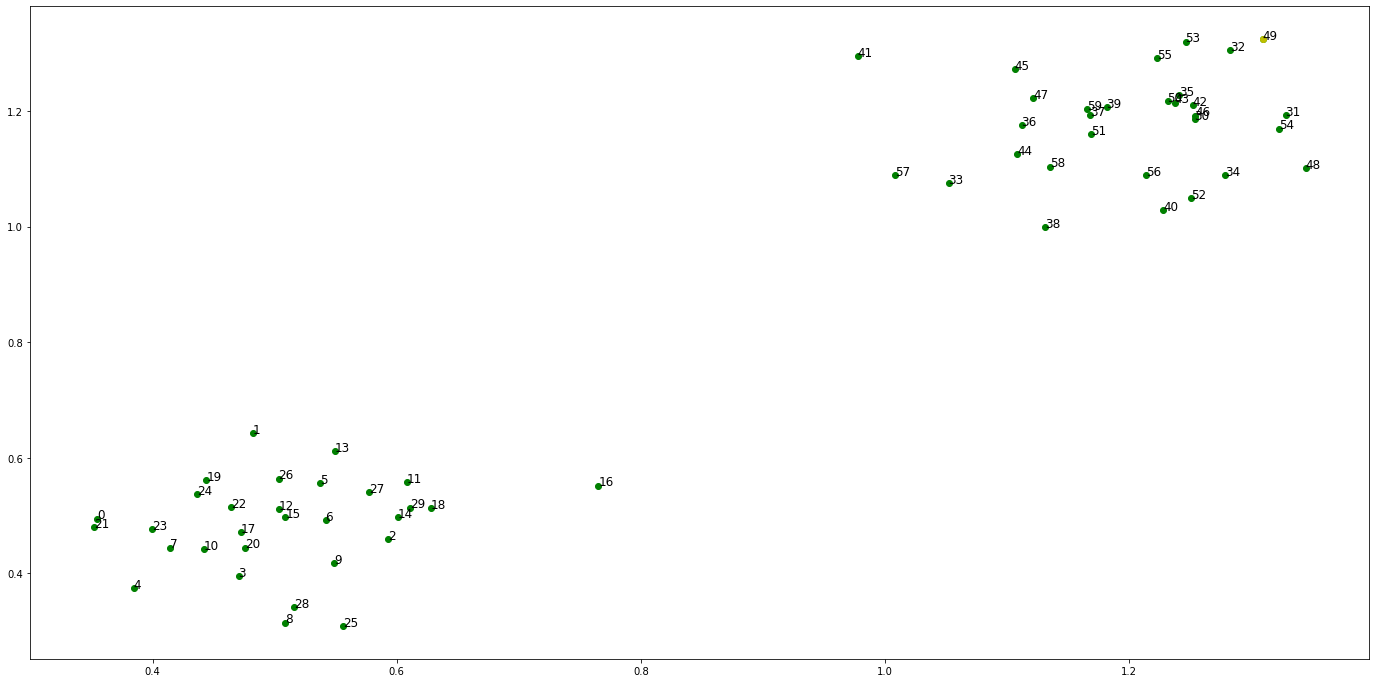

Index: 41.0
Reach dist: 0.1515366471677878


[0, 7, 10, 3, 17, 15, 20, 22, 12, 6, 26, 24, 19, 5, 14, 2, 18, 29, 11, 27, 13, 23, 21, 9, 1, 28, 4, 8, 25, 16, 57, 33, 38, 44, 36, 37, 47, 51, 39, 50, 35, 42, 30, 43, 46, 59, 31, 45, 55, 32, 53, 54, 58, 48, 56, 34, 40, 52, 49, 41]


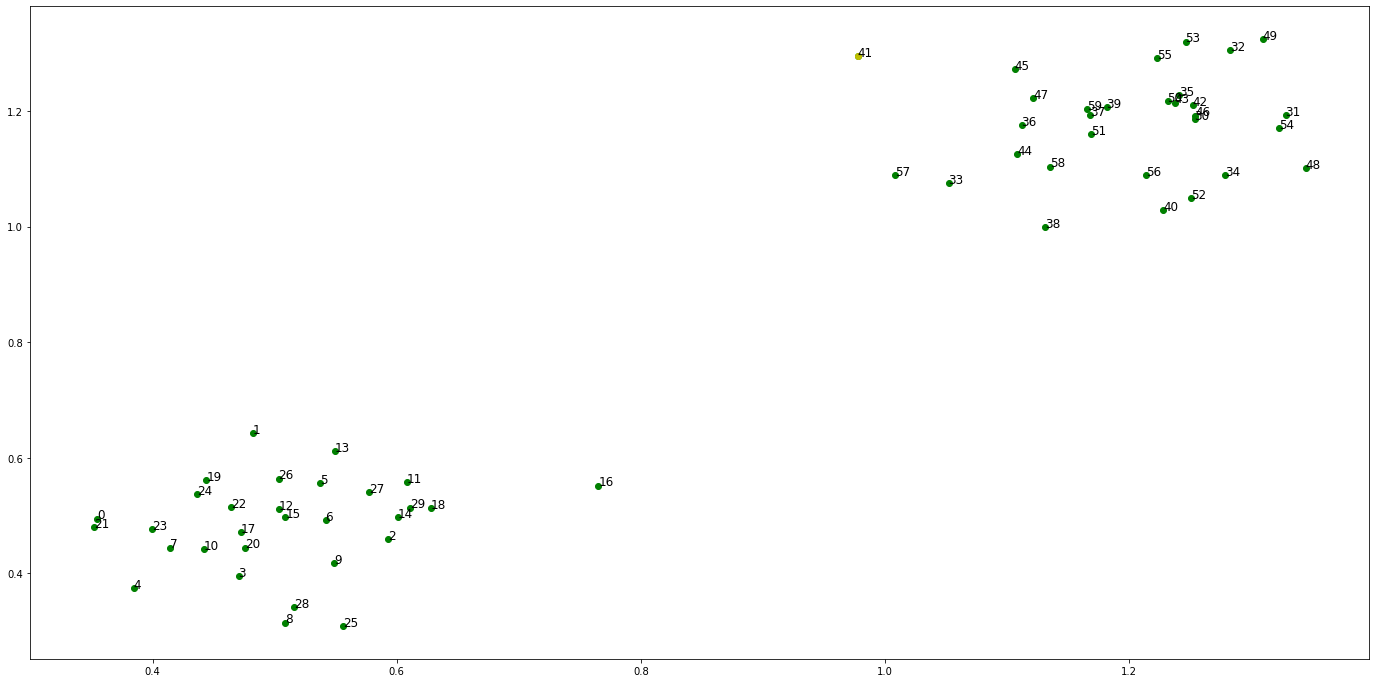

nothing


In [53]:
for obj in allObjects:
    if obj.processed == False:
        expand_cluster_order(obj, allObjects, pq, order)

In [68]:
obj_num = len(order)

In [87]:
t1 = np.linspace(0, 1, int(obj_num / 3) + 1)
t1 = t1[:, np.newaxis]
t1

array([[0.  ],
       [0.05],
       [0.1 ],
       [0.15],
       [0.2 ],
       [0.25],
       [0.3 ],
       [0.35],
       [0.4 ],
       [0.45],
       [0.5 ],
       [0.55],
       [0.6 ],
       [0.65],
       [0.7 ],
       [0.75],
       [0.8 ],
       [0.85],
       [0.9 ],
       [0.95],
       [1.  ]])

In [76]:
t2 = np.zeros(((int(obj_num / 3) + 1), 2))
t2

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [89]:
t3 = np.hstack((t1, t2))
t3

array([[0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  ],
       [0.1 , 0.  , 0.  ],
       [0.15, 0.  , 0.  ],
       [0.2 , 0.  , 0.  ],
       [0.25, 0.  , 0.  ],
       [0.3 , 0.  , 0.  ],
       [0.35, 0.  , 0.  ],
       [0.4 , 0.  , 0.  ],
       [0.45, 0.  , 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.55, 0.  , 0.  ],
       [0.6 , 0.  , 0.  ],
       [0.65, 0.  , 0.  ],
       [0.7 , 0.  , 0.  ],
       [0.75, 0.  , 0.  ],
       [0.8 , 0.  , 0.  ],
       [0.85, 0.  , 0.  ],
       [0.9 , 0.  , 0.  ],
       [0.95, 0.  , 0.  ],
       [1.  , 0.  , 0.  ]])

In [95]:
t4 = np.copy(t3)
t4[:, 1] = t4[:, 0]
t4[:, 0] = 1
t4

array([[1.  , 0.  , 0.  ],
       [1.  , 0.05, 0.  ],
       [1.  , 0.1 , 0.  ],
       [1.  , 0.15, 0.  ],
       [1.  , 0.2 , 0.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 0.3 , 0.  ],
       [1.  , 0.35, 0.  ],
       [1.  , 0.4 , 0.  ],
       [1.  , 0.45, 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.55, 0.  ],
       [1.  , 0.6 , 0.  ],
       [1.  , 0.65, 0.  ],
       [1.  , 0.7 , 0.  ],
       [1.  , 0.75, 0.  ],
       [1.  , 0.8 , 0.  ],
       [1.  , 0.85, 0.  ],
       [1.  , 0.9 , 0.  ],
       [1.  , 0.95, 0.  ],
       [1.  , 1.  , 0.  ]])

In [96]:
t5 = np.ones(((int(obj_num / 3) + 1), 2))
t5

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [98]:
t6 = np.hstack((t5, t1))
t6

array([[1.  , 1.  , 0.  ],
       [1.  , 1.  , 0.05],
       [1.  , 1.  , 0.1 ],
       [1.  , 1.  , 0.15],
       [1.  , 1.  , 0.2 ],
       [1.  , 1.  , 0.25],
       [1.  , 1.  , 0.3 ],
       [1.  , 1.  , 0.35],
       [1.  , 1.  , 0.4 ],
       [1.  , 1.  , 0.45],
       [1.  , 1.  , 0.5 ],
       [1.  , 1.  , 0.55],
       [1.  , 1.  , 0.6 ],
       [1.  , 1.  , 0.65],
       [1.  , 1.  , 0.7 ],
       [1.  , 1.  , 0.75],
       [1.  , 1.  , 0.8 ],
       [1.  , 1.  , 0.85],
       [1.  , 1.  , 0.9 ],
       [1.  , 1.  , 0.95],
       [1.  , 1.  , 1.  ]])

In [105]:
t7 = np.vstack((t3[:int(obj_num / 3) - 1], t4[:int(obj_num / 3) - 1], t6))
t7

array([[0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  ],
       [0.1 , 0.  , 0.  ],
       [0.15, 0.  , 0.  ],
       [0.2 , 0.  , 0.  ],
       [0.25, 0.  , 0.  ],
       [0.3 , 0.  , 0.  ],
       [0.35, 0.  , 0.  ],
       [0.4 , 0.  , 0.  ],
       [0.45, 0.  , 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.55, 0.  , 0.  ],
       [0.6 , 0.  , 0.  ],
       [0.65, 0.  , 0.  ],
       [0.7 , 0.  , 0.  ],
       [0.75, 0.  , 0.  ],
       [0.8 , 0.  , 0.  ],
       [0.85, 0.  , 0.  ],
       [0.9 , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.05, 0.  ],
       [1.  , 0.1 , 0.  ],
       [1.  , 0.15, 0.  ],
       [1.  , 0.2 , 0.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 0.3 , 0.  ],
       [1.  , 0.35, 0.  ],
       [1.  , 0.4 , 0.  ],
       [1.  , 0.45, 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.55, 0.  ],
       [1.  , 0.6 , 0.  ],
       [1.  , 0.65, 0.  ],
       [1.  , 0.7 , 0.  ],
       [1.  , 0.75, 0.  ],
       [1.  , 0.8 , 0.  ],
       [1.  , 0.85, 0.  ],
 

In [165]:
def create_colors(obj_num):
    # создаёт последовательность цветов для всех отрезков, соединяющих точки в порядке массива order
    
    if (obj_num % 3 != 0): # для некратного трём obj_num вычисляется чуть больше цветов (до ближайшего кратного)
        obj_num += 1
        if (obj_num % 3 != 0):
            obj_num += 1
    
    color_change = int(obj_num / 3) + 1
    t1 = np.linspace(0, 0.6, color_change)
    t1 = t1[:, np.newaxis]
    t2 = np.zeros((color_change, 2))
    t3 = np.hstack((t1, t2))
    t4 = np.copy(t3)
    t4[:, 1] = t4[:, 0]
    t4[:, 0] = 1
    t5 = np.ones((color_change, 2))
    t6 = np.hstack((t5, t1))
    t7 = np.vstack((t3[:color_change - 2], t4[:color_change - 2], t6))
    return t7

In [166]:
create_colors(60)

array([[0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.  ],
       [0.06, 0.  , 0.  ],
       [0.09, 0.  , 0.  ],
       [0.12, 0.  , 0.  ],
       [0.15, 0.  , 0.  ],
       [0.18, 0.  , 0.  ],
       [0.21, 0.  , 0.  ],
       [0.24, 0.  , 0.  ],
       [0.27, 0.  , 0.  ],
       [0.3 , 0.  , 0.  ],
       [0.33, 0.  , 0.  ],
       [0.36, 0.  , 0.  ],
       [0.39, 0.  , 0.  ],
       [0.42, 0.  , 0.  ],
       [0.45, 0.  , 0.  ],
       [0.48, 0.  , 0.  ],
       [0.51, 0.  , 0.  ],
       [0.54, 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.03, 0.  ],
       [1.  , 0.06, 0.  ],
       [1.  , 0.09, 0.  ],
       [1.  , 0.12, 0.  ],
       [1.  , 0.15, 0.  ],
       [1.  , 0.18, 0.  ],
       [1.  , 0.21, 0.  ],
       [1.  , 0.24, 0.  ],
       [1.  , 0.27, 0.  ],
       [1.  , 0.3 , 0.  ],
       [1.  , 0.33, 0.  ],
       [1.  , 0.36, 0.  ],
       [1.  , 0.39, 0.  ],
       [1.  , 0.42, 0.  ],
       [1.  , 0.45, 0.  ],
       [1.  , 0.48, 0.  ],
       [1.  , 0.51, 0.  ],
 

In [167]:
len(create_colors(11))

11

In [168]:
t = allObjects[order]
t[:allObjects.shape[0] - 1].shape

(59,)

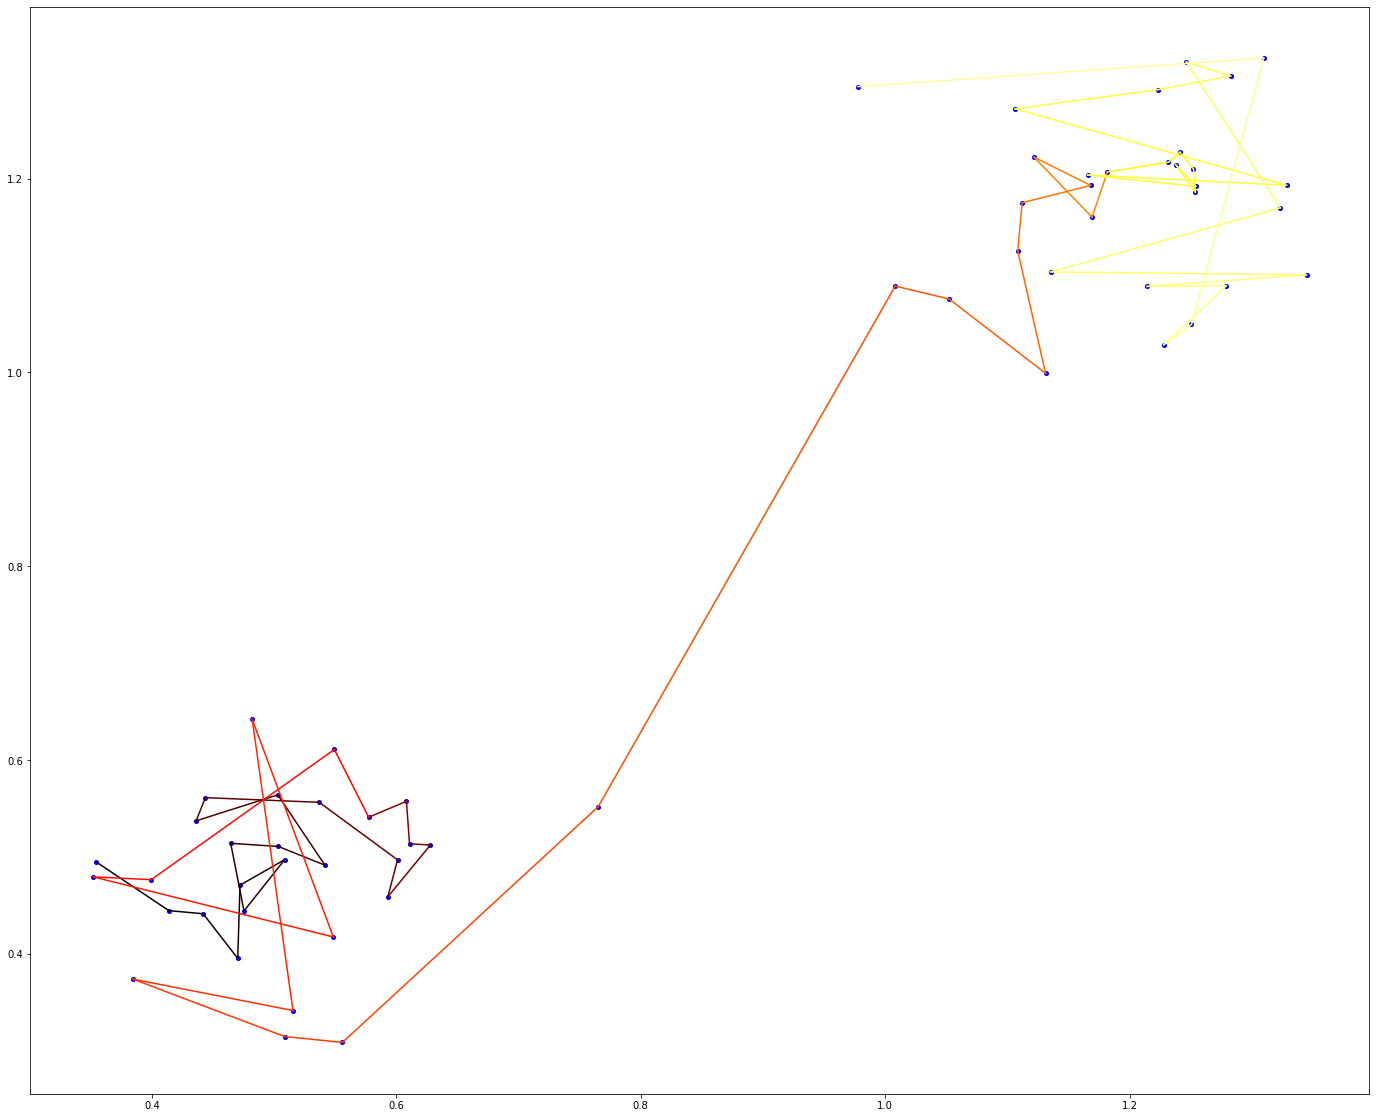

In [169]:
colors_array = create_colors(allObjects.shape[0])
colors_tuple = list(map(tuple, colors_array[:]))

fig, ax = plt.subplots(figsize=(24, 20))
for obj1, obj2, color in zip(allObjects[order][:allObjects.shape[0] - 1], allObjects[order][1:], colors_tuple):
    
    plot_partx = [obj1.coords[0], obj2.coords[0]]
    plot_party = [obj1.coords[1], obj2.coords[1]]
    ax.plot(plot_partx, plot_party, c=color)

ax.scatter(data[:,0], data[:,1], s=16, c='b')

plt.show()

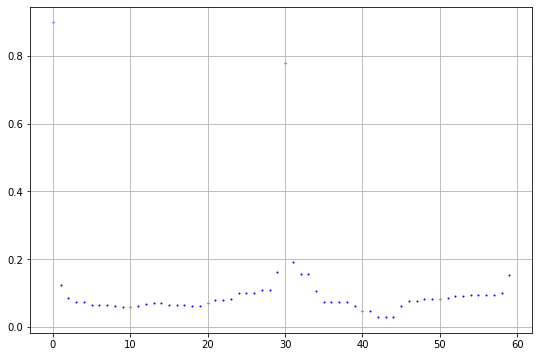

In [152]:
fig, ax = plt.subplots(figsize=(9, 6))

reach = []
for obj in allObjects:
    if type(obj.reachability_distance) == type(None):
        reach.append(0.9)
    else:
        reach.append(obj.reachability_distance)
reach = np.array(reach)

ax.scatter(np.arange(0,reach.shape[0]), reach[order], s=1, c='b')
plt.grid(True)
plt.show()

In [162]:
ind_cl = np.concatenate([np.ones((29)), np.array([-1]), np.ones((30))*2])
ind_cl

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [163]:
ind_cl[order]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

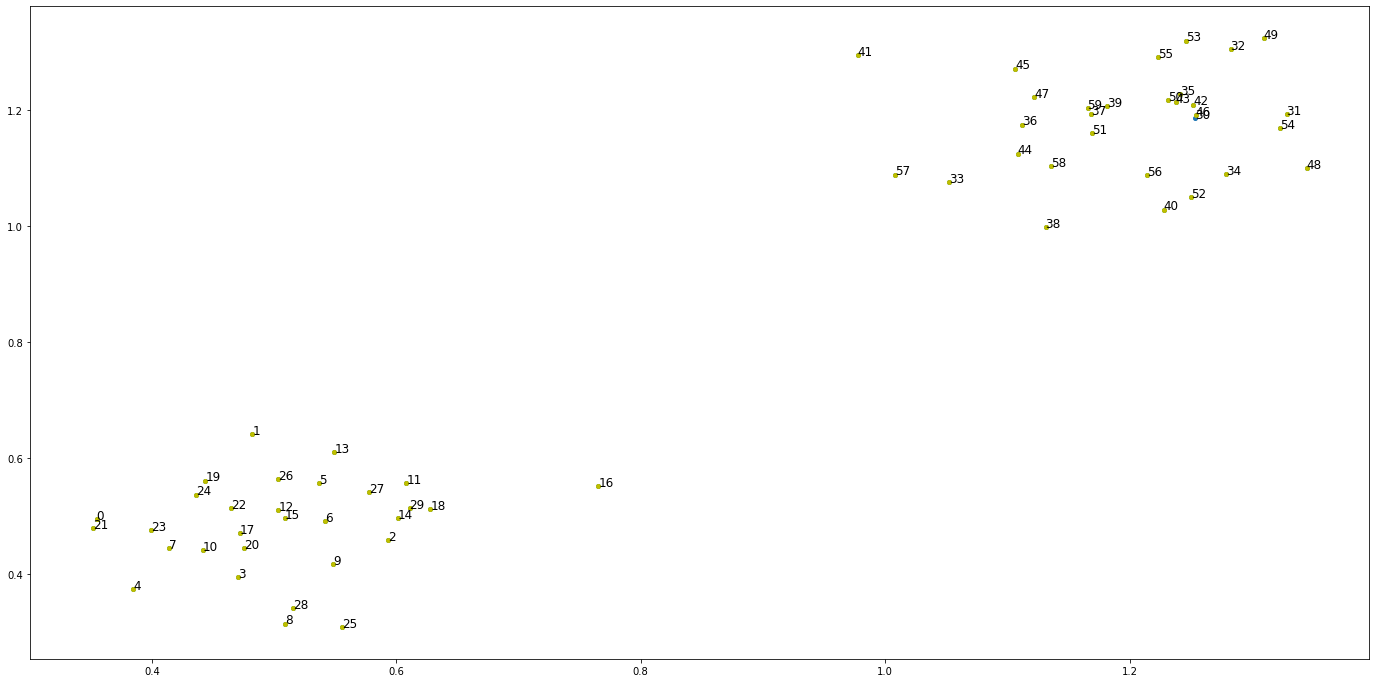

In [33]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(data[:,0], data[:,1], s=16)
#ax.scatter(data[ind_cl[:15],0], data[ind_cl[:15],1], s=16, c='y')
ax.scatter(data[ind_cl,0], data[ind_cl,1], s=16, c='y')

ind = 0
for obj in data:
    ax.annotate(str(ind), xy=(obj[0], obj[1]), size=12)
    ind += 1

plt.show()